In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore

# from mcmodels.core.utils import get_regionalized_normalized_data
# from mcmodels.core.utils import get_connectivity
# from mcmodels.core.utils import get_ontological_order_leaf
# from mcmodels.core.utils import get_nw_loocv,get_wt_inds
# from mcmodels.core.utils import get_countvec
# from mcmodels.core.utils import get_injection_hemisphere_id
# from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
# from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [4]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False)

512
703
1089
1097
315
313
354
698
771
803
477
549


In [5]:
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)

In [6]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [8]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [9]:
# %matplotlib notebook
# #%matplotlib inline
# fig = plt.figure()
# ax = Axes3D(fig)

# # ax.scatter(msvds[sid].projection_mask.coordinates[:,0], 
# #            msvds[sid].projection_mask.coordinates[:,1], 
# #            msvds[sid].projection_mask.coordinates[:,2], alpha = .01, s = .1)

# ind = 0
# nvox = connectivity_data.structure_datas[sid].injections.shape[1]
# inj_colors = np.zeros((nvox,4))
# inj_colors[:,1] = 1.0
# inj_colors[:, 3] = connectivity_data.structure_datas[sid].injections[ind] / connectivity_data.structure_datas[sid].injections[ind].max()


# # ax.scatter(m4.coordinates[:,0], 
# #            m4.coordinates[:,1], 
# #            m4.coordinates[:,2], s= .1, c= 'yellow')

# # ax.scatter(m5.coordinates[:,0], 
# #            m5.coordinates[:,1], 
# #            m5.coordinates[:,2], s= .1, c= 'purple')

# # ax.scatter(m6a.coordinates[:,0], 
# #            m6a.coordinates[:,1], 
# #            m6a.coordinates[:,2], s= .1, c= 'red')

# ax.scatter(connectivity_data.structure_datas[sid].centroids[ind][0],
#           connectivity_data.structure_datas[sid].centroids[ind][1],
#           connectivity_data.structure_datas[sid].centroids[ind][2], s = 5)

# ax.scatter(connectivity_data.structure_datas[sid].injection_mask.coordinates[:,0], 
#            connectivity_data.structure_datas[sid].injection_mask.coordinates[:,1], 
#            connectivity_data.structure_datas[sid].injection_mask.coordinates[:,2], s= 1, c= inj_colors)

# ax.set_axis_off()

In [10]:
from mcmodels.core import Mask

In [10]:
# for m in range(len(major_structure_ids)):
#     print(m)
#     sid = major_structure_ids[m]
#     source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
#     source_key = source_mask.get_key(structure_ids=ontological_order_leaves)
#     source_regions, source_counts = nonzero_unique(source_key, return_counts=True)

# #    injs = msvds_leaf[sid].reg_inj_vcount_norm
# #    injr = np.reshape(injs, injs.shape[0]*injs.shape[1]) #first injes[0], then injs[1]
#     nexp = connectivity_data.structure_datas[sid].reg_inj.shape[0]
# #    leaf = np.tile(source_regions, nexp)#np.tile(source_regions, injs.shape[0])
# #    cree = np.repeat(creline[sid], injs.shape[1])

# #     ls = [ia_map[leaf[i]] for i in range(len(leaf))]
# #     crs = cree
# #     df = pd.DataFrame(np.asarray([ls, crs, injr]).transpose())
# #     df.columns = np.asarray(['leaf', 'creline','inj'])
# #     df['inj'] = np.asarray(df['inj'], dtype = float)
# #     a = df.pivot_table(values='inj',index='leaf',columns='creline',aggfunc=np.mean)

# #     fig, ax = plt.subplots(1,figsize = (50,50))
# #     sns.heatmap(a, vmax = .001,ax = ax)
# #     plt.title(str(major_structures[m]) + ' injection density')
# #     plt.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' injection density')
    
#     ls = [ia_map[leafs[sid][i]] for i in range(len(leafs[sid]))]
#     crs = connectivity_data.creline[sid]
#     df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
#     df.columns = np.asarray(['leaf', 'creline','present'])
#     a = df.pivot_table(values='present',index='leaf',columns='creline',aggfunc=np.sum)

#     fig, ax = plt.subplots(1,figsize = (50,50))
#     sns.heatmap(a, ax = ax)
#     plt.title(str(major_structures[m]) + ' centroid density')
#     plt.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' centroid density2')
    
#     #plt.xlabel(fontsize = 15)

In [11]:
#a = a.fillna(0)

In [12]:
#pd.DataFrame(a, dtype=int)

In [13]:
#     fig, ax = plt.subplots(1,figsize = (50,50))
#     sns.heatmap(a, ax = ax)


In [14]:
# a = a.fillna(0)
# revels = a
# ticks=np.arange(revels.values.min(),revels.values.max()+1 )
# boundaries = np.arange(revels.values.min()-.5,revels.values.max()+1.5 )
# cmap = plt.get_cmap("YlOrRd", revels.values.max()-revels.values.min()+1)
# fig, ax = plt.subplots(figsize = (15,15))
# sns.heatmap(revels, annot=True, linewidths=0.4, cmap=cmap,
#         cbar_kws={"ticks":ticks, "boundaries":boundaries}, ax=ax)
# plt.tight_layout()
# plt.show()
# plt.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' centroid density2')

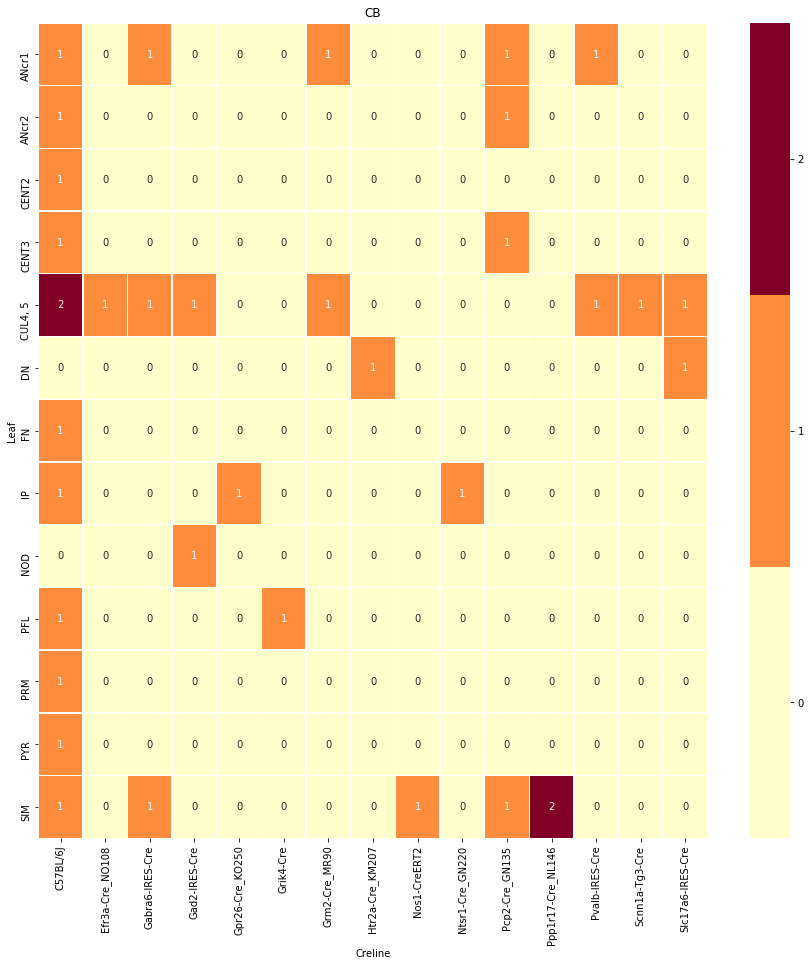

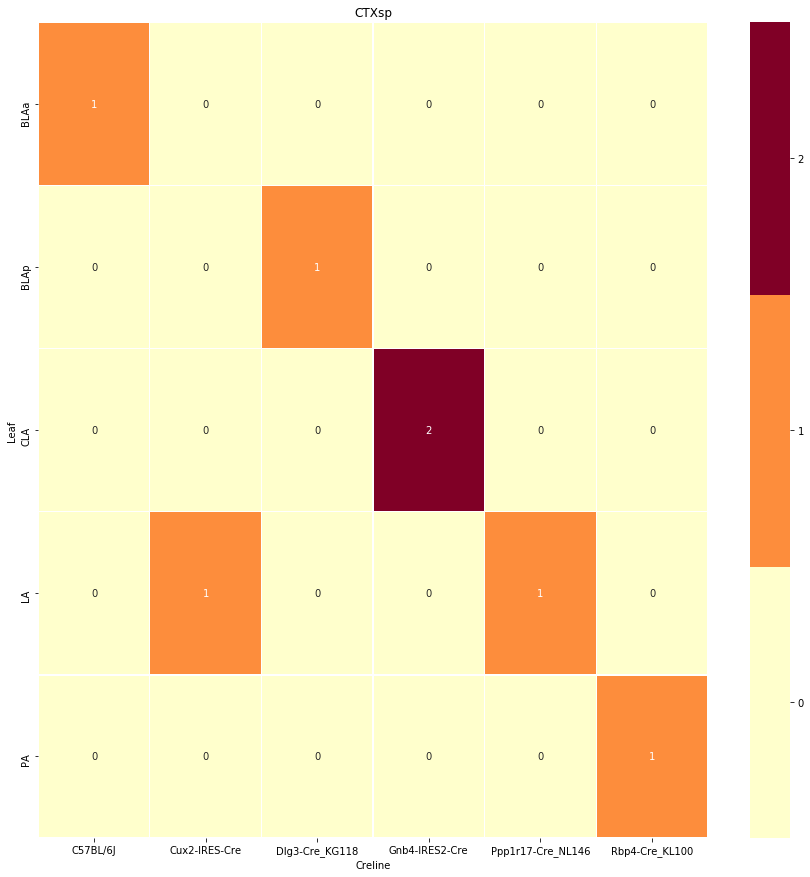

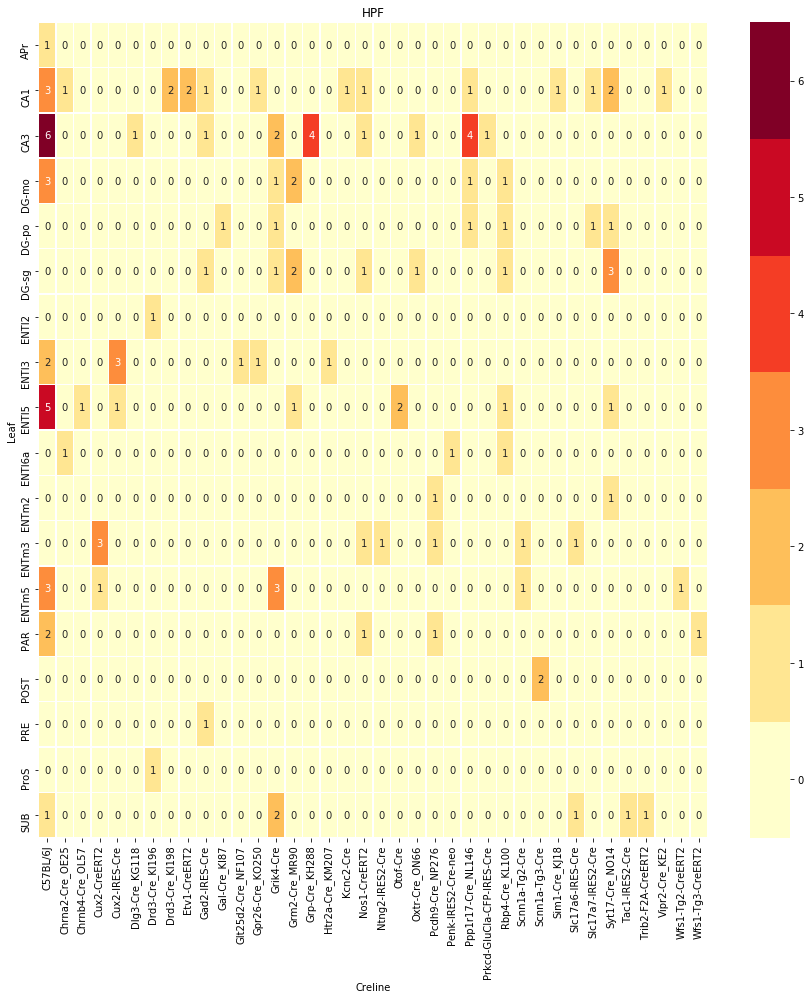

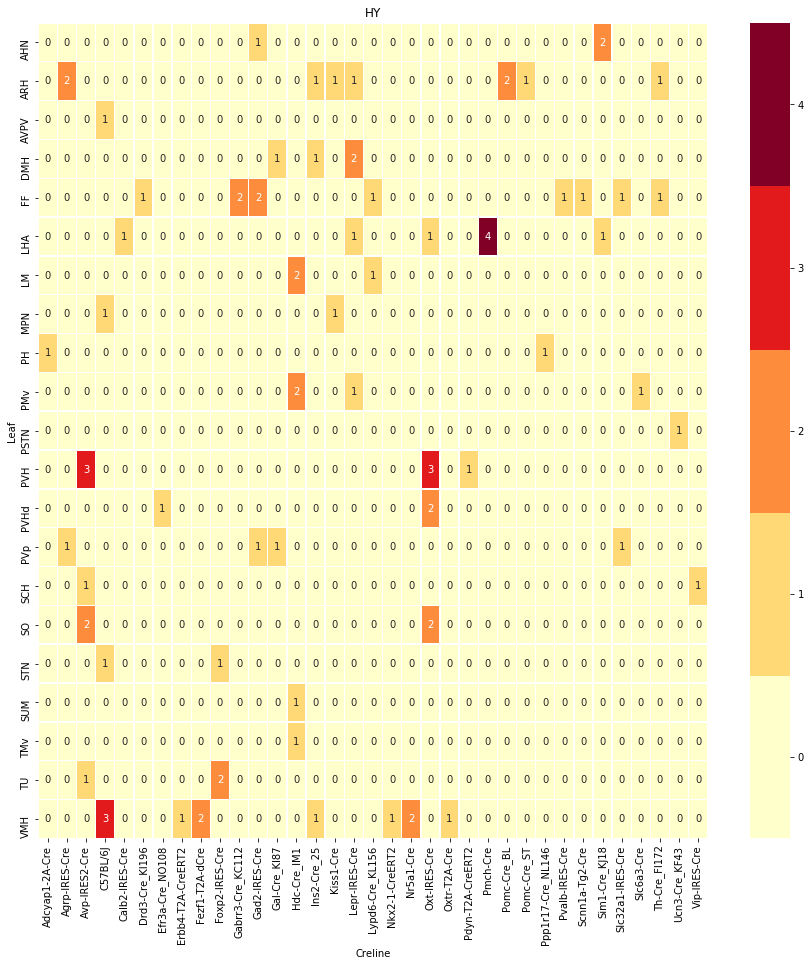

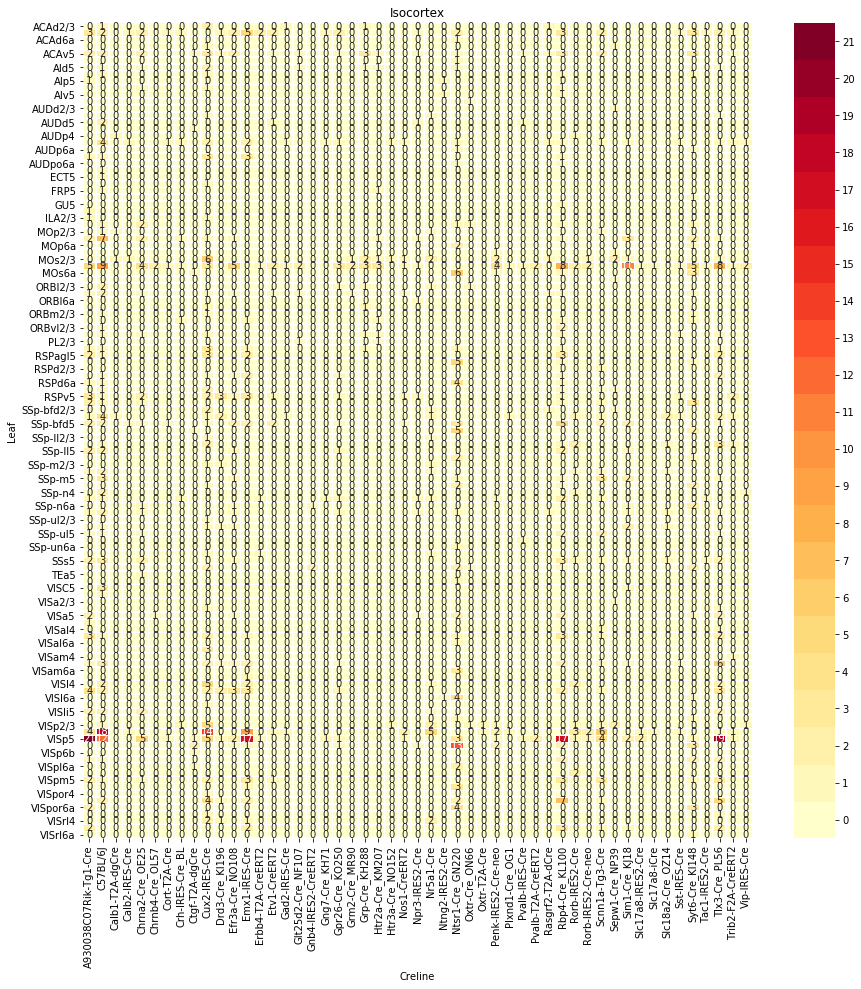

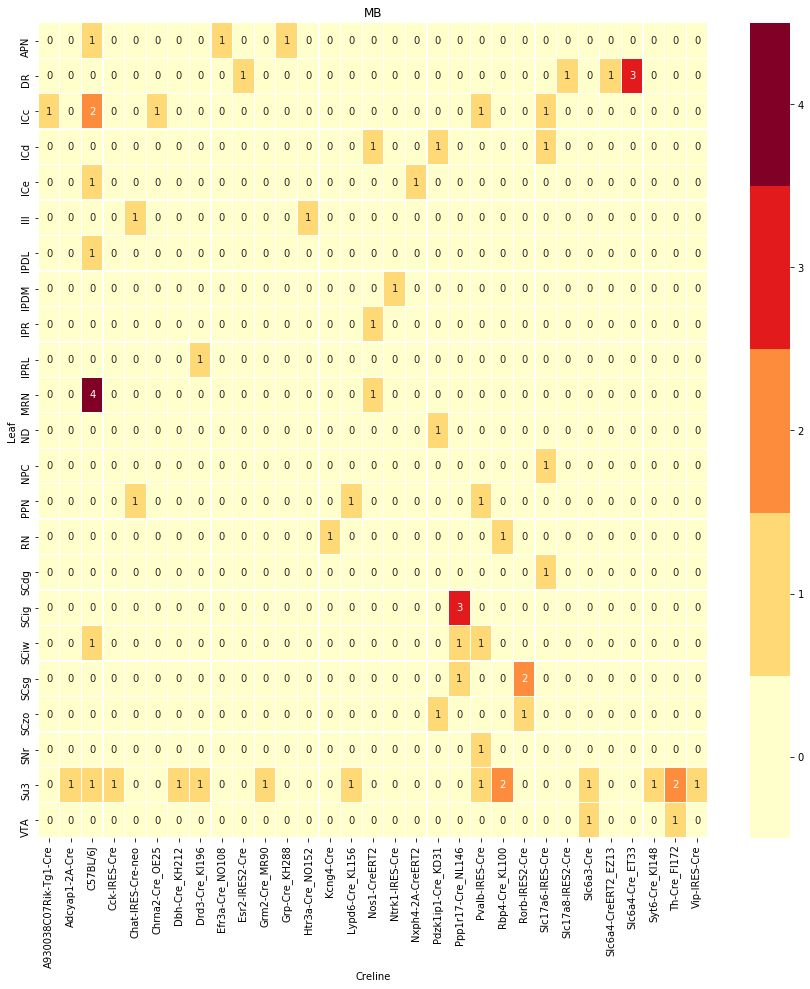

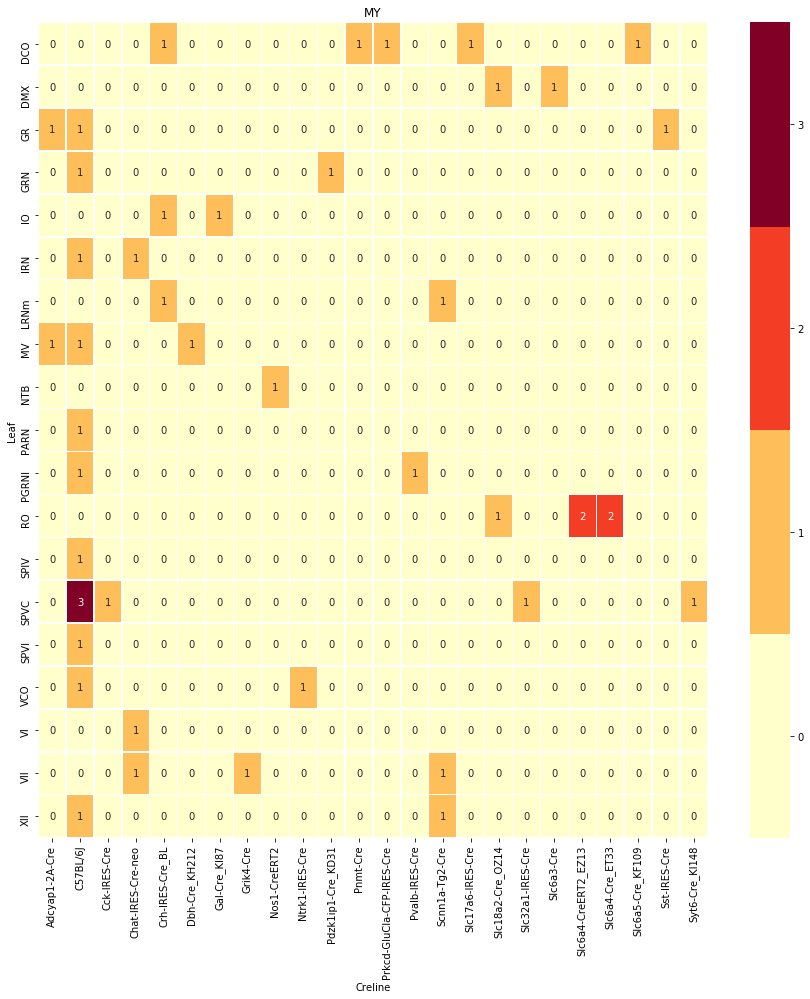

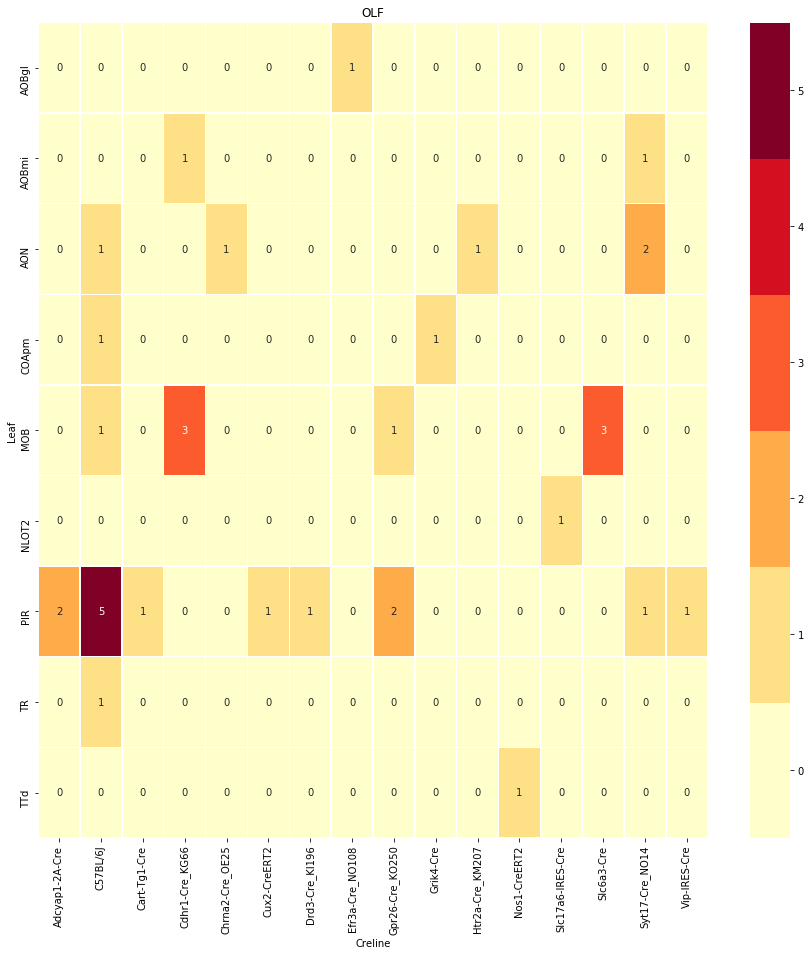

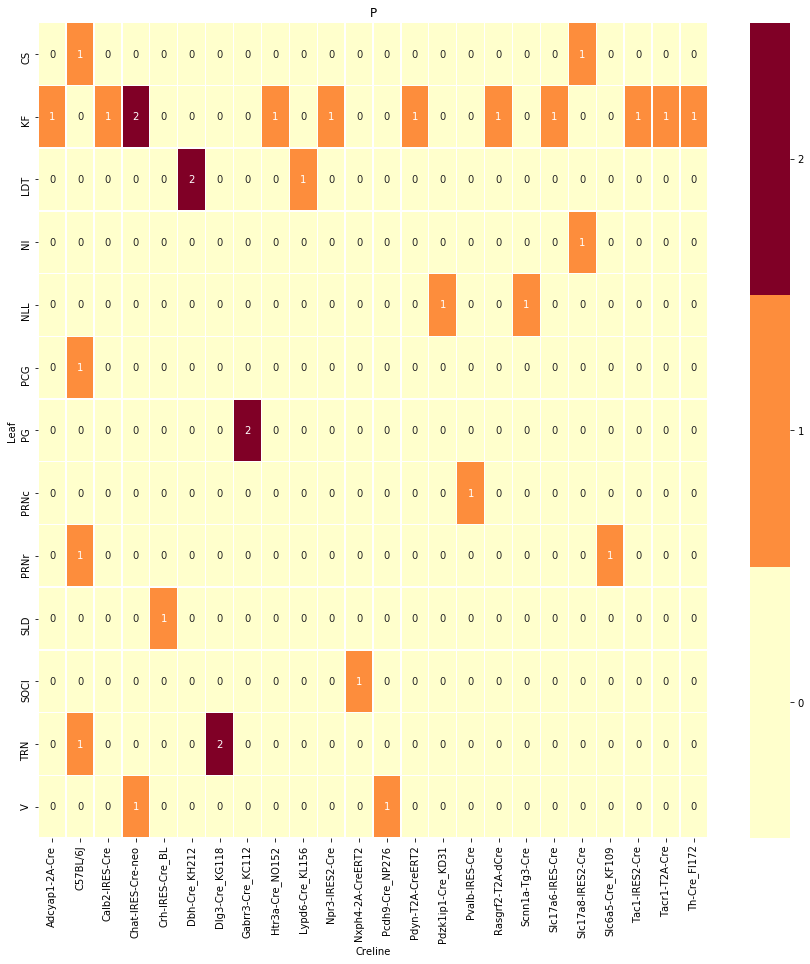

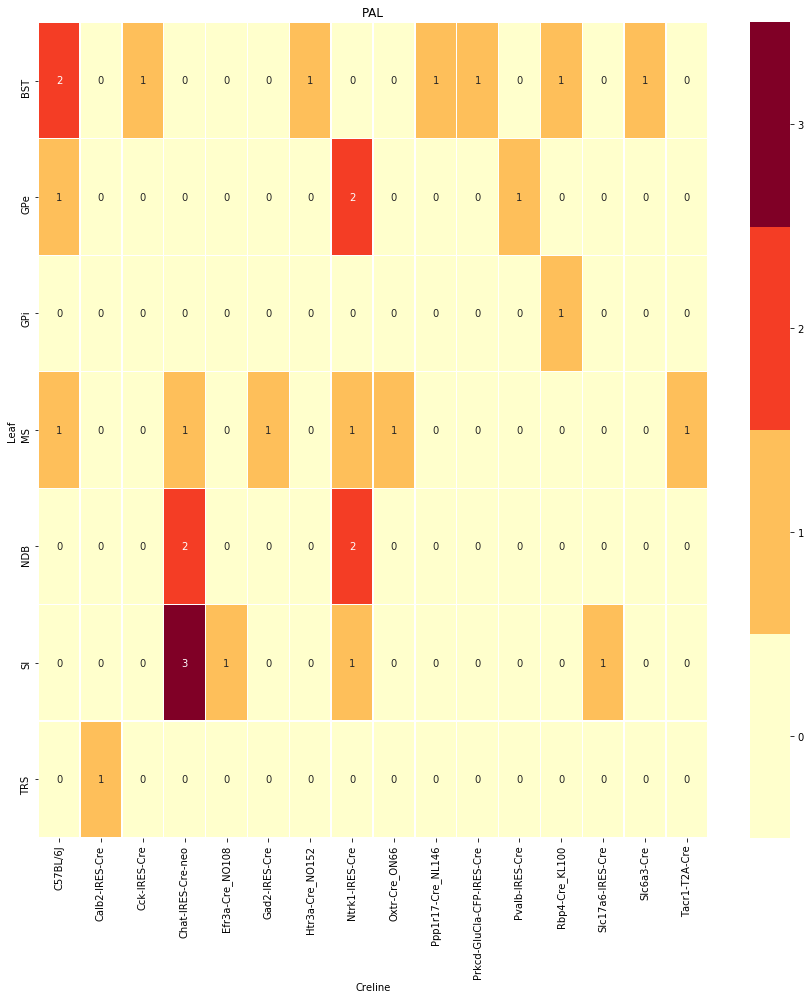

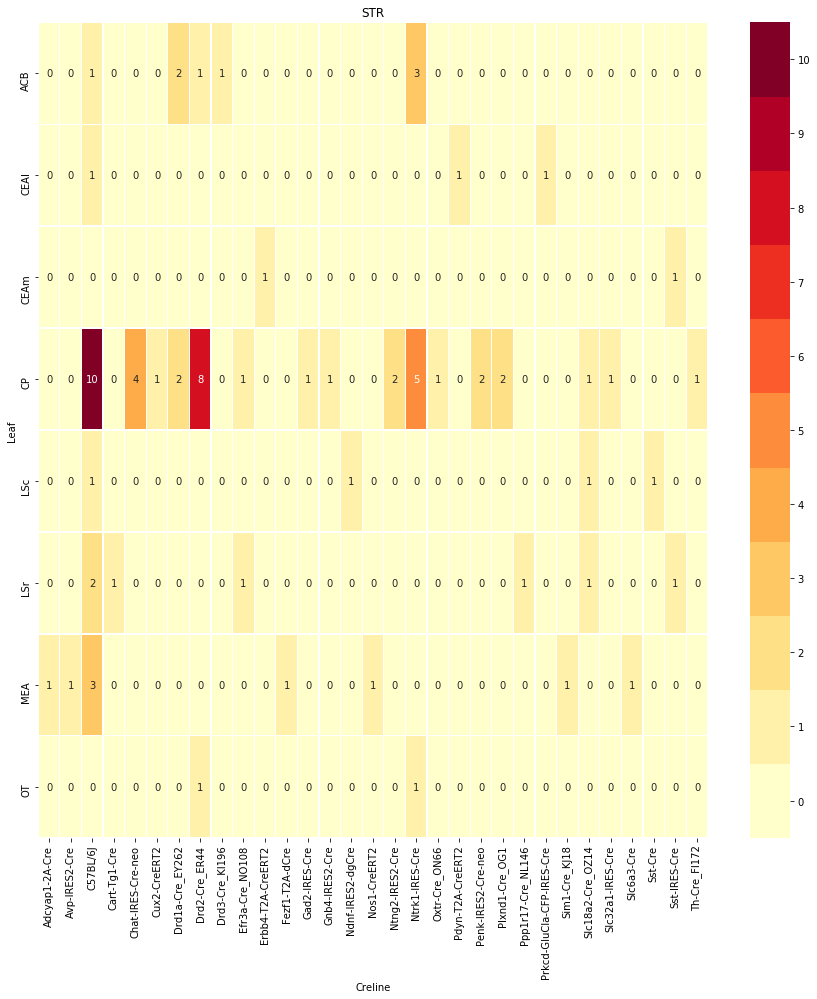

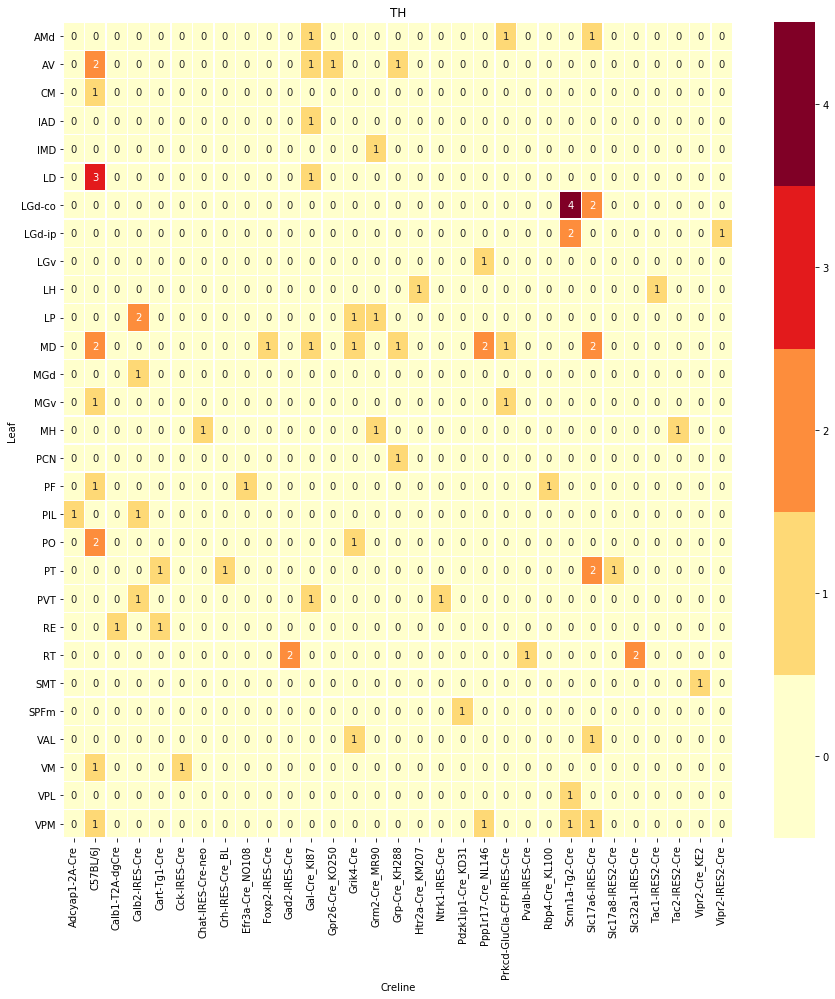

In [16]:
for m in range(len(major_structure_ids)):
#    m = 0 
    #print(m)
    sid = major_structure_ids[m]
    source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
    source_key = source_mask.get_key(structure_ids=ontological_order_leaves)
    source_regions, source_counts = nonzero_unique(source_key, return_counts=True)

#    injs = msvds_leaf[sid].reg_inj_vcount_norm
#    injr = np.reshape(injs, injs.shape[0]*injs.shape[1]) #first injes[0], then injs[1]
    nexp = connectivity_data.structure_datas[sid].reg_inj.shape[0]
#    leaf = np.tile(source_regions, nexp)#np.tile(source_regions, injs.shape[0])
#    cree = np.repeat(creline[sid], injs.shape[1])

#     ls = [ia_map[leaf[i]] for i in range(len(leaf))]
#     crs = cree
#     df = pd.DataFrame(np.asarray([ls, crs, injr]).transpose())
#     df.columns = np.asarray(['leaf', 'creline','inj'])
#     df['inj'] = np.asarray(df['inj'], dtype = float)
#     a = df.pivot_table(values='inj',index='leaf',columns='creline',aggfunc=np.mean)

#     fig, ax = plt.subplots(1,figsize = (50,50))
#     sns.heatmap(a, vmax = .001,ax = ax)
#     plt.title(str(major_structures[m]) + ' injection density')
#     plt.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' injection density')
    
    ls = [ia_map[leafs[sid][i]] for i in range(len(leafs[sid]))]
    crs = connectivity_data.creline[sid]
    df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
    df.columns = np.asarray(['Leaf', 'Creline','present'])
    a = df.pivot_table(values='present',index='Leaf',columns='Creline',aggfunc=np.sum)
    a = a.fillna(0)
    revels = a
    ticks=np.arange(revels.values.min(),revels.values.max()+1 )
    boundaries = np.arange(revels.values.min()-.5,revels.values.max()+1.5 )
    cmap = plt.get_cmap("YlOrRd", revels.values.max()-revels.values.min()+1)
    fig, ax = plt.subplots(figsize = (15,15))
    sns.heatmap(revels, annot=True, linewidths=0.4, cmap=cmap,
            cbar_kws={"ticks":ticks, "boundaries":boundaries}, ax=ax)
    #plt.tight_layout()
    #plt.show()
    #plt.title(major_structures[m])
    #plt.title(major_structures[m])
    ax.set_title(str(major_structures[m]))
    fig.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' centroid densityoct12')
    
#     fig, ax = plt.subplots(1,figsize = (50,50))
#     sns.heatmap(a, ax = ax)
#     plt.title(str(major_structures[m]) + ' centroid density')
#     plt.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' centroid density2')
    
    #plt.xlabel(fontsize = 15)

In [17]:
sid = 315

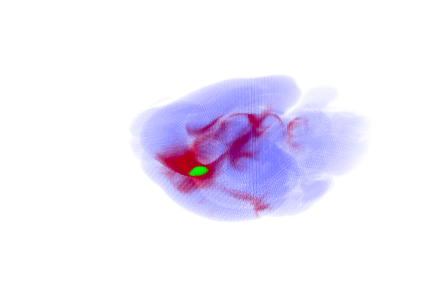

In [18]:
#%matplotlib notebook
#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

nvox = connectivity_data.structure_datas[sid].projections.shape[1]
proj_colors = np.zeros((nvox,4))
proj_colors[:,0] = 1.0
proj_colors[:, 3] = connectivity_data.structure_datas[sid].projections[0] / connectivity_data.structure_datas[sid].projections[0].max()

proj_mask= connectivity_data.structure_datas[sid].projection_mask
ax.scatter(proj_mask.coordinates[:,0], 
           proj_mask.coordinates[:,1], 
           proj_mask.coordinates[:,2], s= .1, c= proj_colors)


ax.scatter(proj_mask.coordinates[:,0], 
           proj_mask.coordinates[:,1], 
           proj_mask.coordinates[:,2], alpha = .01, s = .2, c = 'blue')

nvox = connectivity_data.structure_datas[sid].injections.shape[1]
inj_colors = np.zeros((nvox,4))
inj_colors[:,1] = 1.0
inj_colors[:, 3] = connectivity_data.structure_datas[sid].injections[0] / connectivity_data.structure_datas[sid].injections[0].max()

inj_mask= connectivity_data.structure_datas[sid].injection_mask
ax.scatter(inj_mask.coordinates[:,0], 
           inj_mask.coordinates[:,1], 
           inj_mask.coordinates[:,2], c= inj_colors, s= .5)#, alpha = .9)

# ax.scatter(connectivity_data.structure_datas[sid].centroids[0,0],
#           connectivity_data.structure_datas[sid].centroids[0,1],
#           connectivity_data.structure_datas[sid].centroids[0,2], s =5, c = 'black')
ax.set_axis_off()
plt.savefig(workingdirectory + '/analyses/figures/examplebrain')

In [19]:
#need to make leaf assignments... need reg_inj_vcount_norm to be on the leaf level

In [20]:
leafs[315].shape

(1128,)

In [21]:

nexp = connectivity_data.structure_datas[sid].reg_inj_vcount_norm.shape[0]
for i in range(nexp):
    connectivity_data.structure_datas[sid].reg_inj_vcount_norm[i]

In [22]:
#
reg_proj_norm = connectivity_data.structure_datas[sid].reg_proj_norm.copy()
reg_proj_norm_sorted = np.zeros(reg_proj_norm.shape)
for i in range(nexp):
    reg_proj_norm_i = reg_proj_norm[i]
    reg_proj_norm_i.sort()
    reg_proj_norm_sorted[i] = reg_proj_norm_i
    

In [23]:
#reg_proj_norm_sorted.shape

In [24]:
reg_proj_norm_sorted

array([[0.        , 0.        , 0.        , ..., 0.264876  , 0.37917199,
        0.74473984],
       [0.        , 0.        , 0.        , ..., 0.04652857, 0.14449598,
        0.98746633],
       [0.        , 0.        , 0.        , ..., 0.2481223 , 0.37380656,
        0.85799939],
       ...,
       [0.        , 0.        , 0.        , ..., 0.09712543, 0.15198067,
        0.95986351],
       [0.        , 0.        , 0.        , ..., 0.2607159 , 0.58298836,
        0.67423605],
       [0.        , 0.        , 0.        , ..., 0.37856231, 0.45947273,
        0.70404392]])

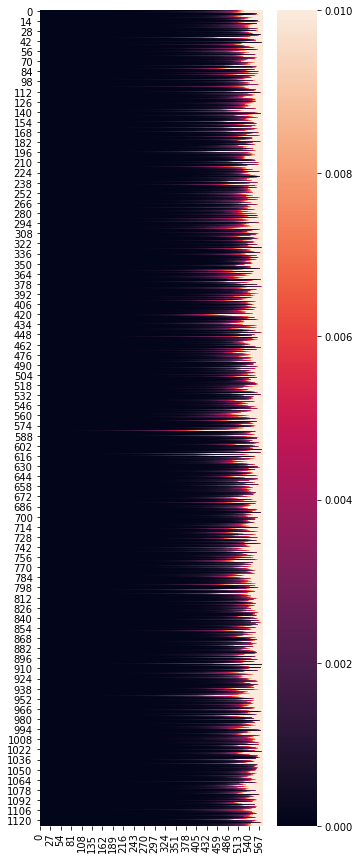

In [25]:
fig, ax = plt.subplots(figsize = (5,15))
#sns.heatmap(np.log(reg_proj_norm_sorted), vmax= 0 )
sns.heatmap(reg_proj_norm_sorted, vmax= 0.01)#pd.DataFrame(reg_proj_norm_sorted))

In [30]:
reg_proj_norm_sorted.shape

(1128, 577)

In [32]:
xpos = np.asarray(np.tile(np.linspace(0, 576,577),reg_proj_norm_sorted.shape[0]), dtype = int)

In [39]:
ypos = np.reshape(reg_proj_norm_sorted, [reg_proj_norm_sorted.shape[0] * reg_proj_norm_sorted.shape[1], 1])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


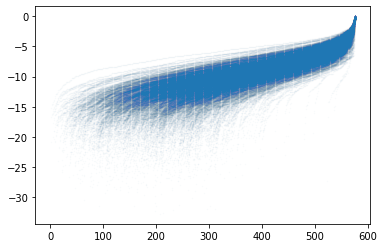

In [46]:
plt.scatter(xpos, np.log(ypos), s= .05, alpha = .05) #boxplots or means colored by region
#plt.yscale('symlog')

In [47]:
def get_regional_centroids(cache,sid,hemisphere_id):
    
    mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=hemisphere_id)
    centroid_loc = np.mean(mask.coordinates, axis = 0)
    
    return(centroid_loc)

In [48]:
connectivity_data.target_hemisphere = np.concatenate([np.ones(291)*2, np.ones(286)])

In [49]:
regional_centroids = np.asarray([get_regional_centroids(cache,connectivity_data.target_regions[i],hemisphere_id = connectivity_data.target_hemisphere[i]) for i in range(577)])

In [50]:
nexp = connectivity_data.structure_datas[sid].centroids.shape[0]
ntarg = connectivity_data.structure_datas[sid].reg_proj_norm.shape[1]
distances = np.zeros((nexp, ntarg))
for i in range(nexp):
    distances[i] = np.linalg.norm(connectivity_data.structure_datas[sid].centroids[i] - regional_centroids, axis = 1)

In [ ]:
distances


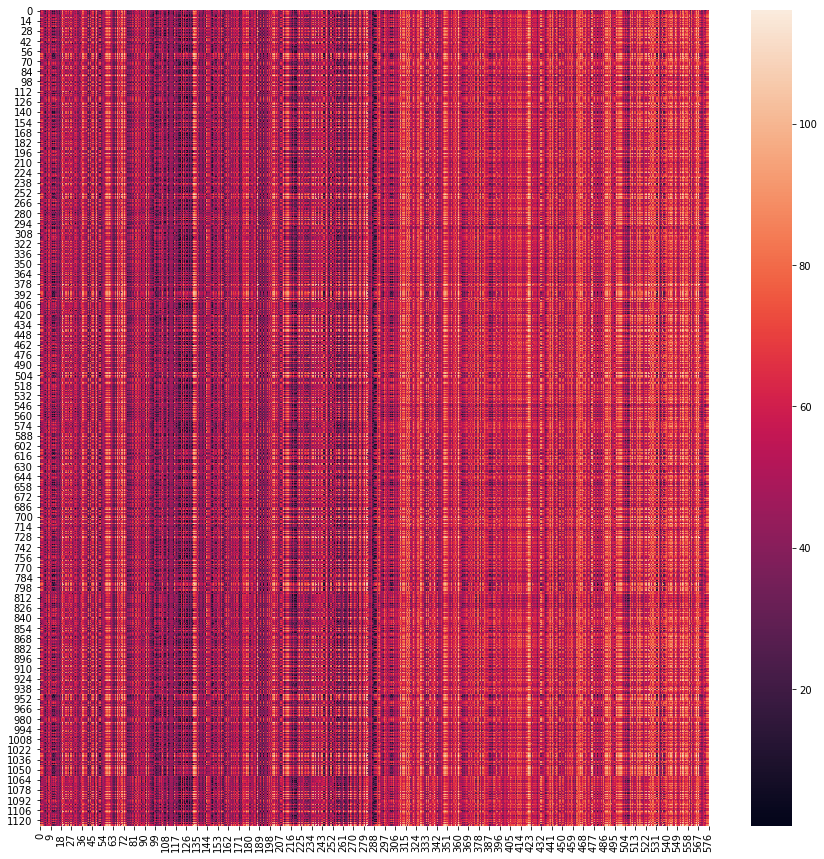

In [51]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(distances)

In [52]:
# fig, ax = plt.subplots(figsize = (5,15))
# plt.scatter(distances, connectivity_data.structure_datas[sid].reg_proj_norm)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


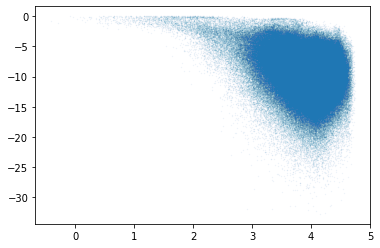

In [53]:
plt.scatter(np.log(distances), np.log(connectivity_data.structure_datas[sid].reg_proj_norm), s= .1, alpha = .1)

In [112]:
ools.shape

(281,)

In [113]:
regional_centroids_sources = np.asarray([get_regional_centroids(cache,ools[i],hemisphere_id = 2) for i in range(len(ools))])
regional_centroids_ipsitargets = np.asarray([get_regional_centroids(cache,ontological_order[i],hemisphere_id = 2) for i in range(len(ontological_order))])

In [114]:
set_2 = frozenset(connectivity_data.contra_target_regions)
intersection = np.asarray([x for x in ontological_order if x in set_2])


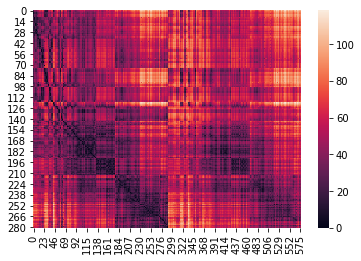

In [115]:

regional_centroids_contratargets = np.asarray([get_regional_centroids(cache,intersection[i],hemisphere_id = 1) for i in range(len(intersection))])
regional_centroids_targets = np.vstack([regional_centroids_ipsitargets,regional_centroids_contratargets])

#nexp = connectivity_data.structure_datas[sid].centroids.shape[0]
ntarg = connectivity_data.structure_datas[sid].reg_proj_norm.shape[1]
nsource = regional_centroids_sources.shape[0]
distances = np.zeros((nsource, ntarg))
for i in range(nsource):
    #print(i)
    for j in range(ntarg):
        distances[i,j] = np.linalg.norm(regional_centroids_sources[i] - regional_centroids_targets[j])
        
sns.heatmap(distances)

In [116]:
wt_conn = pd.read_csv('/Users/samsonkoelle/wt_conn.csv', index_col=0)

In [117]:
cux_conn = pd.read_csv('/Users/samsonkoelle/Cux2_conn.csv', index_col=0)

In [11]:
wt_conn = pd.read_csv('/Users/samsonkoelle/wt_conn.csv', index_col=0)
Cux2_conn = pd.read_csv('/Users/samsonkoelle/Cux2_conn.csv', index_col=0)
Ntsr1_conn =pd.read_csv('/Users/samsonkoelle/Ntsr1_conn.csv', index_col=0)
Rbp4_conn = pd.read_csv('/Users/samsonkoelle/Rbp4_conn.csv', index_col=0)
Tlx3_conn = pd.read_csv('/Users/samsonkoelle/Tlx3_conn.csv', index_col=0)

In [118]:
cux_conn.shape

(281, 577)

In [32]:
connectivity_data.get_leaf_major_dictionary()
connectivity_data.get_major_leaf_dictionary()


In [94]:
#crelist = ['C57BL/6J', 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']##
ool = np.asarray(ontological_order_leaves, dtype = int)
#we were not including leafs with no injection
#they could still not have an injection in a given cre...
#they should still be included?
indis_2 =np.where(np.isin(ool,np.asarray(list(connectivity_data.leaf_major_dictionary.keys()))))[0]
ools = ool[indis_2]


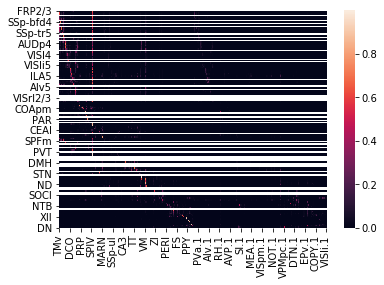

In [12]:
sns.heatmap(wt_conn)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


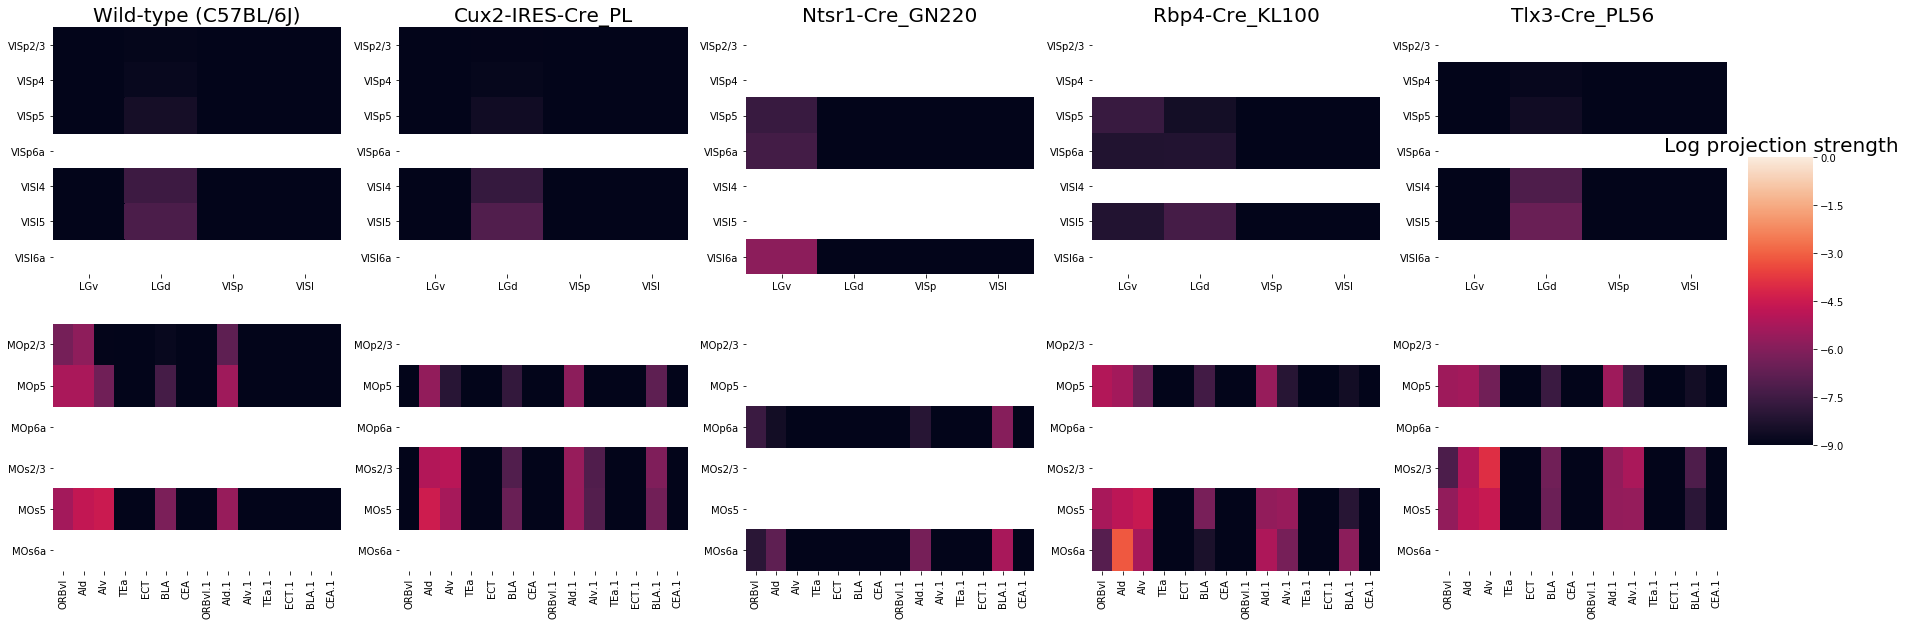

In [18]:
fig, axes = plt.subplots(2,5, figsize = (30,10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

tp = np.log(wt_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,0], cbar = False)

tp = np.log(wt_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,0], cbar = False)

tp = np.log(Cux2_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,1], cbar = False)

tp = np.log(Cux2_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,1], cbar = False)

tp = np.log(Ntsr1_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,2], cbar = False)

tp = np.log(Ntsr1_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,2], cbar = False)

tp = np.log(Rbp4_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,3], cbar = False)

tp = np.log(Rbp4_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,3], cbar = False)

tp = np.log(Tlx3_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,4], cbar = False)

tp = np.log(Tlx3_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,4], cbar = True,cbar_ax= cbar_ax) #cbar_kws={'label': 'Log projection strength'})
cbar_ax.set_title('Log projection strength', fontsize = 20)

axes[0,0].set_title('Wild-type (C57BL/6J)', fontsize = 20)
axes[0,1].set_title('Cux2-IRES-Cre_PL', fontsize = 20)
axes[0,2].set_title('Ntsr1-Cre_GN220', fontsize = 20)
axes[0,3].set_title('Rbp4-Cre_KL100', fontsize = 20)
axes[0,4].set_title('Tlx3-Cre_PL56', fontsize = 20)

axes[1,0].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
axes[1,1].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
axes[1,2].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
axes[1,3].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
axes[1,4].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)

plt.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/visp_mo2')


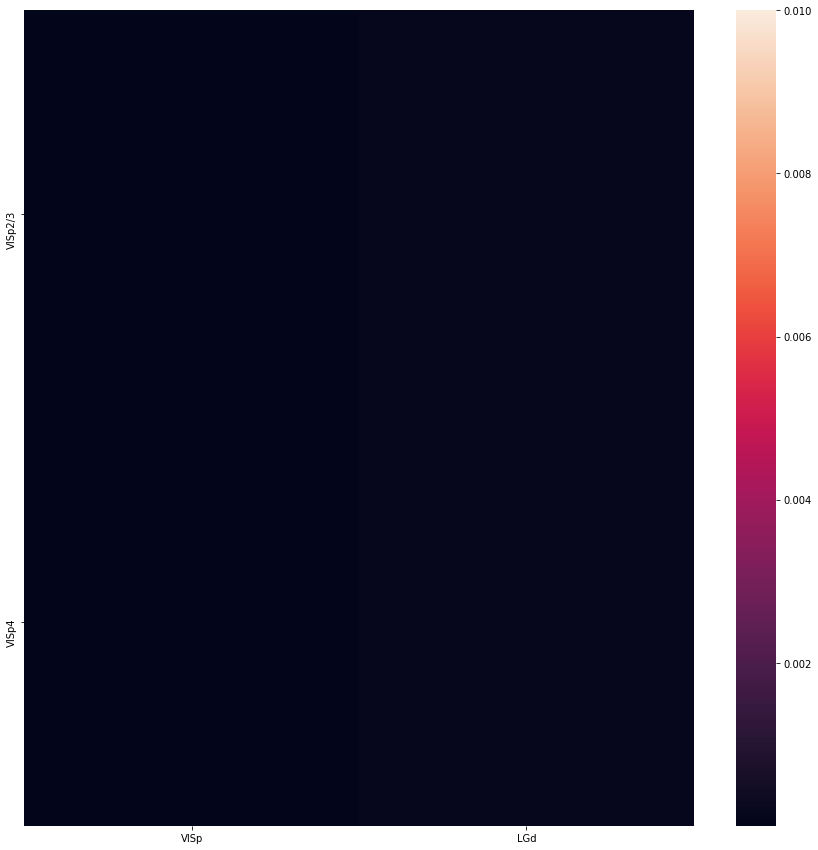

In [27]:
plt.figure(figsize = (15,15))
sns.heatmap(wt_conn.loc[['VISp2/3', 'VISp4'], ['VISp','LGd']], vmax= .01)

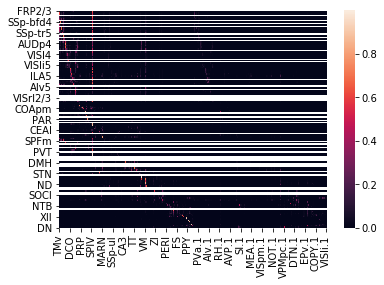

In [19]:
sns.heatmap(wt_conn)

In [273]:
import nimfa

(array([ 226.,  165.,  433.,  836., 1209., 1701., 2064., 2642., 3329.,
        3951., 4596., 4879., 5491., 5882., 6255., 6656., 7159., 7156.,
        7481., 7318., 7523., 7503., 7311., 7202., 6712., 6554., 5930.,
        5271., 4598., 3914., 3456., 2805., 2536., 2210., 1865., 1598.,
        1303., 1171.,  853.,  568.,  467.,  430.,  327.,  215.,  151.,
          98.,   57.,   47.,   24.,    9.]),
 array([  0.        ,   2.36862381,   4.73724763,   7.10587144,
          9.47449525,  11.84311907,  14.21174288,  16.5803667 ,
         18.94899051,  21.31761432,  23.68623814,  26.05486195,
         28.42348576,  30.79210958,  33.16073339,  35.5293572 ,
         37.89798102,  40.26660483,  42.63522865,  45.00385246,
         47.37247627,  49.74110009,  52.1097239 ,  54.47834771,
         56.84697153,  59.21559534,  61.58421915,  63.95284297,
         66.32146678,  68.6900906 ,  71.05871441,  73.42733822,
         75.79596204,  78.16458585,  80.53320966,  82.90183348,
         85.27045729,  8

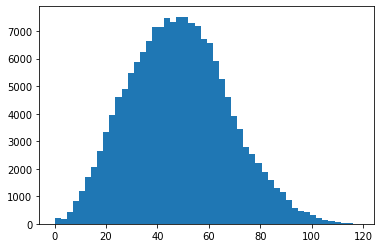

In [300]:
plt.hist(distances.flatten(),bins=50)

In [307]:
wt_conn

TMv        IC       PSV        IF        PT            IG  \
FRP2/3       NaN       NaN       NaN       NaN       NaN           NaN   
FRP5    0.189776  0.128179  0.513660  0.002495  0.000663  1.257840e-04   
FRP6a        NaN       NaN       NaN       NaN       NaN           NaN   
MOp2/3  0.005991  0.578971  0.219822  0.032771  0.010587  3.063143e-02   
MOp5    0.007019  0.597349  0.272277  0.021887  0.020701  6.635648e-02   
...          ...       ...       ...       ...       ...           ...   
PRM     0.000000  0.000152  0.000080  0.000072  0.000043  0.000000e+00   
PFL     0.000013  0.007338  0.002775  0.007707  0.010487  3.404445e-03   
FN      0.000000  0.000512  0.000261  0.000095  0.000166  4.726471e-09   
IP      0.000068  0.001129  0.000371  0.001163  0.001245  7.805668e-05   
DN           NaN       NaN       NaN       NaN       NaN           NaN   

             AAA       IGL           PVa           III  ...      IA.1  \
FRP2/3       NaN       NaN           NaN           NaN  ...       NaN   
FRP5    0.016080  0.005566  6.659672e-05  6.427689e-04  ...  0.000021   
FRP6a        NaN       NaN           NaN           NaN  ...       NaN   
MOp2/3  0.059254  0.302035  1.024595e-04  1.802238e-02  ...  0.000031   
MOp5    0.111273  0.088538  1.292033e-02  1.769790e-02  ...  0.000017   
...          ...       ...           ...           ...  ...       ...   
PRM     0.000134  0.000004  0.000000e+00  5.577093e-06  ...  0.000000   
PFL     0.007828  0.002710  1.540145e-04  2.284307e-04  ...  0.020104   
FN      0.000337  0.000027  3.489020e-08  2.008037e-08  ...  0.000381   
IP      0.002079  0.000244  4.703579e-05  4.342121e-05  ...  0.000117   
DN           NaN       NaN           NaN           NaN  ...       NaN   

         MDRNv.1      PS.1     IAD.1     IAM.1     TMd.1  SSp-un.1  \
FRP2/3       NaN       NaN       NaN       NaN       NaN       NaN   
FRP5    0.000264  0.000836  0.000217  0.000158  0.000753  0.000105   
FRP6a        NaN       NaN       NaN       NaN       NaN       NaN   
MOp2/3  0.000042  0.000124  0.000332  0.000048  0.000213  0.000013   
MOp5    0.000082  0.000091  0.000070  0.000061  0.000089  0.000008   
...          ...       ...       ...       ...       ...       ...   
PRM     0.000021  0.000179  0.004398  0.004770  0.000044  0.000000   
PFL     0.087310  0.107336  0.047995  0.033759  0.031179  0.002905   
FN      0.011068  0.043106  0.030363  0.018532  0.000540  0.000070   
IP      0.000153  0.000517  0.001095  0.002724  0.007961  0.000061   
DN           NaN       NaN       NaN       NaN       NaN       NaN   

              VISa.1   VISli.1      VISpor.1  
FRP2/3           NaN       NaN           NaN  
FRP5    2.393211e-06  0.000002  3.611911e-08  
FRP6a            NaN       NaN           NaN  
MOp2/3  5.919232e-08  0.000009  0.000000e+00  
MOp5    5.178746e-06  0.000025  5.420503e-06  
...              ...       ...           ...  
PRM     0.000000e+00  0.000000  0.000000e+00  
PFL     3.246019e-04  0.001380  1.456759e-04  
FN      5.254120e-02  0.037772  1.690367e-03  
IP      1.998830e-04  0.000115  1.250950e-04  
DN               NaN       NaN           NaN  

[281 rows x 577 columns]

In [309]:
distances[4]

array([22.78785183,  0.96379815, 11.16805147, 20.02416725, 28.02534119,
       21.02877435, 14.13930285, 13.88018215, 28.40496069, 18.4028257 ,
       28.59138072, 25.99663734, 36.35449037, 38.5847059 , 43.59314038,
       46.24629634, 44.1248698 , 43.22096191, 38.14992956, 50.51577334,
       49.54665037, 58.23245614, 44.61991016, 50.91647876, 56.39699505,
       18.18929118, 18.99945357, 21.10204203, 23.32871455, 20.16827776,
       26.10315591, 23.57609711, 20.86445869, 37.31824556, 25.7905679 ,
       42.4433566 , 42.63967328, 40.34572453, 33.58767062, 38.19752678,
       47.6157337 , 50.93993873, 48.32950431, 37.3389429 , 28.45272036,
       32.65047421, 36.34975905, 26.38172058, 40.15976004, 47.91184694,
       50.89464154, 56.57583785, 54.23204564, 58.6432197 , 38.43334517,
       33.14367906, 36.42595433, 38.51784282, 34.98986077, 22.04808109,
       56.56413731, 59.32189019, 56.01450448, 48.77193981, 51.99762025,
       47.12504786, 24.68307972, 34.03681766, 46.60486984, 43.33

In [ ]:
plt.scatter(forkde[:,0], forkde[:,1], s=  .5, alpha = .2)

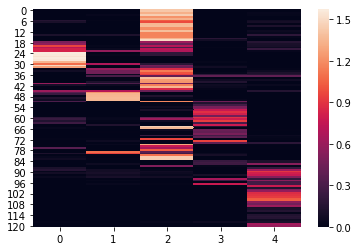

In [274]:
rss= np.linalg.norm(wt_conn, axis = 1)
ids = np.where(~np.isnan(rss))[0]
data = np.asarray(wt_conn)[ids]
lsnmf = nimfa.Lsnmf(data, seed='random_vcol', rank=5, max_iter=100)
lsnmf_fit = lsnmf()
sns.heatmap(lsnmf_fit.basis())

In [295]:
recon = lsnmf_fit.basis() @ lsnmf_fit.coef()

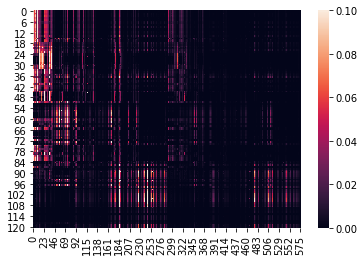

In [297]:
sns.heatmap(recon, vmax = .1)

In [293]:
colnames = np.asarray(wt_conn.columns)
ncomp = lsnmf_fit.coef().shape[0]
for n in range(ncomp):
    print(colnames[np.asarray(np.argsort(-lsnmf_fit.coef()[n]))[0][:5]])

['IO' 'ADP' 'LRN' 'ACB' 'IPN']
['AMB' 'PVpo' 'LA' 'VCO' 'SNc']
['LRN' 'PSV' 'IC' 'LSc.1' 'PVH']
['RH' 'AP' 'RL' 'LSr' 'RPO']
['MOp' 'OP' 'VMH' 'CU' 'PGRNl']


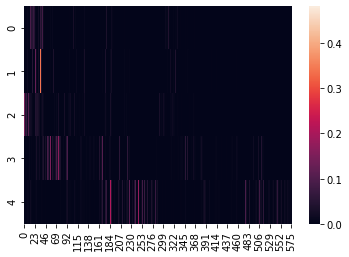

In [275]:
sns.heatmap(lsnmf_fit.coef())

In [265]:
largest = np.argmax(np.asarray(wt_conn), axis = 1)

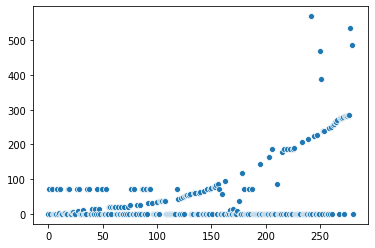

In [272]:
sns.scatterplot(np.asarray(list(range(len(largest))), dtype = float), np.asarray(largest, dtype = float))

In [193]:
mss = np.zeros((distances.shape))
for i in range(mss.shape[0]):    
    mss[i] = np.repeat(ia_map[connectivity_data.leaf_major_dictionary[ools[i]]], mss.shape[1])
mss = np.asarray(mss, dtype = object)
print(mss.flatten().shape)

In [216]:
#sid = 315
forkde = np.asarray([distances.flatten(), np.asarray(wt_conn).flatten()]).transpose()#, #connectivity_data.structure_datas[sid].reg_proj_norm.flatten()]).transpose()
print(forkde.shape)

(162137, 2)


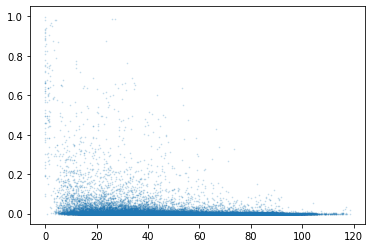

In [206]:
plt.scatter(forkde[:,0], forkde[:,1], s=  .5, alpha = .2)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


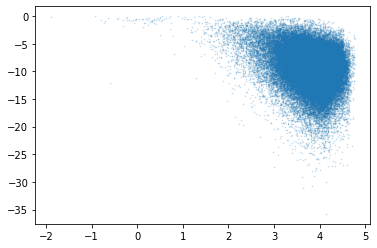

In [207]:
plt.scatter(np.log(np.asarray(forkde[:,0] , dtype = float)), np.log(np.asarray(forkde[:,1] , dtype = float)), s=  .5, alpha = .2)

In [208]:
# print(connectivity_data.structure_datas[sid].reg_proj_norm.flatten().shape)
# distances.flatten().shape

In [209]:
nw = NadarayaWatson(kernel='rbf',  gamma=1.)

In [221]:
mss.flatten().shape

(162137,)

In [229]:

nws = {}
for m in range(12):
    gis = np.intersect1d(np.where(~np.isnan(forkde[:,1]))[0] ,np.where((mss.flatten() == major_structures[m]))[0])
    nws[major_structure_ids[m]] = NadarayaWatson(kernel='rbf',  gamma=1.)
    nws[major_structure_ids[m]].fit(X = np.expand_dims(forkde[:,0],1)[gis], y = forkde[:,1][gis])

In [230]:
xs = np.linspace(0, forkde[:,0].max(), 100)
smoothed = np.zeros((12,100))
for m in range(12):
    for i in range(100):
        smoothed[m,i] = nws[major_structure_ids[m]].predict(np.expand_dims(xs[i:i+1],1))

In [ ]:
#different nw for each structure

In [325]:
#gis = random.sample(list(np.where(~np.isnan(forkde[:,1]))[0]),10000)
gis = np.where(~np.isnan(forkde[:,1]))[0]
nw.fit(X = np.expand_dims(forkde[:,0],1)[gis], y = forkde[:,1][gis])

NadarayaWatson(coef0=1, degree=3, gamma=1.0, kernel='rbf', kernel_params=None)

In [326]:
xs = np.linspace(0, forkde[:,0].max(), 100)
smoothed = np.zeros(100)
for i in range(100):
    smoothed[i] = nw.predict(np.expand_dims(xs[i:i+1],1))

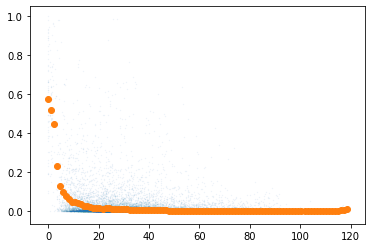

In [327]:
plt.scatter(forkde[:,0], forkde[:,1], s= .1, alpha = .1)
plt.scatter(xs, smoothed)
#plt.scatter(xs, smoothed_lr)

In [328]:
#this is slow... lets try power law
pred_conn = np.zeros((nsource, ntarg))
for i in range(nsource):
    print(i)
    for j in range(ntarg):
        pred_conn[i,j] = nw.predict(np.asarray([distances[i,j]]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [331]:
np.save( '/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/dist_pred_conn.csv',pred_conn)

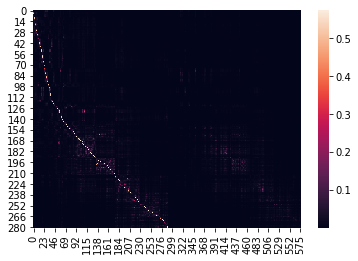

In [812]:
sns.heatmap(pred_conn)

In [629]:
np.log(pred_conn)

array([[-0.71188928, -4.409     , -3.90013783, ..., -7.75389058,
        -7.5874116 , -7.71478734],
       [-0.65993196, -4.37618259, -3.50383406, ..., -7.66368793,
        -7.65414268, -7.67666159],
       [-2.60584809, -3.96066827, -3.10852109, ..., -6.30697274,
        -6.34487212, -6.26306404],
       ...,
       [-7.48792608, -6.76419563, -6.4181069 , ..., -4.16498356,
        -4.76272312, -5.35606468],
       [-7.60413649, -6.52125604, -6.70028222, ..., -4.7610529 ,
        -5.46955397, -5.63029077],
       [-6.26552158, -6.65884761, -6.79961908, ..., -5.3502072 ,
        -5.63146932, -6.38062311]])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


TMv        IC       PSV        IF         PT         IG  \
FRP2/3        NaN       NaN       NaN       NaN        NaN        NaN   
FRP5    -1.661910 -2.054324 -0.666193 -5.993444  -7.318197  -8.980944   
FRP6a         NaN       NaN       NaN       NaN        NaN        NaN   
MOp2/3  -5.117503 -0.546502 -1.514938 -3.418211  -4.548124  -3.485729   
MOp5    -4.959097 -0.515254 -1.300934 -3.821850  -3.877552  -2.712714   
...           ...       ...       ...       ...        ...        ...   
PRM          -inf -8.794702 -9.434964 -9.539908 -10.058895       -inf   
PFL    -11.228664 -4.914731 -5.887075 -4.865642  -4.557593  -5.682673   
FN           -inf -7.577588 -8.249634 -9.261380  -8.705318 -19.170087   
IP      -9.601326 -6.786585 -7.900602 -6.756498  -6.688508  -9.458075   
DN            NaN       NaN       NaN       NaN        NaN        NaN   

             AAA        IGL        PVa        III  ...       IA.1    MDRNv.1  \
FRP2/3       NaN        NaN        NaN        NaN  ...        NaN        NaN   
FRP5   -4.130148  -5.191048  -9.616855  -7.349725  ... -10.776475  -8.239462   
FRP6a        NaN        NaN        NaN        NaN  ...        NaN        NaN   
MOp2/3 -2.825930  -1.197212  -9.186043  -4.016141  ... -10.370687 -10.069258   
MOp5   -2.195771  -2.424318  -4.348953  -4.034309  ... -10.986247  -9.406122   
...          ...        ...        ...        ...  ...        ...        ...   
PRM    -8.914015 -12.368754       -inf -12.096843  ...       -inf -10.780983   
PFL    -4.849985  -5.910808  -8.778464  -8.384278  ...  -3.906838  -2.438288   
FN     -7.995469 -10.503564 -17.171060 -17.723523  ...  -7.871864  -4.503719   
IP     -6.175685  -8.317967  -9.964602 -10.044562  ...  -9.056593  -8.786783   
DN           NaN        NaN        NaN        NaN  ...        NaN        NaN   

            PS.1     IAD.1     IAM.1      TMd.1   SSp-un.1     VISa.1  \
FRP2/3       NaN       NaN       NaN        NaN        NaN        NaN   
FRP5   -7.086525 -8.434145 -8.751546  -7.190798  -9.158225 -12.942875   
FRP6a        NaN       NaN       NaN        NaN        NaN        NaN   
MOp2/3 -8.999096 -8.009227 -9.940518  -8.452113 -11.231671 -16.642474   
MOp5   -9.309805 -9.561110 -9.706727  -9.331653 -11.687447 -12.170948   
...          ...       ...       ...        ...        ...        ...   
PRM    -8.627946 -5.426502 -5.345388 -10.028393       -inf       -inf   
PFL    -2.231794 -3.036665 -3.388506  -3.468021  -5.841221  -8.032911   
FN     -3.144089 -3.494517 -3.988277  -7.524439  -9.572730  -2.946158   
IP     -7.568014 -6.817168 -5.905780  -4.833196  -9.708564  -8.517778   
DN           NaN       NaN       NaN        NaN        NaN        NaN   

          VISli.1   VISpor.1  
FRP2/3        NaN        NaN  
FRP5   -13.389906 -17.136444  
FRP6a         NaN        NaN  
MOp2/3 -11.633258       -inf  
MOp5   -10.579851 -12.125322  
...           ...        ...  
PRM          -inf       -inf  
PFL     -6.585730  -8.834126  
FN      -3.276193  -6.382809  
IP      -9.072610  -8.986437  
DN            NaN        NaN  

[281 rows x 577 columns]

array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [1.89776195e-01, 1.28179395e-01, 5.13660293e-01, ...,
        2.39321114e-06, 1.53051547e-06, 3.61191140e-08],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [0.00000000e+00, 5.11793944e-04, 2.61354115e-04, ...,
        5.25411963e-02, 3.77717949e-02, 1.69036724e-03],
       [6.76390028e-05, 1.12881758e-03, 3.70520265e-04, ...,
        1.99883034e-04, 1.14766565e-04, 1.25094976e-04],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

In [732]:
topsss = connectivity_data.target_regions[np.argsort(-np.mean(np.asarray(wt_conn)[ids], axis = 0))[:5]]
[ia_map[topsss[i]] for i in range(len(topsss))]

['LRN', 'IO', 'PSV', 'IC', 'OP']

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


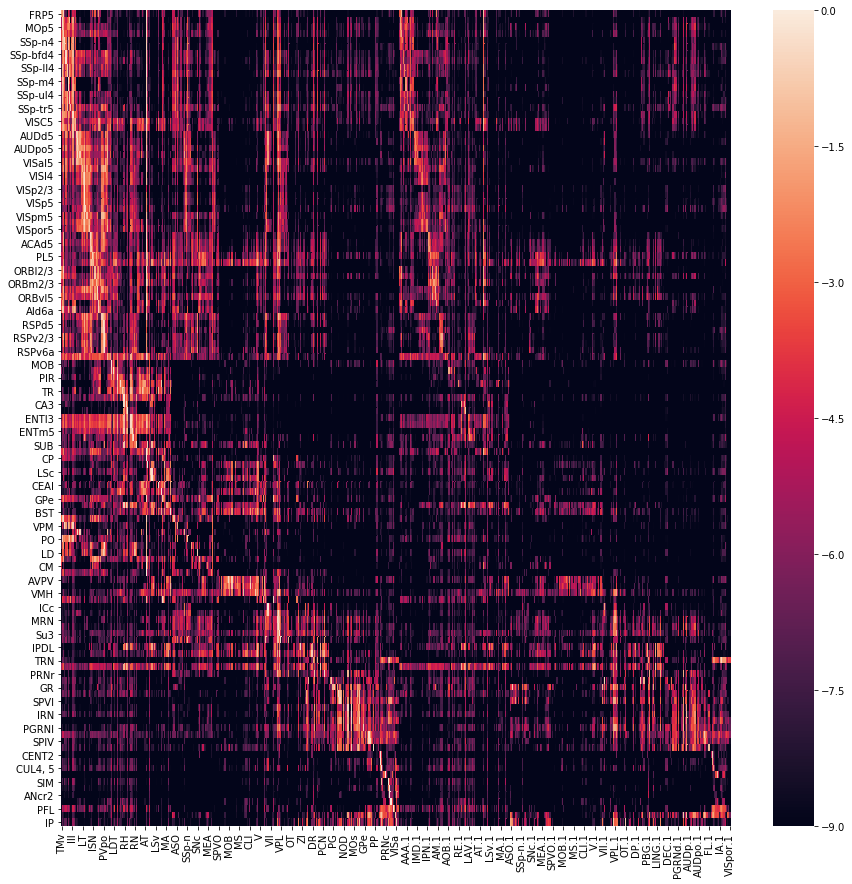

In [768]:
fig, ax = plt.subplots(figsize = (15,15))
tp = np.log(wt_conn)
condat = np.asarray(np.where(tp < -9)).transpose()
for i in range(condat.shape[0]):
    tp.iloc[condat[i,0],condat[i,1]] = -9


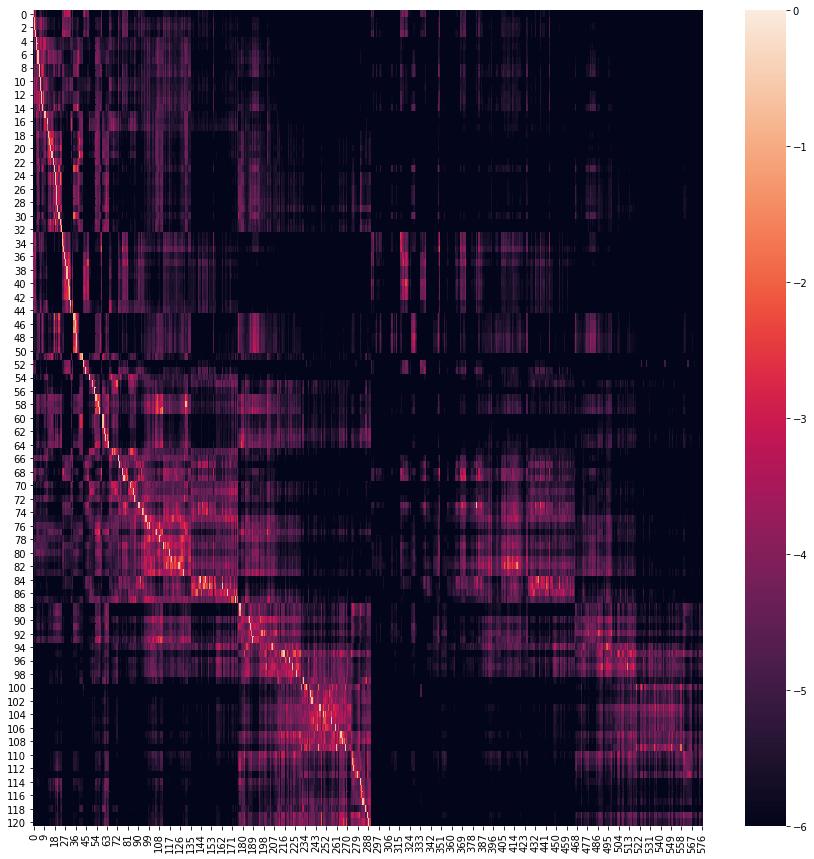

In [822]:
fig, ax = plt.subplots(figsize = (15,15))
tp = np.log(pred_conn)
tp[np.where(tp < -6)] = -6
sns.heatmap(tp[ids], vmax=  0,vmin = -6)

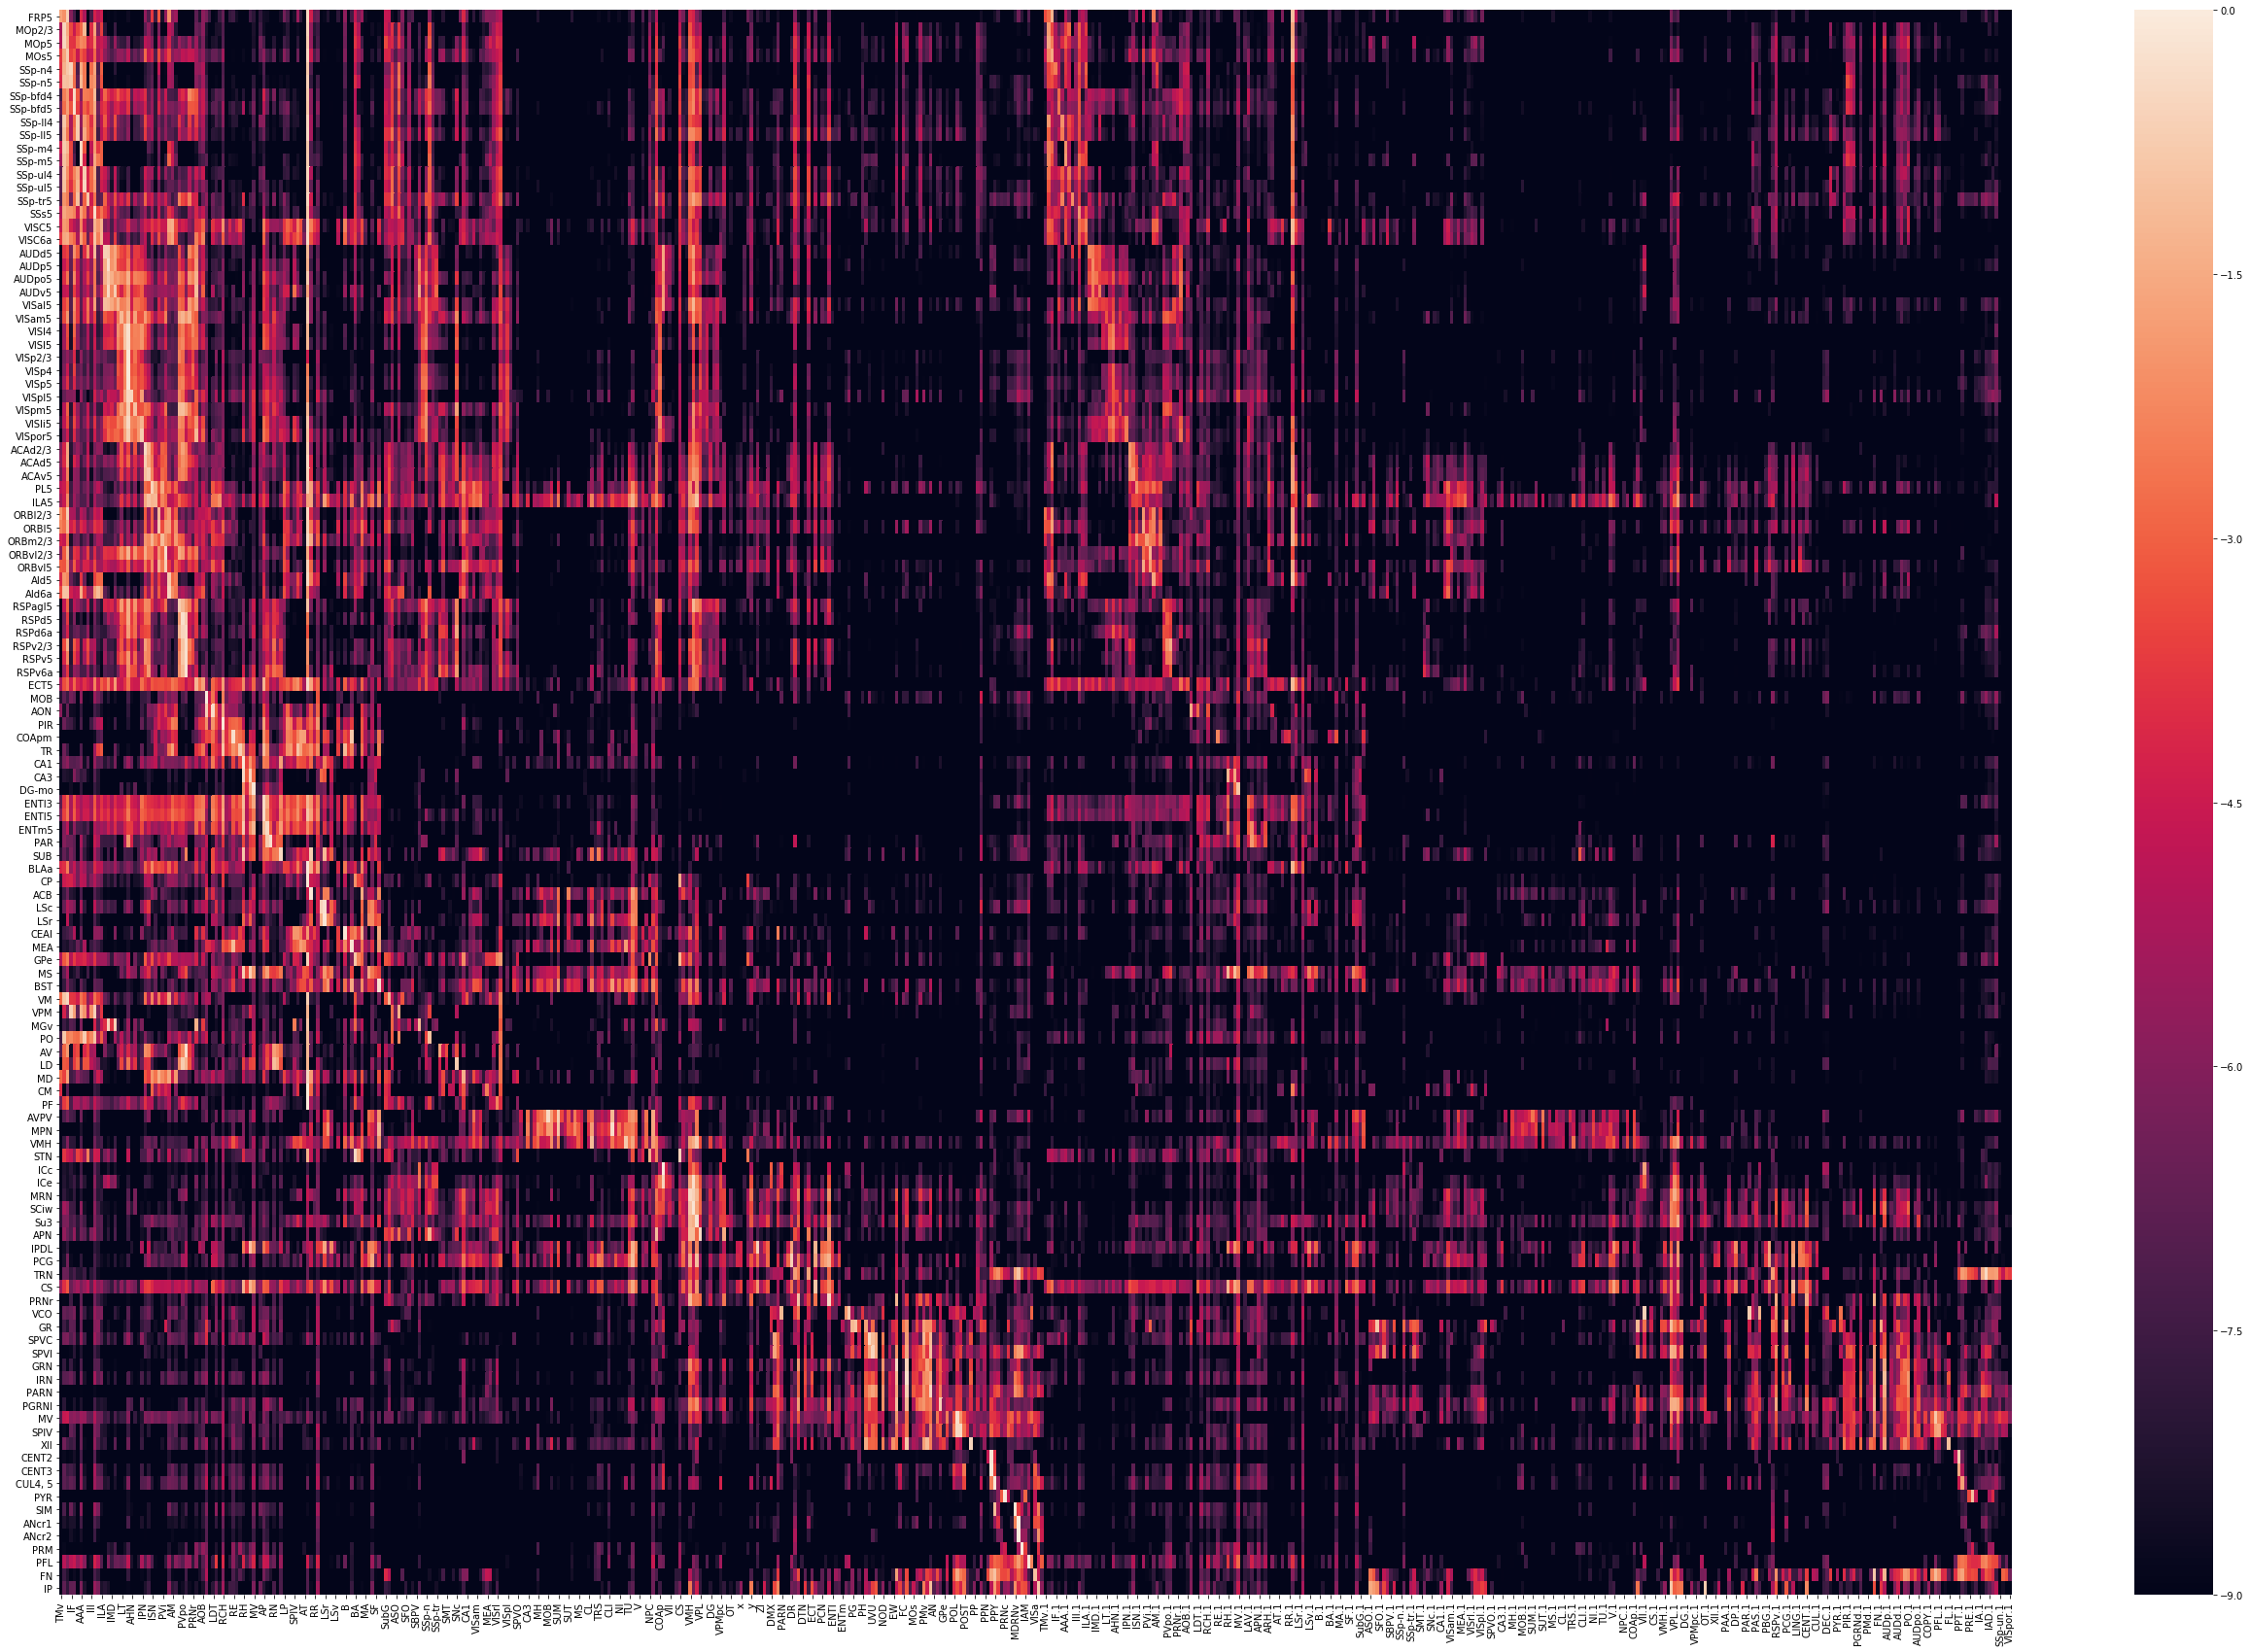

In [784]:
fig, ax = plt.subplots(figsize = (45,30))
sns.heatmap(tp.iloc[ids], vmax=  0,vmin = -9, ax = ax)
#sns.clustermap(tp.iloc[ids], vmax=  0,vmin = -9, ax = axes[1])


In [793]:
output = np.empty(len(ontological_order_leaves[ids]), dtype = object)
for i in range(len(ontological_order_leaves[ids])):
    output[ i] = ia_map[np.intersect1d(st.ancestor_ids([ontological_order_leaves[ids][i]]), major_structure_ids)[0]]
major_ontoloogy = output
major_pal = sns.cubehelix_palette(np.unique(major_ontoloogy).size,
                                    light=.9, dark=.1, reverse=True,
                                    start=1, rot=-2)
major_lut = dict(zip(map(str, np.unique(major_ontoloogy)), major_pal))

major_colors = pd.Series(major_ontoloogy).map(major_lut)

In [803]:
wt_conn.loc['VISp2/3', 'VISp']

7.694228467379253e-07

In [805]:
np.log(wt_conn.loc['VISp4', 'VISp'])

-10.238806410355181

In [799]:
wt_conn.loc

TMv        IC       PSV        IF        PT            IG  \
FRP2/3       NaN       NaN       NaN       NaN       NaN           NaN   
FRP5    0.189776  0.128179  0.513660  0.002495  0.000663  1.257840e-04   
FRP6a        NaN       NaN       NaN       NaN       NaN           NaN   
MOp2/3  0.005991  0.578971  0.219822  0.032771  0.010587  3.063143e-02   
MOp5    0.007019  0.597349  0.272277  0.021887  0.020701  6.635648e-02   
...          ...       ...       ...       ...       ...           ...   
PRM     0.000000  0.000152  0.000080  0.000072  0.000043  0.000000e+00   
PFL     0.000013  0.007338  0.002775  0.007707  0.010487  3.404445e-03   
FN      0.000000  0.000512  0.000261  0.000095  0.000166  4.726471e-09   
IP      0.000068  0.001129  0.000371  0.001163  0.001245  7.805668e-05   
DN           NaN       NaN       NaN       NaN       NaN           NaN   

             AAA       IGL           PVa           III  ...      IA.1  \
FRP2/3       NaN       NaN           NaN           NaN  ...       NaN   
FRP5    0.016080  0.005566  6.659672e-05  6.427689e-04  ...  0.000021   
FRP6a        NaN       NaN           NaN           NaN  ...       NaN   
MOp2/3  0.059254  0.302035  1.024595e-04  1.802238e-02  ...  0.000031   
MOp5    0.111273  0.088538  1.292033e-02  1.769790e-02  ...  0.000017   
...          ...       ...           ...           ...  ...       ...   
PRM     0.000134  0.000004  0.000000e+00  5.577093e-06  ...  0.000000   
PFL     0.007828  0.002710  1.540145e-04  2.284307e-04  ...  0.020104   
FN      0.000337  0.000027  3.489020e-08  2.008037e-08  ...  0.000381   
IP      0.002079  0.000244  4.703579e-05  4.342121e-05  ...  0.000117   
DN           NaN       NaN           NaN           NaN  ...       NaN   

         MDRNv.1      PS.1     IAD.1     IAM.1     TMd.1  SSp-un.1  \
FRP2/3       NaN       NaN       NaN       NaN       NaN       NaN   
FRP5    0.000264  0.000836  0.000217  0.000158  0.000753  0.000105   
FRP6a        NaN       NaN       NaN       NaN       NaN       NaN   
MOp2/3  0.000042  0.000124  0.000332  0.000048  0.000213  0.000013   
MOp5    0.000082  0.000091  0.000070  0.000061  0.000089  0.000008   
...          ...       ...       ...       ...       ...       ...   
PRM     0.000021  0.000179  0.004398  0.004770  0.000044  0.000000   
PFL     0.087310  0.107336  0.047995  0.033759  0.031179  0.002905   
FN      0.011068  0.043106  0.030363  0.018532  0.000540  0.000070   
IP      0.000153  0.000517  0.001095  0.002724  0.007961  0.000061   
DN           NaN       NaN       NaN       NaN       NaN       NaN   

              VISa.1   VISli.1      VISpor.1  
FRP2/3           NaN       NaN           NaN  
FRP5    2.393211e-06  0.000002  3.611911e-08  
FRP6a            NaN       NaN           NaN  
MOp2/3  5.919232e-08  0.000009  0.000000e+00  
MOp5    5.178746e-06  0.000025  5.420503e-06  
...              ...       ...           ...  
PRM     0.000000e+00  0.000000  0.000000e+00  
PFL     3.246019e-04  0.001380  1.456759e-04  
FN      5.254120e-02  0.037772  1.690367e-03  
IP      1.998830e-04  0.000115  1.250950e-04  
DN               NaN       NaN           NaN  

[281 rows x 577 columns]

In [798]:
major_ontoloogy

array(['Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex',
       'Isocortex', 'Isocortex', 'Isocortex', 'Isocortex', 'Isoc

In [797]:
major_lut

{'CTXsp': [0.14250609166695374, 0.06696404307500585, 0.14344253747283972],
 'HPF': [0.27526559971054965, 0.437261336643046, 0.21947114422740344],
 'Isocortex': [0.686041198258586, 0.5780154930925225, 0.8041161727925594],
 'OLF': [0.8955408221495149, 0.9180142943633274, 0.8333641218182573]}

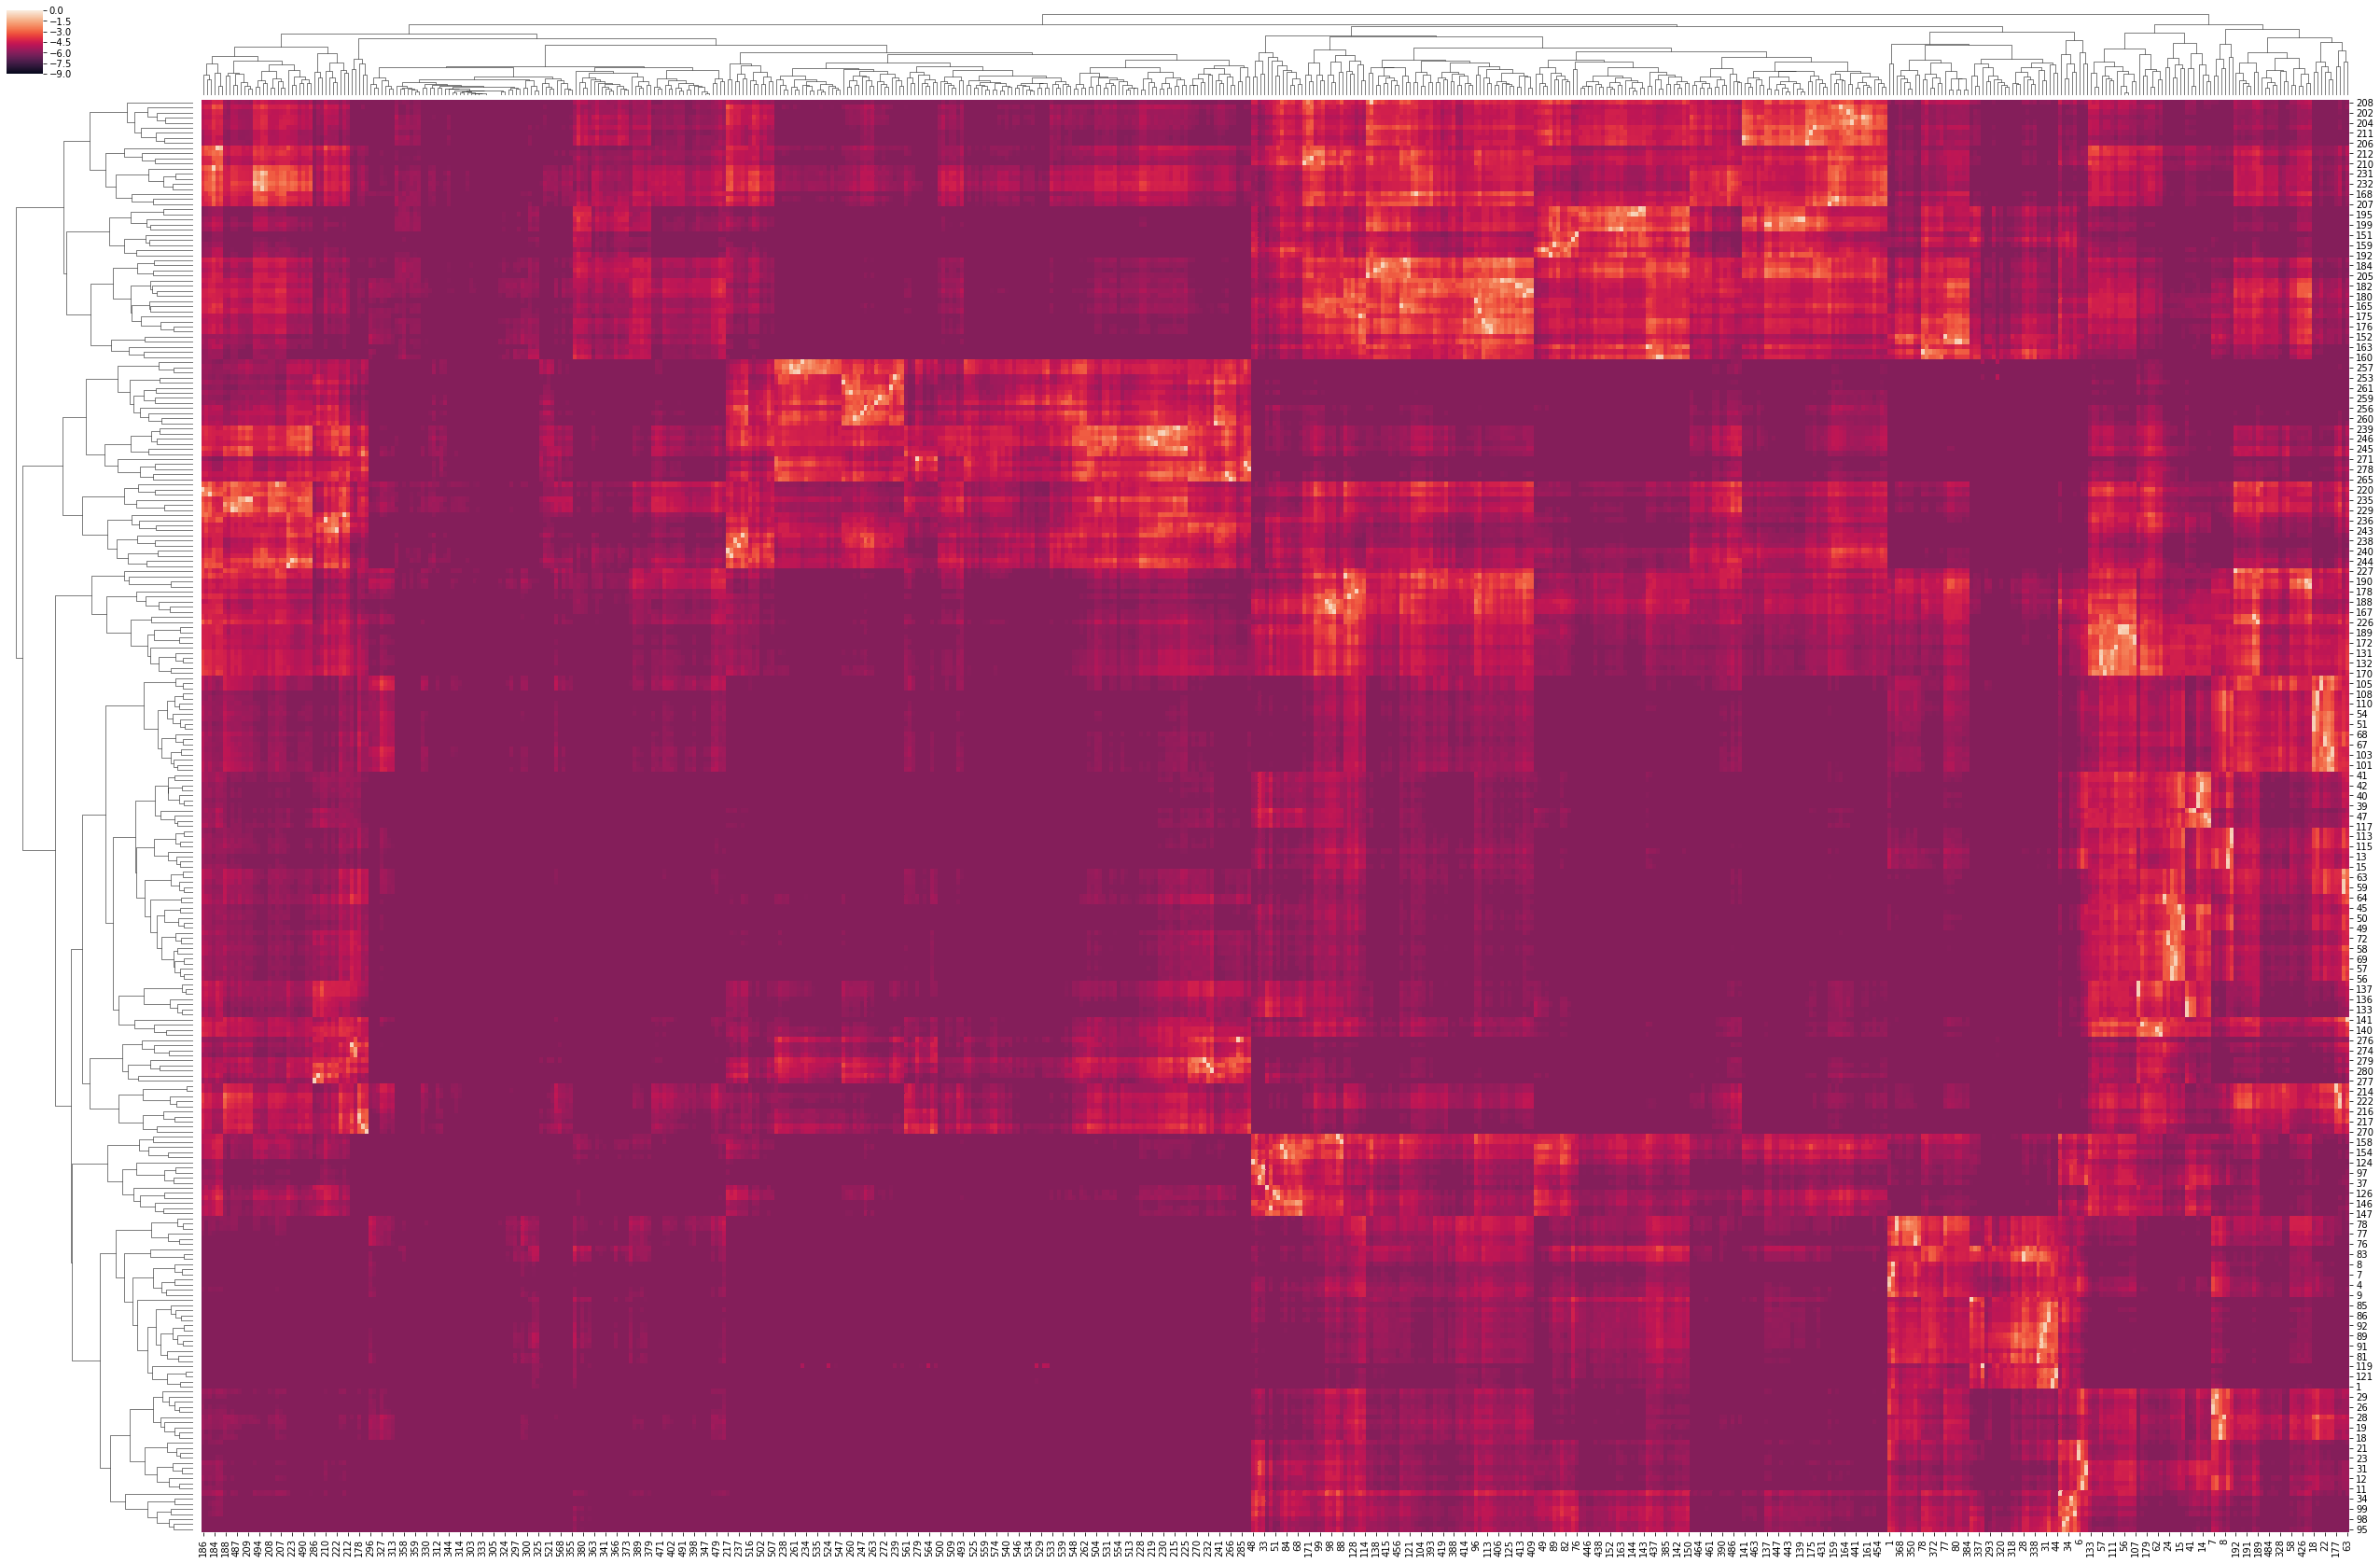

In [824]:
#fig, ax = plt.subplots(figsize = (45,30))
sns.clustermap(tp, vmax=  0,vmin = -9,figsize = (45,30))#,row_colors=major_colors)

In [776]:
axes[1]

In [767]:
281*577

162137

In [764]:
condat[:,0].shape

(39935,)

In [765]:
condat[:,1]

array([  8,  13,  15, ..., 567, 573, 575])

In [760]:
tp

TMv   IC  PSV   IF   PT   IG  AAA  IGL  PVa  III  ...  IA.1  MDRNv.1  \
FRP2/3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN      NaN   
FRP5   -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0  ...  -6.0     -6.0   
FRP6a   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN      NaN   
MOp2/3 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0  ...  -6.0     -6.0   
MOp5   -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0  ...  -6.0     -6.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...      ...   
PRM    -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0  ...  -6.0     -6.0   
PFL    -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0  ...  -6.0     -6.0   
FN     -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0  ...  -6.0     -6.0   
IP     -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0  ...  -6.0     -6.0   
DN      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN      NaN   

        PS.1  IAD.1  IAM.1  TMd.1  SSp-un.1  VISa.1  VISli.1  VISpor.1  
FRP2/3   NaN    NaN    NaN    NaN       NaN     NaN      NaN       NaN  
FRP5    -6.0   -6.0   -6.0   -6.0      -6.0    -6.0     -6.0      -6.0  
FRP6a    NaN    NaN    NaN    NaN       NaN     NaN      NaN       NaN  
MOp2/3  -6.0   -6.0   -6.0   -6.0      -6.0    -6.0     -6.0      -6.0  
MOp5    -6.0   -6.0   -6.0   -6.0      -6.0    -6.0     -6.0      -6.0  
...      ...    ...    ...    ...       ...     ...      ...       ...  
PRM     -6.0   -6.0   -6.0   -6.0      -6.0    -6.0     -6.0      -6.0  
PFL     -6.0   -6.0   -6.0   -6.0      -6.0    -6.0     -6.0      -6.0  
FN      -6.0   -6.0   -6.0   -6.0      -6.0    -6.0     -6.0      -6.0  
IP      -6.0   -6.0   -6.0   -6.0      -6.0    -6.0     -6.0      -6.0  
DN       NaN    NaN    NaN    NaN       NaN     NaN      NaN       NaN  

[281 rows x 577 columns]

In [752]:
np.asarray(np.where(tp < -9)).transpose()[0]

array([1, 8])

In [755]:
tp.iloc[tuple(np.asarray(np.where(tp < -9)).transpose()[0])]

-9.61685517582277

In [744]:
np.asarray(np.where(tp < -9)).transpose()

array([[  1,   8],
       [  1,  13],
       [  1,  15],
       ...,
       [279, 567],
       [279, 573],
       [279, 575]])

In [742]:
np.where(tp < -9)

(array([  1,   1,   1, ..., 279, 279, 279]),
 array([  8,  13,  15, ..., 567, 573, 575]))

In [734]:
tp.iloc[ids]

TMv   IC  PSV   IF   PT   IG  AAA  IGL  PVa  III  ...  IA.1  MDRNv.1  \
FRP5   -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0  ...  -5.0     -5.0   
MOp2/3 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0  ...  -5.0     -5.0   
MOp5   -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0  ...  -5.0     -5.0   
MOs5   -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0  ...  -5.0     -5.0   
SSp-n4 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0  ...  -5.0     -5.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...      ...   
ANcr2  -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0  ...  -5.0     -5.0   
PRM    -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0  ...  -5.0     -5.0   
PFL    -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0  ...  -5.0     -5.0   
FN     -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0  ...  -5.0     -5.0   
IP     -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0 -5.0  ...  -5.0     -5.0   

        PS.1  IAD.1  IAM.1  TMd.1  SSp-un.1  VISa.1  VISli.1  VISpor.1  
FRP5    -5.0   -5.0   -5.0   -5.0      -5.0    -5.0     -5.0      -5.0  
MOp2/3  -5.0   -5.0   -5.0   -5.0      -5.0    -5.0     -5.0      -5.0  
MOp5    -5.0   -5.0   -5.0   -5.0      -5.0    -5.0     -5.0      -5.0  
MOs5    -5.0   -5.0   -5.0   -5.0      -5.0    -5.0     -5.0      -5.0  
SSp-n4  -5.0   -5.0   -5.0   -5.0      -5.0    -5.0     -5.0      -5.0  
...      ...    ...    ...    ...       ...     ...      ...       ...  
ANcr2   -5.0   -5.0   -5.0   -5.0      -5.0    -5.0     -5.0      -5.0  
PRM     -5.0   -5.0   -5.0   -5.0      -5.0    -5.0     -5.0      -5.0  
PFL     -5.0   -5.0   -5.0   -5.0      -5.0    -5.0     -5.0      -5.0  
FN      -5.0   -5.0   -5.0   -5.0      -5.0    -5.0     -5.0      -5.0  
IP      -5.0   -5.0   -5.0   -5.0      -5.0    -5.0     -5.0      -5.0  

[121 rows x 577 columns]

In [ ]:
#visp, visl, lgd, lgv, ipsi, contra
#all cell types
#GNB4 - the seat of consciousness?

In [ ]:
#lrn, number 2, top 5 overall

In [649]:
#np.asarray(wt_conn.index)
#set1 leafs = 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a','VISp6b','LGd-co','LGd-ip','LGv','VISl2/3','VISl4', 'VISl5', 'VISl6a']

array(['FRP2/3', 'FRP5', 'FRP6a', 'MOp2/3', 'MOp5', 'MOp6a', 'MOs1',
       'MOs2/3', 'MOs5', 'MOs6a', 'SSp-n4', 'SSp-n5', 'SSp-n6a',
       'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-ll2/3',
       'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-m2/3', 'SSp-m4', 'SSp-m5',
       'SSp-m6a', 'SSp-ul2/3', 'SSp-ul4', 'SSp-ul5', 'SSp-tr5', 'SSp-un4',
       'SSp-un6a', 'SSs4', 'SSs5', 'SSs6a', 'GU5', 'GU6a', 'VISC5',
       'VISC6a', 'AUDd2/3', 'AUDd4', 'AUDd5', 'AUDd6a', 'AUDp4', 'AUDp5',
       'AUDp6a', 'AUDpo5', 'AUDpo6a', 'AUDv5', 'VISal4', 'VISal5',
       'VISal6a', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISl2/3',
       'VISl4', 'VISl5', 'VISl6a', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a',
       'VISp6b', 'VISpl5', 'VISpl6a', 'VISpm4', 'VISpm5', 'VISpm6a',
       'VISli4', 'VISli5', 'VISli6a', 'VISpor4', 'VISpor5', 'VISpor6a',
       'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAv2/3', 'ACAv5', 'ACAv6a',
       'PL2/3', 'PL5', 'ILA2/3', 'ILA5', 'ORBl1', 'ORBl2/3', 'ORBl5',
       'ORBl6a

In [14]:
#np.asarray(wt_conn.columns)
source_regions = np.asarray(['VISp2/3', 'VISp4', 'VISp5', 'VISp6a','VISl4', 'VISl5', 'VISl6a'])
target_regions = np.asarray(['LGv','LGd','VISp','VISl'])

In [15]:
#(ORBl) and ventral lateral (ORBvl) (AId) and ventral (AIv)  (PTLp), temporal association area (TEa)  area (ECT),  MOp neurons project to none of these areas (Table 1 and Supplementary Movie S1). L5 MOs neurons also project bilaterally to amygdala nuclei, specifically the anterior basolateral amygdala (BLAa) and capsular central amygdala (CEAc)

In [16]:
#MOv, MOs, MOp

targ_reg = np.asarray(['ORBv1','AId','AIv','PTLp','TEa','ECT','BLAa','CEA', 'ORBvl.1','AId.1','AIv.1','PTLp.1','TEa.1','ECT.1','BLAa.1','CEA.1' ])
source_reg = np.asarray(['MOp2/3', 'MOp5', 'MOp6a','MOs2/3', 'MOs5', 'MOs6a' ])


In [17]:
targ_reg = np.asarray(['ORBvl','AId','AIv','TEa','ECT','BLA','CEA', 'ORBvl.1','AId.1','AIv.1','TEa.1','ECT.1','BLA.1','CEA.1' ])

In [705]:
# #wt_conn.loc[source_reg]
# print(targ_reg)
# np.intersect1d(targ_reg, wt_conn.columns)

In [806]:
# wt_conn = pd.read_csv('/Users/samsonkoelle/wt_conn.csv', index_col=0)
# Cux2_conn = pd.read_csv('/Users/samsonkoelle/Cux2_conn.csv', index_col=0)
# Ntsr1_conn =pd.read_csv('/Users/samsonkoelle/Ntsr1_conn.csv', index_col=0)
# Rbp4_conn = pd.read_csv('/Users/samsonkoelle/Rbp4_conn.csv', index_col=0)
# Tlx3_conn = pd.read_csv('/Users/samsonkoelle/Tlx3_conn.csv', index_col=0)

In [35]:
    def get_summarystructure_major_dictionary(self):
        connectivity_data = self
        structure_major_dictionary = {}
        keys = np.asarray(list(connectivity_data.structure_datas))
        for sid in keys:
            strs_sid = np.unique(connectivity_data.structure_datas[sid].summary_structures)
            nstrs = len(strs_sid)
            for s in range(nstrs):
                structure_major_dictionary[strs_sid[s]] = sid
        self.structure_major_dictionary = structure_major_dictionary
        #return (structure_major_dictionary)


    def get_major_summarystructure_dictionary(self):
        connectivity_data = self
        major_structure_dictionary = {}
        keys = np.asarray(list(connectivity_data.structure_datas))
        for sid in keys:
            strs_sid = np.unique(connectivity_data.structure_datas[sid].summary_structures)
            major_structure_dictionary[sid] = np.asarray(strs_sid, dtype=int)
        self.major_summarystructure_dictionary = major_structure_dictionary
        #return (major_structure_dictionary)
connectivity_data  = get_summarystructure_major_dictionary(connectivity_data)
connectivity_data = get_major_summarystructure_dictionary(connectivity_data)

AttributeError: 'NoneType' object has no attribute 'structure_datas'

In [ ]:
crelist = ['C57BL/6J', 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']##
ool = np.asarray(ontological_order_leaves, dtype = int)
ool_name = np.asarray([ia_map[ool[i]] for i in range(len(ool))])
indis = np.where(np.asarray([np.isin(ool_name[i][:4] ,np.asarray(['VISp', 'VISl'])) for i in range(len(ool))]))[0]
indis_2 =np.where(np.isin(ool[indis],np.asarray(list(connectivity_data.leaf_major_dictionary.keys()))))[0]
ool_vispl = ool[indis[indis_2]]
nmnmn = np.asarray([ia_map[connectivity_data.leafs[315][i]] for i in range(connectivity_data.leafs[315].shape[0])])
#nmnmn = np.asarray([ia_map[connectivity_data.structure_datas[315].leafs[i]] for i in range(connectivity_data.structure_datas[315].leafs.shape[0])])
tergs = np.concatenate([connectivity_data.major_summarystructure_dictionary[315],connectivity_data.major_summarystructure_dictionary[549]])
targ_subset_id = np.where(np.isin(ontological_order,tergs))[0]

In [30]:
targ_subset_id

NameError: name 'targ_subset_id' is not defined

In [29]:
targ_subset_id

np.asarray([ia_map[ontological_order[targ_subset_id[i]]] for i in range(len(targ_subset_id))])

ontological_order.shape

(291,)

In [ ]:
wt_conn = pd.read_csv('/Users/samsonkoelle/Downloads/connectivity_cre_shared/wt_conn.csv', index_col=0)
Cux2_conn = pd.read_csv('/Users/samsonkoelle/Cux2_conn.csv', index_col=0)
Ntsr1_conn =pd.read_csv('/Users/samsonkoelle/Ntsr1_conn.csv', index_col=0)
Rbp4_conn = pd.read_csv('/Users/samsonkoelle/Rbp4_conn.csv', index_col=0)
Tlx3_conn = pd.read_csv('/Users/samsonkoelle/Tlx3_conn.csv', index_col=0)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


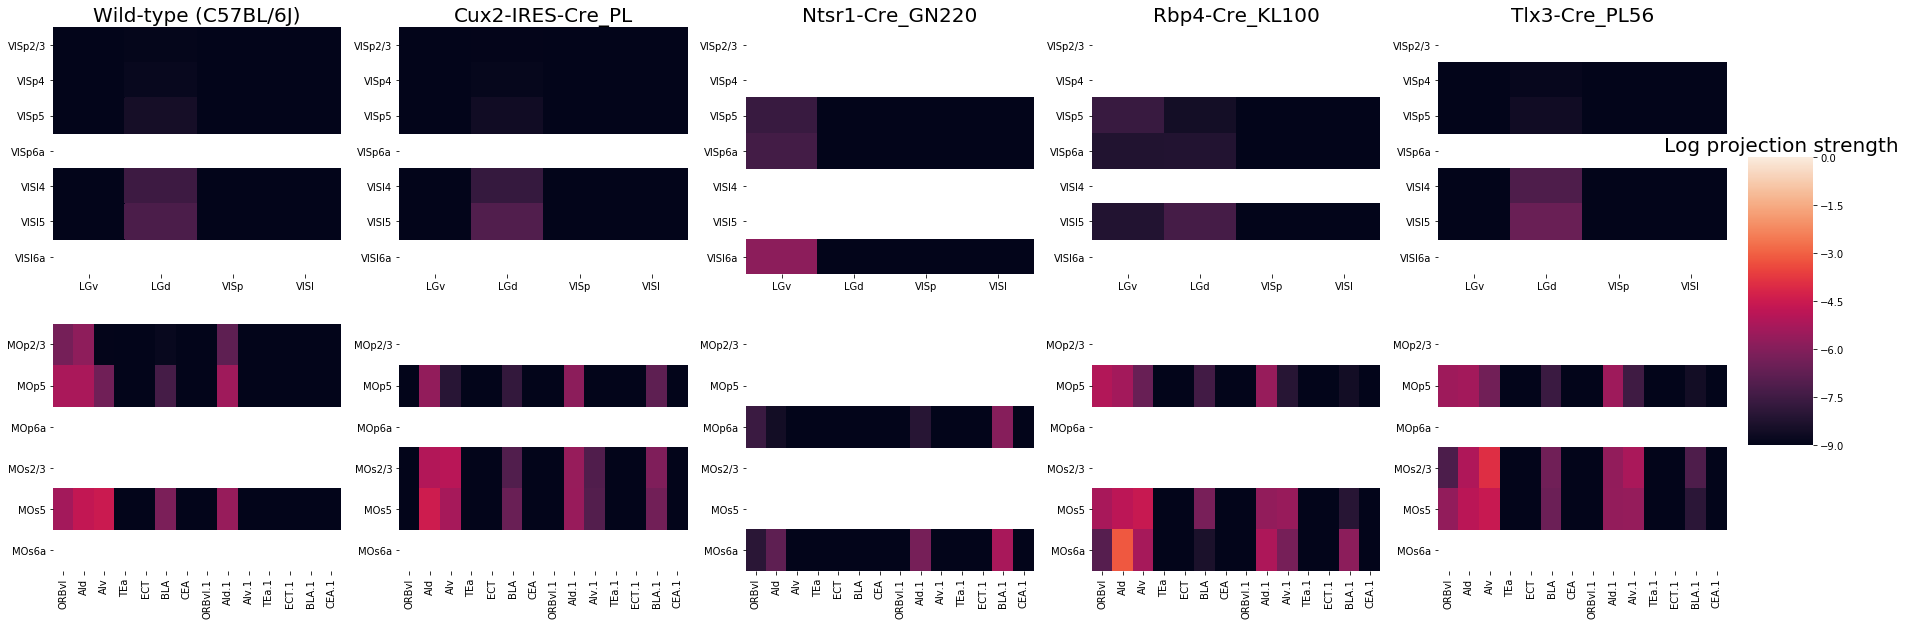

In [807]:
fig, axes = plt.subplots(2,5, figsize = (30,10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

tp = np.log(wt_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,0], cbar = False)

tp = np.log(wt_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,0], cbar = False)

tp = np.log(Cux2_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,1], cbar = False)

tp = np.log(Cux2_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,1], cbar = False)

tp = np.log(Ntsr1_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,2], cbar = False)

tp = np.log(Ntsr1_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,2], cbar = False)

tp = np.log(Rbp4_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,3], cbar = False)

tp = np.log(Rbp4_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,3], cbar = False)

tp = np.log(Tlx3_conn.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0,4], cbar = False)

tp = np.log(Tlx3_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,4], cbar = True,cbar_ax= cbar_ax) #cbar_kws={'label': 'Log projection strength'})
cbar_ax.set_title('Log projection strength', fontsize = 20)

axes[0,0].set_title('Wild-type (C57BL/6J)', fontsize = 20)
axes[0,1].set_title('Cux2-IRES-Cre_PL', fontsize = 20)
axes[0,2].set_title('Ntsr1-Cre_GN220', fontsize = 20)
axes[0,3].set_title('Rbp4-Cre_KL100', fontsize = 20)
axes[0,4].set_title('Tlx3-Cre_PL56', fontsize = 20)

axes[1,0].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
axes[1,1].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
axes[1,2].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
axes[1,3].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)
axes[1,4].set_yticklabels(axes[1,0].get_yticklabels(), rotation=0)

plt.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/visp_mo')


In [721]:
help(fig.colorbar)

Help on method colorbar in module matplotlib.figure:

colorbar(mappable, cax=None, ax=None, use_gridspec=True, **kw) method of matplotlib.figure.Figure instance
    Create a colorbar for a ScalarMappable instance, *mappable*.
    
    Documentation for the pyplot thin wrapper:
    
    
    Add a colorbar to a plot.
    
    Function signatures for the :mod:`~matplotlib.pyplot` interface; all
    but the first are also method signatures for the
    :meth:`~matplotlib.figure.Figure.colorbar` method::
    
      colorbar(**kwargs)
      colorbar(mappable, **kwargs)
      colorbar(mappable, cax=cax, **kwargs)
      colorbar(mappable, ax=ax, **kwargs)
    
    Parameters
    ----------
    mappable
        The `matplotlib.cm.ScalarMappable` (i.e., `~matplotlib.image.Image`,
        `~matplotlib.contour.ContourSet`, etc.) described by this colorbar.
        This argument is mandatory for the `.Figure.colorbar` method but optional
        for the `.pyplot.colorbar` function, which sets the d

In [714]:
axes[0,0].get_colorbar()

AttributeError: 'AxesSubplot' object has no attribute 'get_colorbar'

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


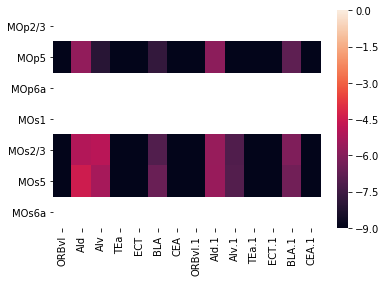

In [683]:
# tp = np.log(wt_conn.loc[source_reg].loc[:,targ_reg])
# tp.iloc[np.where(tp < -9)] = -9
# sns.heatmap(tp, vmin = -9, vmax= 0.)

tp = np.log(cux_conn.loc[source_reg].loc[:,targ_reg])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0.)

In [654]:
major_structure_ids[1]

703

In [655]:
connectivity_data.major_leaf_dictionary[703]

array([131, 303, 311, 583, 780])

In [814]:
# fig, ax = plt.subplots(figsize = (15,15))
# tp = np.log(wt_conn)
# tp[np.where(tp < -5)] = -5
# sns.heatmap(tp[ids], vmax=  0,vmin = -5)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


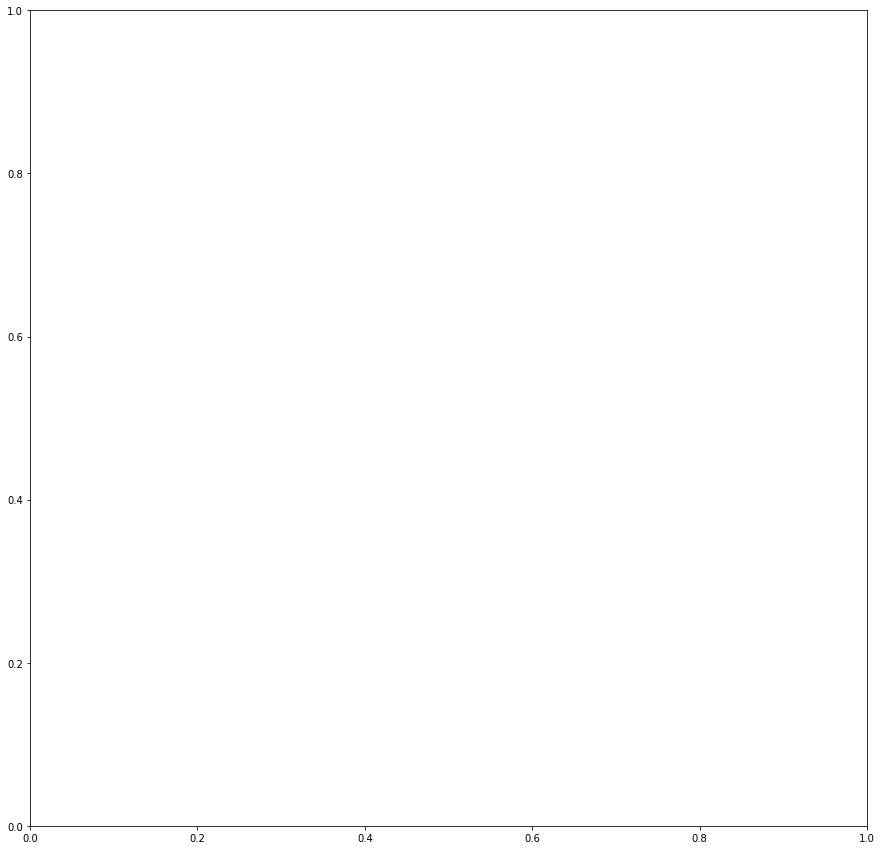

In [818]:
fig, ax = plt.subplots(figsize = (15,15))
tp = np.log(wt_conn)
condat = np.asarray(np.where(tp < -9)).transpose()
for i in range(condat.shape[0]):
    tp.iloc[condat[i,0],condat[i,1]] = -9


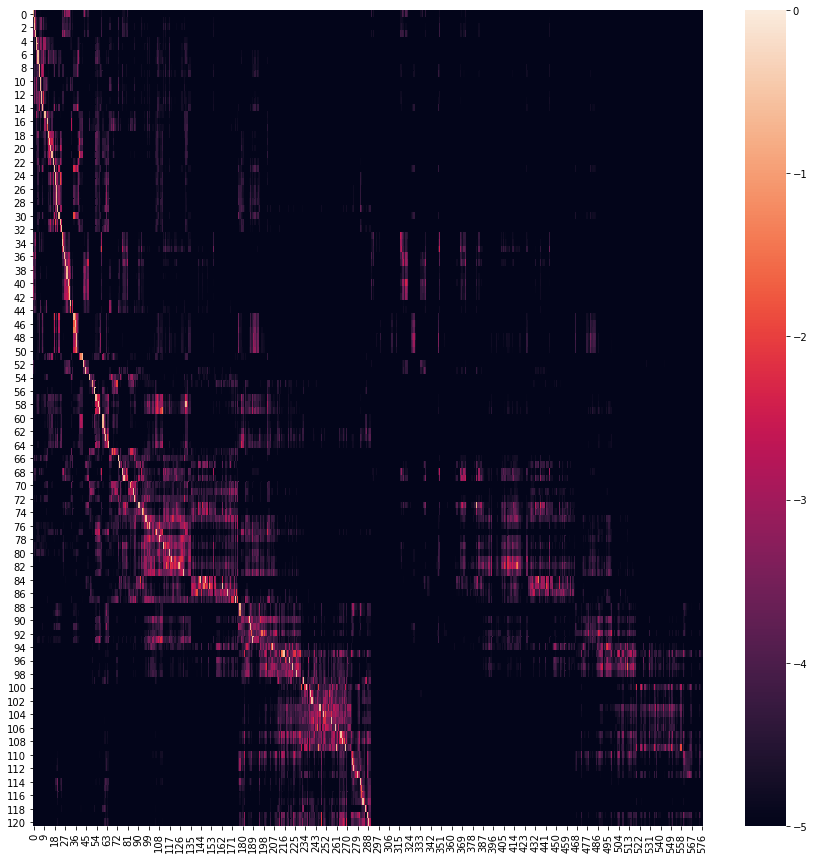

In [817]:
fig, ax = plt.subplots(figsize = (15,15))
tp = np.log(pred_conn)
tp[np.where(tp < -5)] = -5
sns.heatmap(tp[ids], vmax=  0,vmin = -5)

In [631]:
tp

array([[-0.71188928, -4.409     , -3.90013783, ..., -5.        ,
        -5.        , -5.        ],
       [-0.65993196, -4.37618259, -3.50383406, ..., -5.        ,
        -5.        , -5.        ],
       [-2.60584809, -3.96066827, -3.10852109, ..., -5.        ,
        -5.        , -5.        ],
       ...,
       [-5.        , -5.        , -5.        , ..., -4.16498356,
        -4.76272312, -5.        ],
       [-5.        , -5.        , -5.        , ..., -4.7610529 ,
        -5.        , -5.        ],
       [-5.        , -5.        , -5.        , ..., -5.        ,
        -5.        , -5.        ]])

In [626]:
pred_conn

array([[4.90716223e-01, 1.21673396e-02, 2.02391216e-02, ...,
        4.29069959e-04, 5.06791138e-04, 4.46180341e-04],
       [5.16886504e-01, 1.25732645e-02, 3.00818264e-02, ...,
        4.69572462e-04, 4.74076109e-04, 4.63519739e-04],
       [7.38404871e-02, 1.90503793e-02, 4.46669649e-02, ...,
        1.82354523e-03, 1.75572725e-03, 1.90539862e-03],
       ...,
       [5.59802742e-04, 1.15437566e-03, 1.63174236e-03, ...,
        1.55299702e-02, 8.54231593e-03, 4.71944211e-03],
       [4.98385595e-04, 1.47181928e-03, 1.23056456e-03, ...,
        8.55659543e-03, 4.21311089e-03, 3.58753204e-03],
       [1.90072179e-03, 1.28262360e-03, 1.11419949e-03, ...,
        4.74716728e-03, 3.58330644e-03, 1.69406703e-03]])

In [335]:
dist_err = wt_conn - pred_conn

In [366]:
dist_err.iloc[:,73]

FRP2/3         NaN
FRP5      0.646390
FRP6a          NaN
MOp2/3    0.573017
MOp5      0.497246
            ...   
PRM      -0.001192
PFL       0.010255
FN       -0.000510
IP       -0.000629
DN             NaN
Name: LRN, Length: 281, dtype: float64

In [451]:
from sklearn.decomposition import NMF

In [611]:

#nmf_sk = NMF(n_components=10, alpha=0., l1_ratio=0.)

In [612]:
nmf_sk = NMF(n_components=10, alpha=0.1, l1_ratio=.5)
nmf_sk.fit(np.asarray(wt_conn)[ids])

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
    n_components=10, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [614]:
tnmf_sk = nmf_sk.transform(np.asarray(wt_conn)[ids])
itnmf_sk = nmf_sk.inverse_transform(tnmf_sk)

In [615]:
nmf_sk.reconstruction_err_

7.092324373767407

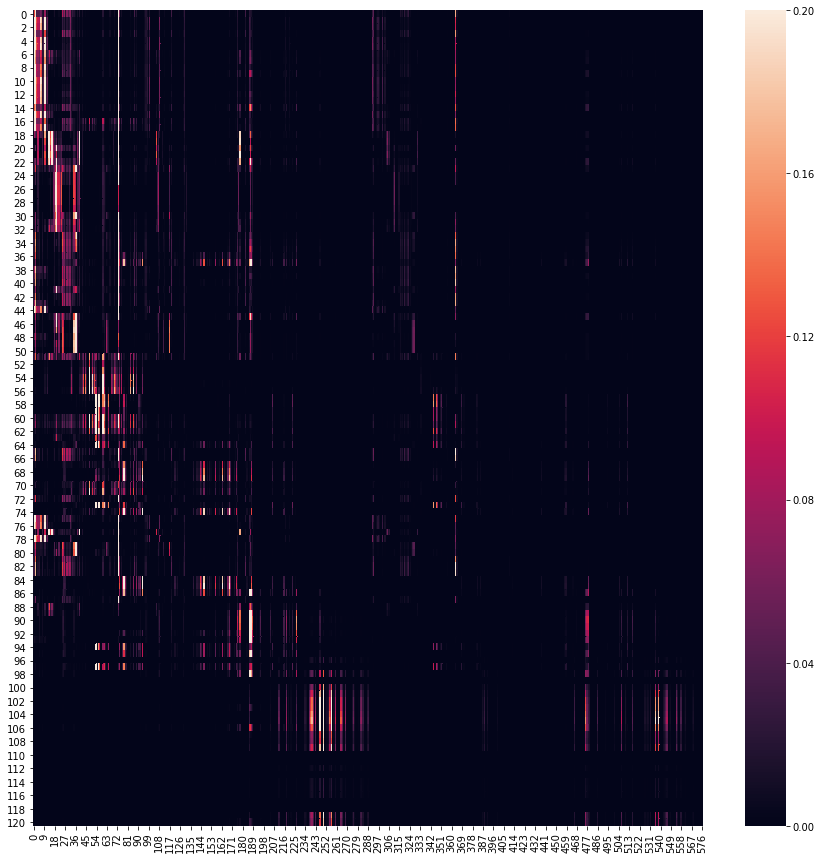

In [618]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(itnmf_sk, vmax=  .2, vmin = 0.)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


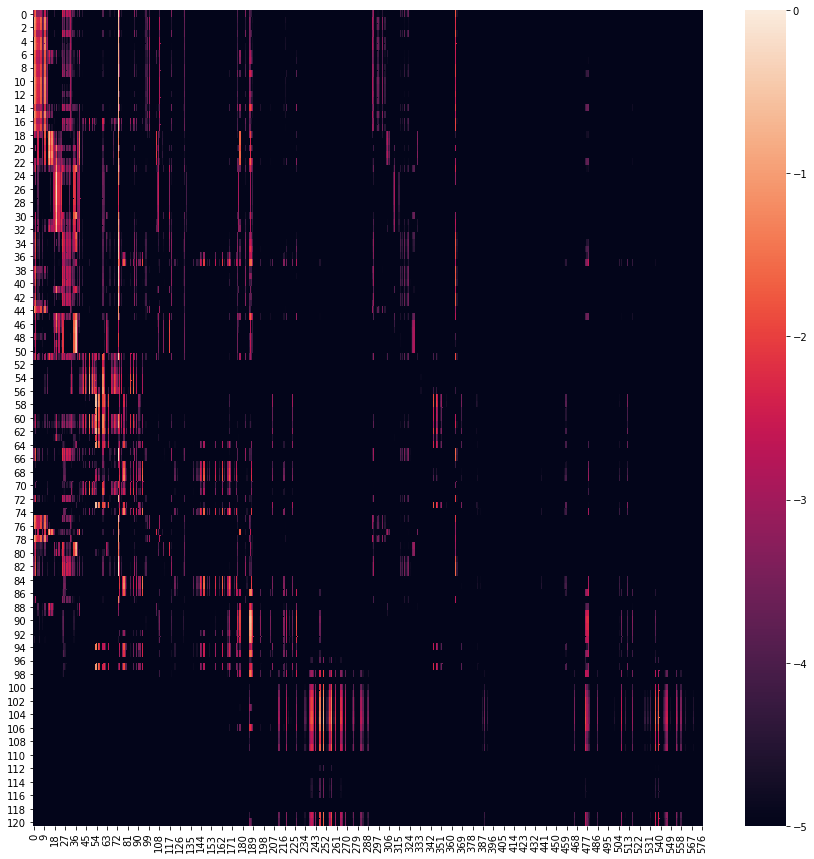

In [624]:
fig, ax = plt.subplots(figsize = (15,15))
tp = np.log(itnmf_sk)
tp[np.where(np.isinf(tp))] = -5
sns.heatmap(tp, vmin  = -5, vmax = 0)

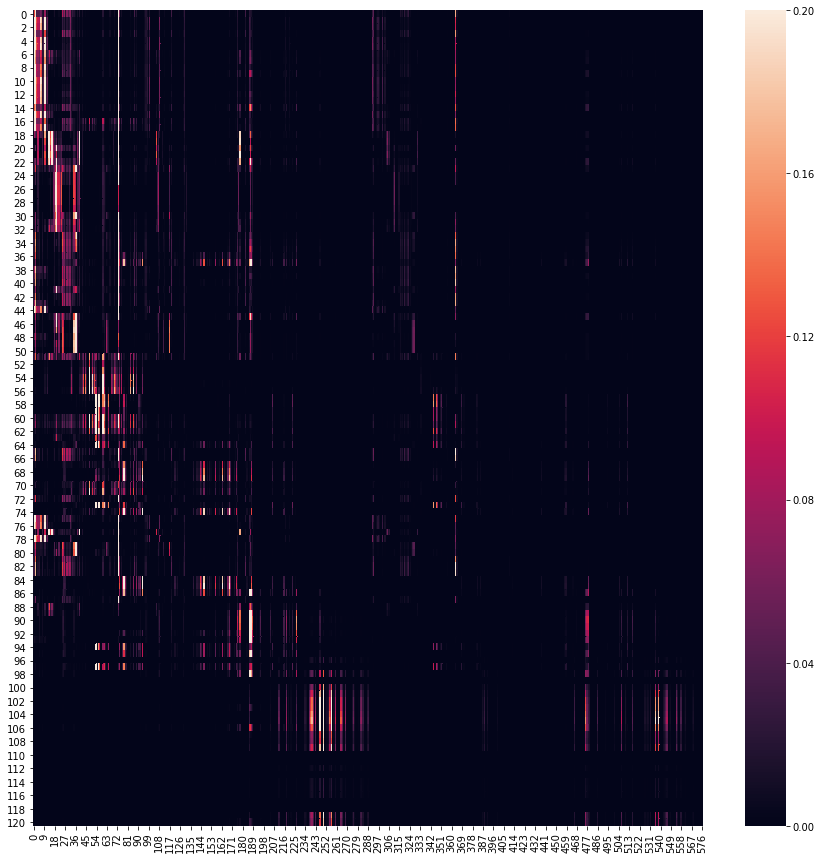

In [616]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(itnmf_sk, vmax=  .2, vmin = 0.)

In [617]:
np.sum((nmf_sk.components_ > 0) ,axis = 1)

array([85, 39, 55, 44, 33, 83, 46, 35, 44, 65])

In [603]:
np.sum((nmf_sk.components_ > 0) ,axis = 1)

array([46, 27, 27, 22, 20, 46, 30, 25, 28, 10])

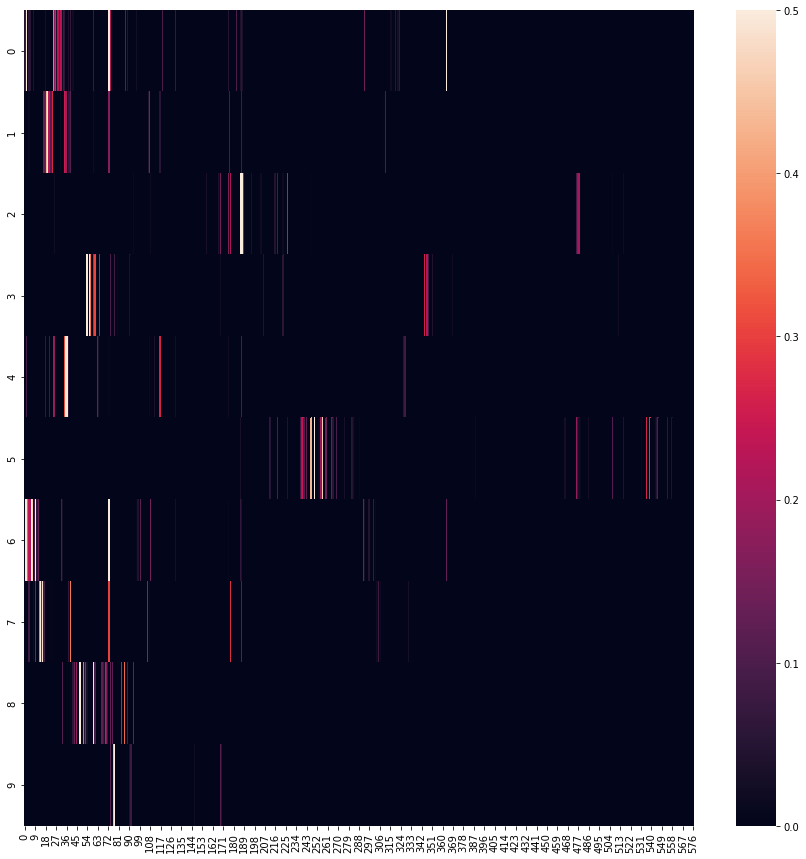

In [601]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(nmf_sk.components_, vmax=  .5)

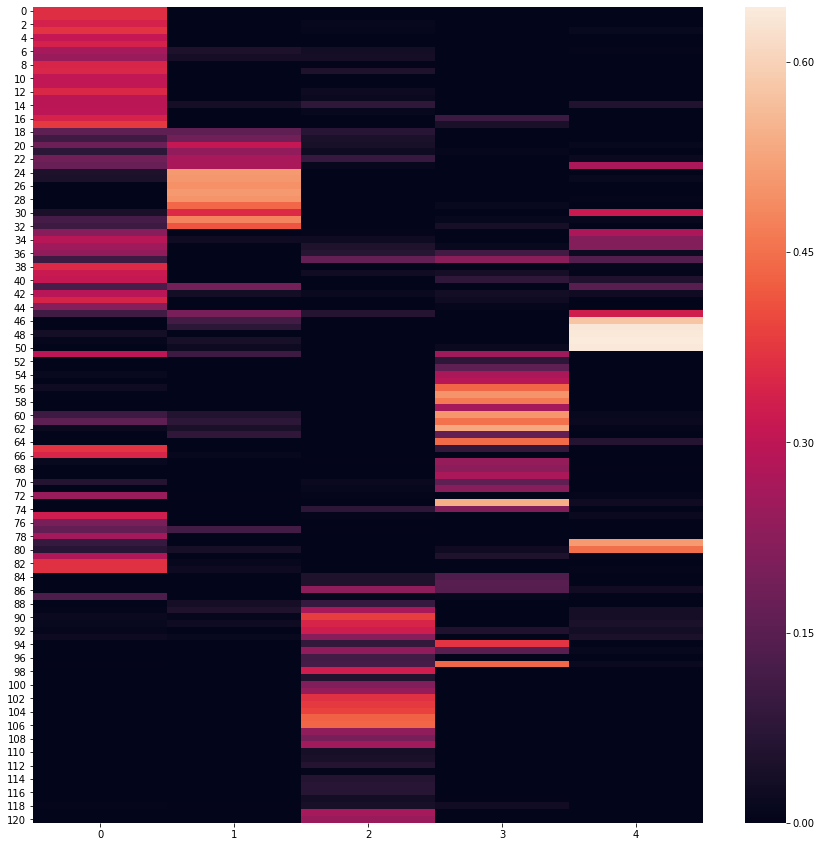

In [477]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(tnmf_sk)

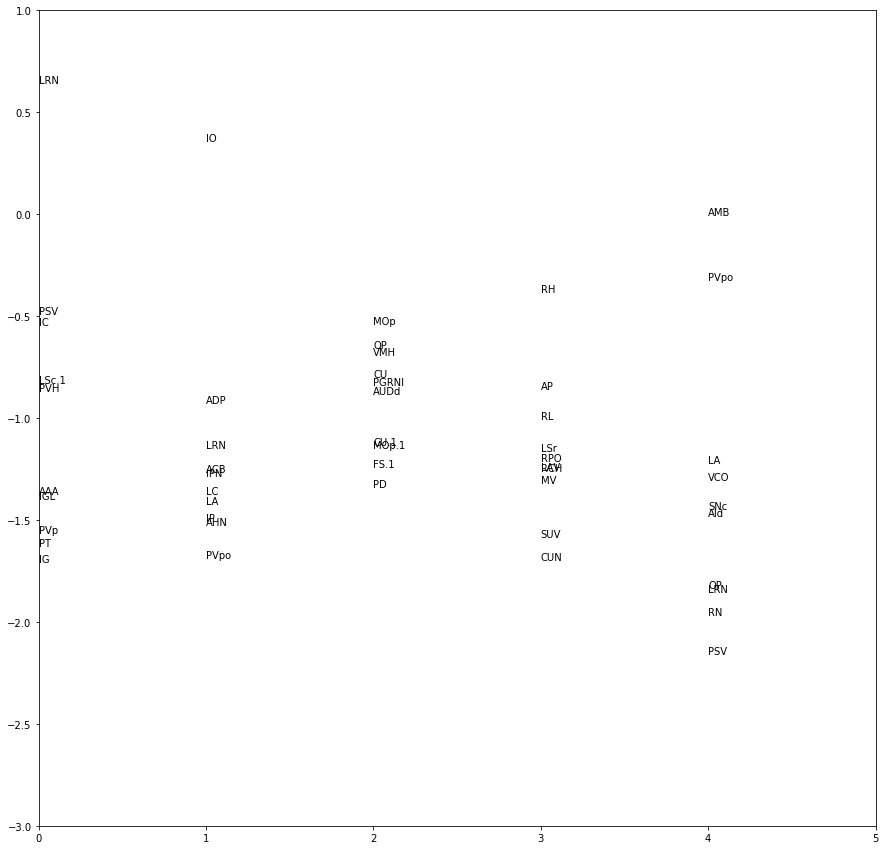

In [505]:
fig, ax  = plt.subplots(figsize = (15,15))
ax.set_xlim((0,5))
#ax.set_ylim((0,2.))
ax.set_ylim((-3,1))
for i in range(5):
    tps = (-nmf_sk.components_[i]).argsort()[:10]
    texts = colnames[tps]
    ys = np.log(nmf_sk.components_[i][tps])
    #print(ys.max())
    for j in range(10):
        #ax.scatter(i , ys[j])
        #ax.text(i + np.random.normal(0,.05,1), ys[j], texts[j])
        ax.text(i , ys[j], texts[j])

In [478]:
colnames[(-nmf_sk.components_[2]).argsort()[:10]]

array(['MOp', 'OP', 'VMH', 'CU', 'PGRNl', 'AUDd', 'CU.1', 'MOp.1', 'FS.1',
       'PD'], dtype=object)

In [472]:
nmf_sk.components_[2][(-nmf_sk.components_[2]).argsort()[:30]]

array([0.58287794, 0.51906067, 0.5011814 , 0.44860642, 0.43272091,
       0.41295689, 0.32155437, 0.31718923, 0.28903135, 0.26157064,
       0.22401241, 0.22216296, 0.22090437, 0.21315495, 0.20434661,
       0.20024046, 0.18858095, 0.18024791, 0.16957664, 0.16630136,
       0.16511575, 0.16107745, 0.13889453, 0.1367502 , 0.13098053,
       0.12578346, 0.12531375, 0.12495949, 0.12259542, 0.12003008])

In [466]:
(-nmf_sk.components_[4]).argsort()

array([ 37,  36,  35,  25, 117,  26, 187,  73,  63,   2,  22, 328,  18,
       327, 188,  38, 176, 112,  64,  20, 130, 108,  31, 189, 316,  65,
        27, 326, 317,   8, 114, 186,  61, 113,  30, 177,  98,  28, 217,
        39, 322, 293,  57, 168,  97, 192, 227, 478, 313, 132, 128, 354,
       169, 352, 194, 309, 221, 356, 124, 223,  78, 351,  47, 403, 116,
       157, 135,  92, 318, 107, 196, 458,  62, 121, 321, 415, 404, 348,
        96, 103, 123, 193, 357, 329, 159,  66, 477,  46, 119, 160, 129,
       190, 104, 311,  59,   5, 122, 353, 102, 369, 110, 312,  80, 133,
       226, 355, 170, 166, 572, 449, 175, 413, 383, 447,  99, 414, 482,
       319, 216, 412, 131, 115, 120, 125, 450, 515, 225,  91,  21, 407,
       134, 377, 191, 228, 272, 164, 411, 395, 184, 286, 299, 512, 406,
        17, 456, 454, 209, 183, 167, 337, 514, 393, 334,  94, 162, 416,
       467, 350, 505, 506, 195, 201, 408, 465, 517, 426, 342, 153, 204,
       405, 341, 172, 145, 425, 140, 452, 421, 459, 338, 215, 43

In [367]:
wt_conn.columns[73]

'LRN'

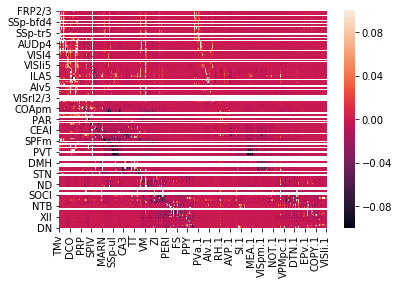

In [342]:
sns.heatmap(dist_err, vmin = -.1, vmax=  .1)

In [398]:
dist_err.iloc[1,73]

0.6463904508169567

In [394]:
data = np.asarray(dist_err, dtype = float)#[ids]

In [399]:
data[1,73]

0.6463904508169567

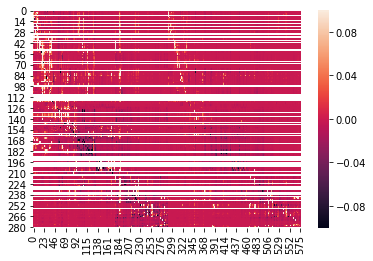

In [402]:
sns.heatmap(data, vmin = -.1, vmax=  .1)

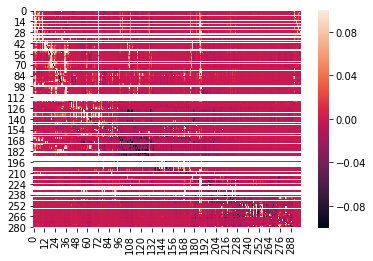

In [420]:
sns.heatmap(data[0:281,0:300], vmin = -.1, vmax= .1)

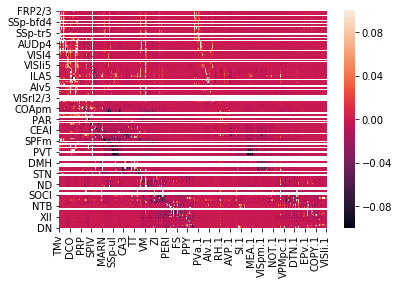

In [389]:
sns.heatmap(dist_err, vmin = -.1, vmax=  .1)

In [377]:
from sklearn.decomposition import TruncatedSVD, PCA

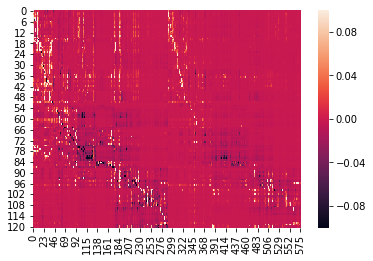

In [388]:
sns.heatmap(data, vmin = -.1, vmax=  .1)

In [435]:
from sklearn.decomposition import SparsePCA

In [447]:
rss= np.linalg.norm(wt_conn, axis = 1)
ids = np.where(~np.isnan(rss))[0]
data = np.asarray(dist_err)[ids]
tsvd = SparsePCA(n_components=5, alpha=.1, ridge_alpha=0.1)
#tsvd = TruncatedSVD(n_components=5, n_iter = 100)#PCA(n_components=121)#TruncatedSVD(n_components=500, n_iter = 100)
tsvd.fit(data)
#lsnmf = nimfa.Lsnmf(data, seed='random_vcol', rank=5, max_iter=100)
#lsnmf_fit = lsnmf()
#sns.heatmap(lsnmf_fit.basis())

SparsePCA(U_init=None, V_init=None, alpha=0.1, max_iter=1000, method='lars',
          n_components=5, n_jobs=None, normalize_components='deprecated',
          random_state=None, ridge_alpha=0.1, tol=1e-08, verbose=False)

In [448]:
tdata = tsvd.transform(data)
data_recon = tdata @ tsvd.components_ + tsvd.mean_

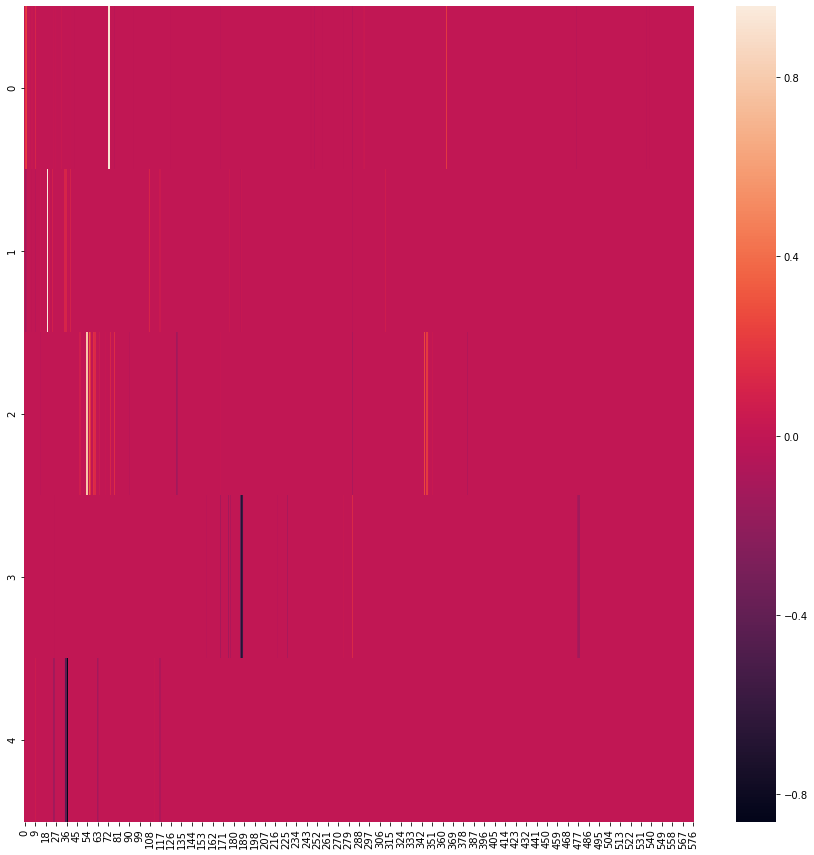

In [449]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(tsvd.components_)

In [457]:
tsvd.components_[4].argsort()

array([ 37,  36,  25,  63,  26, 117,  64,  35,   0, 386, 387, 388, 389,
       390, 391, 392, 393, 394, 395, 385, 384, 383, 382, 366, 367, 368,
       369, 370, 371, 372, 396, 373, 375, 376, 377, 378, 379, 380, 381,
       374, 397, 400, 399, 418, 419, 420, 421, 422, 423, 417, 424, 426,
       427, 428, 429, 430, 431, 425, 398, 416, 414, 365, 401, 402, 403,
       404, 405, 415, 406, 408, 409, 410, 411, 412, 413, 407, 364, 360,
       362, 312, 313, 314, 315, 316, 317, 311, 318, 320, 321, 322, 323,
       324, 325, 319, 326, 310, 308, 294, 295, 296, 297, 298, 299, 309,
       300, 302, 303, 304, 305, 306, 307, 301, 363, 327, 329, 348, 349,
       350, 351, 352, 353, 347, 354, 356, 357, 358, 359, 432, 361, 355,
       328, 346, 344, 330, 331, 332, 333, 334, 335, 345, 336, 338, 339,
       340, 341, 342, 343, 337, 433, 438, 435, 538, 537, 536, 535, 534,
       533, 532, 531, 530, 529, 528, 527, 526, 525, 524, 523, 522, 508,
       509, 510, 511, 512, 513, 539, 514, 516, 517, 518, 519, 52

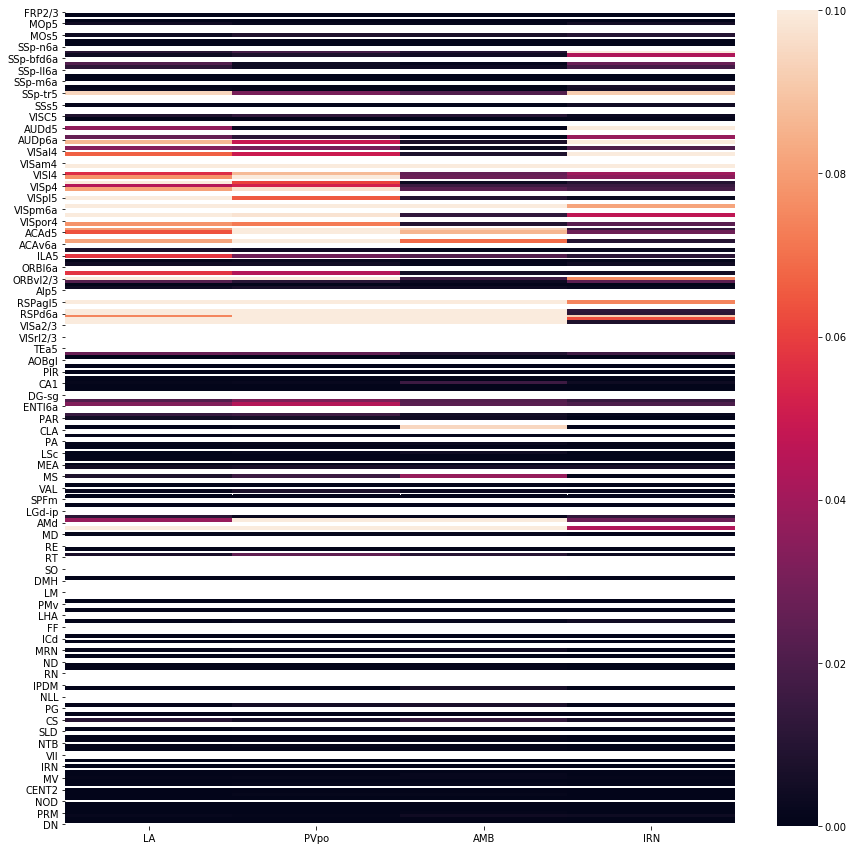

In [460]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(wt_conn.iloc[:,35:39], vmax= .1)

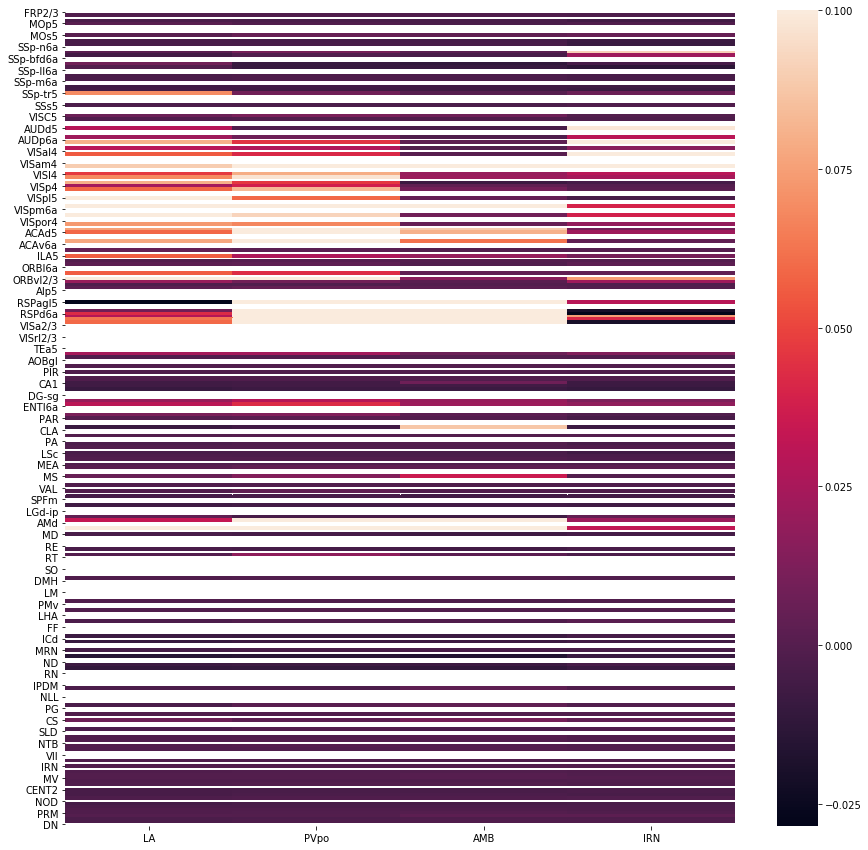

In [464]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(dist_err.iloc[:,35:39], vmax= .1)

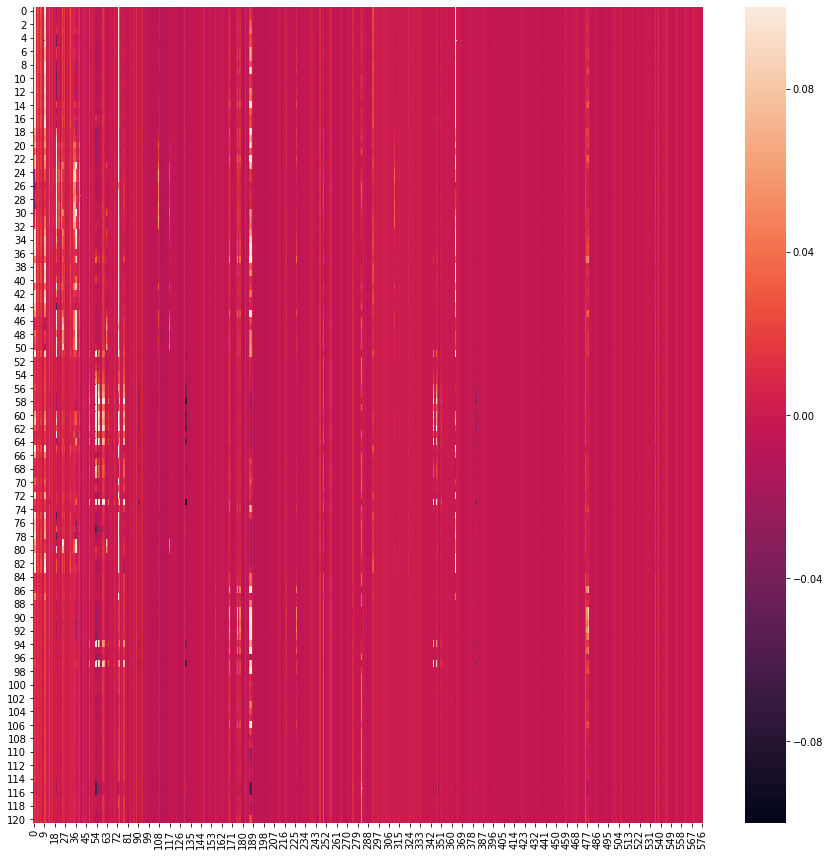

In [450]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(data_recon, vmin = -.1, vmax= .1)

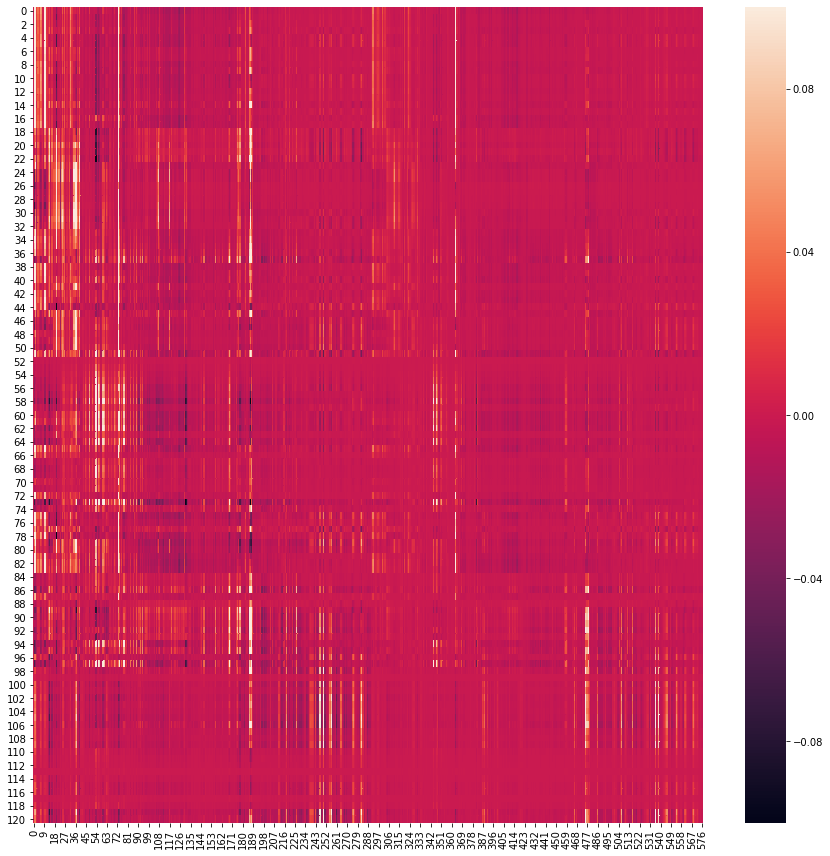

In [426]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(data_recon, vmin = -.1, vmax= .1)

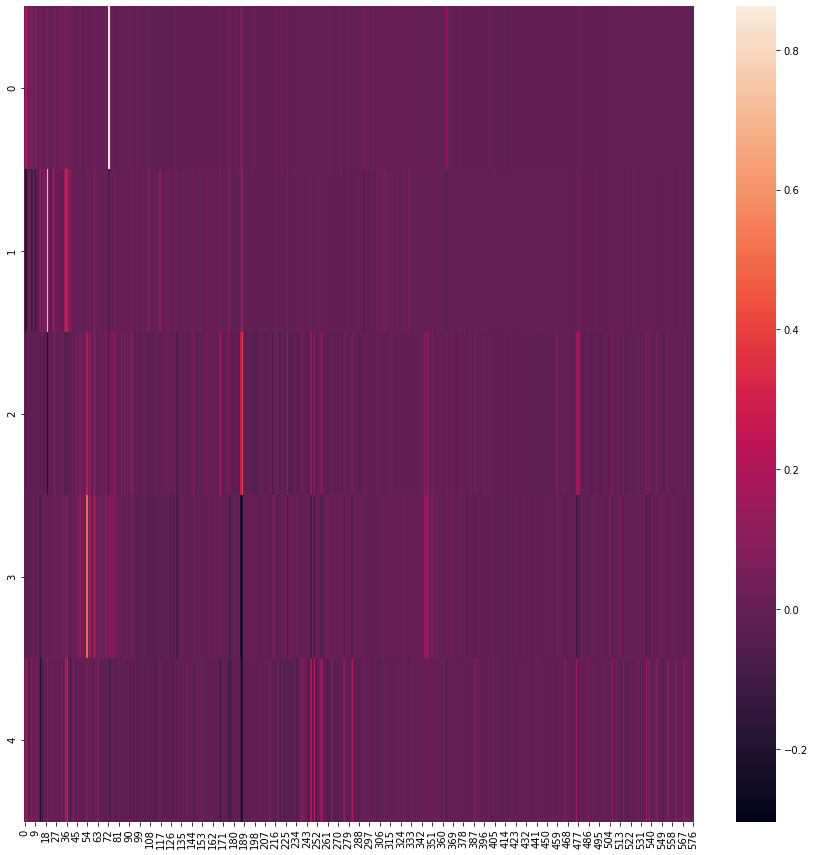

In [427]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(tsvd.components_)

In [434]:
(-tsvd.components_[0]).argsort()[:5]
(-tsvd.components_[1]).argsort()[:5]

array([ 20,  36,  37, 187,  35])

In [428]:
tsvd.components_[0,73]

0.8619940135581521

In [140]:
#plt.hist(np.expand_dims(forkde[:,0],1))

In [241]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 12)

In [243]:
cmap = viridis(range(12))

In [234]:
#plt.scatter(distances, connectivity_data.structure_datas[sid].reg_proj_norm)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


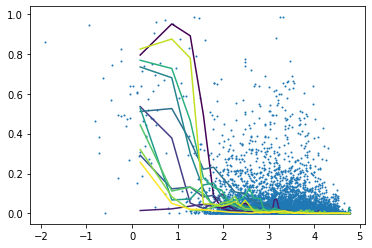

In [253]:
plt.scatter(np.log(forkde[:,0]), forkde[:,1], s= 1, alpha = 1)
for m in range(12):
    plt.plot(np.log(xs), smoothed[m], color = cmap[m])#, '-o')#, type = 'l')

In [254]:
distances.shape

(281, 577)

In [261]:
largest = np.argmax(np.asarray(wt_conn), axis = 1)

In [262]:
distances.shape

(281, 577)

In [260]:
for i in range(281):
    distances[i, largest[i]]

1.9636727055348897
34.80805268470451
7.2727039356538254
23.652722723021167
0.9637981485584347
24.25966044221996
14.439060124564199
14.660015543930355
28.45545103105759
18.19480490990169
1.121534948307863
20.609080309772995
41.439884036998635
51.463153184205616
0.5311209820889584
1.8583172328399333
49.60387164992272
40.77661723891741
31.37685115893794
29.842024248429173
40.51370436972389
32.93353444686697
1.0271747852933395
1.2216653981086123
32.53388229124631
36.42256701216381
25.29582481081726
1.5699566062793582
34.57262201292761
40.58420225155823
40.476847876342646
49.47157994015371
1.2438447233946708
47.63248245795466
38.97966050099297
38.61537446144721
22.477602292757002
20.04619087182624
61.84723135273177
61.12419109694566
1.7362551676069502
59.81903126369681
66.09898628525356
1.5425169945341153
64.29577237020712
39.69286373532312
67.27360932020797
6.085618074289205
65.92229702639358
39.86427727279117
64.62606880064365
58.4517455049275
58.49693504764068
41.601704861853634
56.68459

In [ ]:
#are these superstrongs not self-connections?

In [144]:
import sklearn

In [248]:
lr = sklearn.linear_model.LinearRegression()
mesk = ~np.isinf(np.log(forkde[:,1])) & ~np.isnan(forkde[:,1]) & ~np.isinf(np.log(forkde[:,0]))
#lr.fit(X = np.log(np.expand_dims(forkde[:,0],1)), y = np.log(forkde[:,1]))
lr.fit(X = np.log(np.expand_dims(forkde[:,0],1))[mesk], y = np.log(forkde[:,1])[mesk])# / 2)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [180]:
#mss = [connectivity_data.leaf_major_dictionary[ools[i]] for i in range(len(ools))]

In [251]:
xs = np.linspace(0, forkde[:,0].max(), 100)
smoothed_lr = np.zeros(100)
for i in range(1,100):
    smoothed_lr[i] = np.exp(lr.predict(np.log(np.expand_dims(xs[i:i+1],1))))

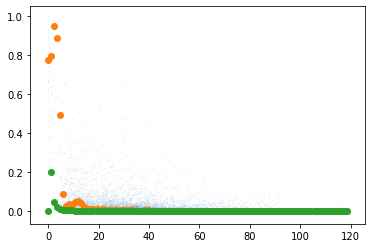

In [252]:
plt.scatter(forkde[:,0], forkde[:,1], s= .1, alpha = .1)
plt.scatter(xs, smoothed[0])
plt.scatter(xs, smoothed_lr)

(array([ 2869., 13687., 27103., 35770., 36251., 26267., 12872.,  5493.,
         1590.,   235.]),
 array([  0.        ,  11.84311907,  23.68623814,  35.5293572 ,
         47.37247627,  59.21559534,  71.05871441,  82.90183348,
         94.74495255, 106.58807161, 118.43119068]),
 <a list of 10 Patch objects>)

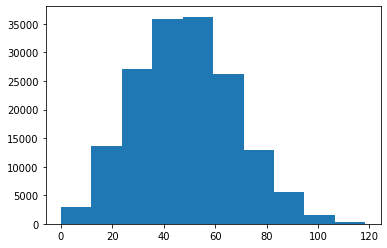

In [176]:
plt.hist(forkde[:,0])

In [170]:
np.where(np.isinf(np.log(forkde[:,1])))

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(array([   672,    691,    708, ..., 161520, 161523, 161542]),)

In [167]:
mesk

array([False, False, False, ..., False, False, False])

In [148]:
np.log(np.expand_dims(forkde[:,0],1))[mesk].min()

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

In [165]:
np.where(distances == 0)[0].shape

(116,)

In [161]:
np.where(np.isinf(np.log(forkde[:,1])))[0].shape

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(7587,)

In [162]:
np.where(np.expand_dims(forkde[:,1],1) == 0)[0].shape

(7587,)

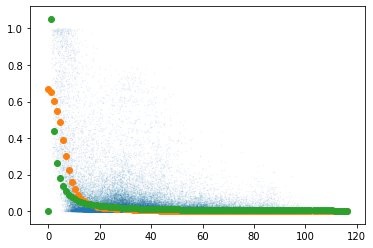

In [299]:
plt.scatter(forkde[:,0], forkde[:,1], s= .1, alpha = .1)
plt.scatter(xs, smoothed)
plt.scatter(xs, smoothed_lr)

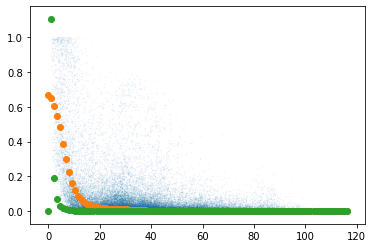

In [302]:
plt.scatter(forkde[:,0], forkde[:,1], s= .1, alpha = .1)
plt.scatter(xs, smoothed)
plt.scatter(xs, smoothed_lr)

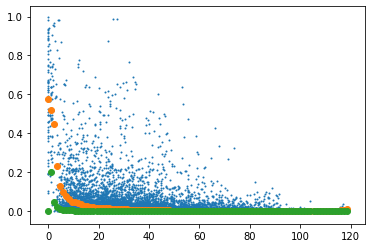

In [809]:
plt.scatter(forkde[:,0], forkde[:,1], s= 1, alpha = 1)
plt.scatter(xs, smoothed)
plt.scatter(xs, smoothed_lr)

In [246]:
len(intersection)

286

NameError: name 'intersection' is not defined

We can fit a power law
\begin{eqnarray*}
y_{ij} = bd(c_i, c_j)^{a}
\end{eqnarray*}
by taking
\begin{eqnarray*}
\log y_{ij} = \log bc^{ad(c_i, c_j)} = \log b + a \log d(c_i, c_j)
\end{eqnarray*}
so we can fit a linear regression with $(\log y_{ij}, \log d(c_i, c_j))$.

In [274]:
import sklearn

In [279]:
lr = sklearn.linear_model.LinearRegression()

In [281]:
from __future__ import division, print_function
from collections import namedtuple

import numpy as np
import scipy.stats as stats
import scipy.optimize as sopt


def _rmse(fun):
    return np.sqrt(np.mean(fun**2))

def _eval_model_fit(f, args, kwargs, **ltsq_kwargs):
    res = sopt.least_squares(f, f.x0, args=args, kwargs=kwargs, method='lm', **ltsq_kwargs)
    rmse = _rmse(res.fun)
    rsquared = f.rsquared(res.x, *args)

    return res.x, res.cost, res.fun, res.grad, res.optimality, rmse, rsquared


class LtsqFitResult(namedtuple('LtsqFitResult',
                               ('name', 'f', 'x', 'cost', 'fun', 'grad',
                                'optimality', 'rmse', 'rsquared'))):
    """A DistFit fit results"""
    __slots__ = ()

    def __new__(cls, name, f, x, cost, fun, grad, optimality, rmse, rsquared):
        return super(LtsqFitResult, cls).__new__(
            cls, name, f, x, cost, fun, grad, optimality, rmse, rsquared)

    def __eq__(self, other):
        return self.cost == other.cost

    def __lt__(self, other):
        return self.cost < other.cost

    def __le__(self, other):
        return self.cost <= other.cost


class LtsqFit(object):

    def __init__(self, functions, **least_squares_kwargs):
        self.functions = functions
        self.least_squares_kwargs = least_squares_kwargs

    def fit(self, *args, **kwargs):

        results = []
        for f in self.functions:
            name = f.__class__.__name__
            fit = _eval_model_fit(f, args, kwargs, **self.least_squares_kwargs)

            results.append(LtsqFitResult(name, f, *fit))

        self.results_ = results
        self.best_fit_ = min(results)
        self.best_f_ = self.best_fit_.f

        return self

    def predict(self, args=()):
        """get pdf @ x of best"""
        if not hasattr(self, "results_"):
            raise ValueError("must first fit!!")

        return self.best_fit_.f.predict(self.best_fit_.x, *args)

    def _results_table(self):
        """pretty printing of results"""
        def print_row(result, keys):
            row = []
            for k in keys:
                r = getattr(result, k)
                if not isinstance(r, str):
                    r = "{:.3}".format(r)
                row.append(r)

            return row, max(map(len, row))

        def join_row(row, maxlen):
            l = row[0].ljust(maxlen)
            r = "".join(x.rjust(maxlen) for x in row[1:])

            return l + r + "\n"

        header = "Fit Results"
        col_labels = ("name", "rmse", "cost", "optimality", "rsquared")
        col_underlines = ["-"*len(x) for x in col_labels]

        # break up into rows
        rows = [print_row(r, col_labels) for r in sorted(self.results_)]
        rows, maxes = zip(*rows)

        maxlen = max(maxes) + 2 # padding
        width = maxlen*len(col_labels)

        # concatenate return string
        s = '\n{:^{width}}\n'.format(header, width=width)
        s += width*"=" + "\n"
        s += join_row(col_labels, maxlen)
        s += join_row(col_underlines, maxlen)
        s += "".join(join_row(r, maxlen) for r in rows)
        return s

    def print_results(self):
        """pretty printing of results"""
        if not hasattr(self, "results_"):
            raise ValueError("must first fit!!")
        s = self._results_table()
        print(s)

    def to_dict(self):
        """returns dict of results"""
        if not hasattr(self, "results_"):
            raise ValueError("must first fit!!")

        d = dict()
        for res in self.results_:
            res_dict = res._asdict()
            name = res_dict.pop('name')
            d[name] = dict(res_dict)

        return d

    def __repr__(self):
        return "{0}(functions={1})".format(
            self.__class__.__name__,
            (f.__class__.__name__ for f in self.functions))

    def __str__(self):
        if not hasattr(self, "results_"):
            return self.__repr__()
        return self._results_table()

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [300]:
mesk = ~np.isinf(np.log(forkde[:,1])) & ~np.isnan(forkde[:,1])
#lr.fit(X = np.log(np.expand_dims(forkde[:,0],1)), y = np.log(forkde[:,1]))
lr.fit(X = np.log(np.expand_dims(forkde[:,0],1))[mesk], y = np.log(forkde[:,1])[mesk])# / 2)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [78]:
plt.scatter(np.log(np.expand_dims(forkde[:,0],1))[mesk], y = np.log(forkde[:,1])[mesk])

IndexError: too many indices for array

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


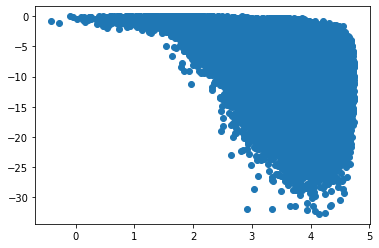

In [292]:
plt.scatter(np.log(np.expand_dims(forkde[:,0],1))[mesk], y = np.log(forkde[:,1])[mesk])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


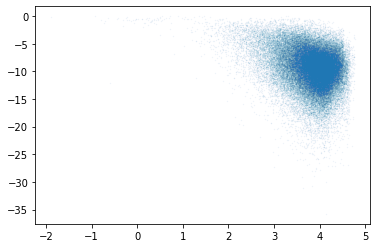

In [810]:
plt.scatter(np.log(np.expand_dims(forkde[:,0],1))[mesk], y = np.log(forkde[:,1])[mesk], s= .1, alpha = .1)

In [287]:
#np.log(forkde[:,1])[mesk].min()

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

In [282]:
#scipy.stats.linregress( x = np.log(np.expand_dims(forkde[:,0],1)), y = np.log(forkde[:,1]))

In [80]:
#np.log(forkde[:,1]).shape

0
1
2
3
4
5
6
7
8
9


KeyboardInterrupt: 

In [308]:
distances.shape

(541, 577)

In [307]:
list(enumerate(distances))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [326]:
from pathos.multiprocessing import ProcessingPool as Pool
#from multiprocessing import Pool

In [341]:
#def data_stream(a, b):
#     for i, av in enumerate(a):
#         for j, bv in enumerate(b):
#             yield (i, j), (av, bv)
def data_stream(a, b):
    for i in range(a):
        print(i)
        for j in range(b):
            yield (i, j)

In [342]:
p = Pool(5)

In [ ]:
def test_fun(dista):
    

In [343]:
p.map(lambda i: nw.predict(X = np.asarray([[distances[0, 1]]])),
                        data_stream(nsource, ntarg))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [339]:
nw.predict(X =np.asarray([[distances[0, 1]]]))

array([[0.01369924]])

In [321]:
p.map(nw.predict, enumerate(distances))

AttributeError: 'tuple' object has no attribute 'shape'

In [164]:
import scipy

In [ ]:
import matplotlib.pyplot as plt
import scipy
import scipy.stats
size = 30000
x = scipy.arange(size)
#y = scipy.int_(scipy.round_(scipy.stats.vonmises.rvs(5,size=size)*47))
h = plt.hist(y, bins=range(48))

dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,47)
plt.legend(loc='upper right')
plt.show()

In [170]:
cdists_intensities = forkde.transpose()

In [166]:
pf = scipy.stats.pareto.fit(forkde.transpose())

In [167]:
pf

(0.17993365281494594, -1.427537619383576e-11, 1.3411018301321038e-11)

<IPython.core.display.Javascript object>


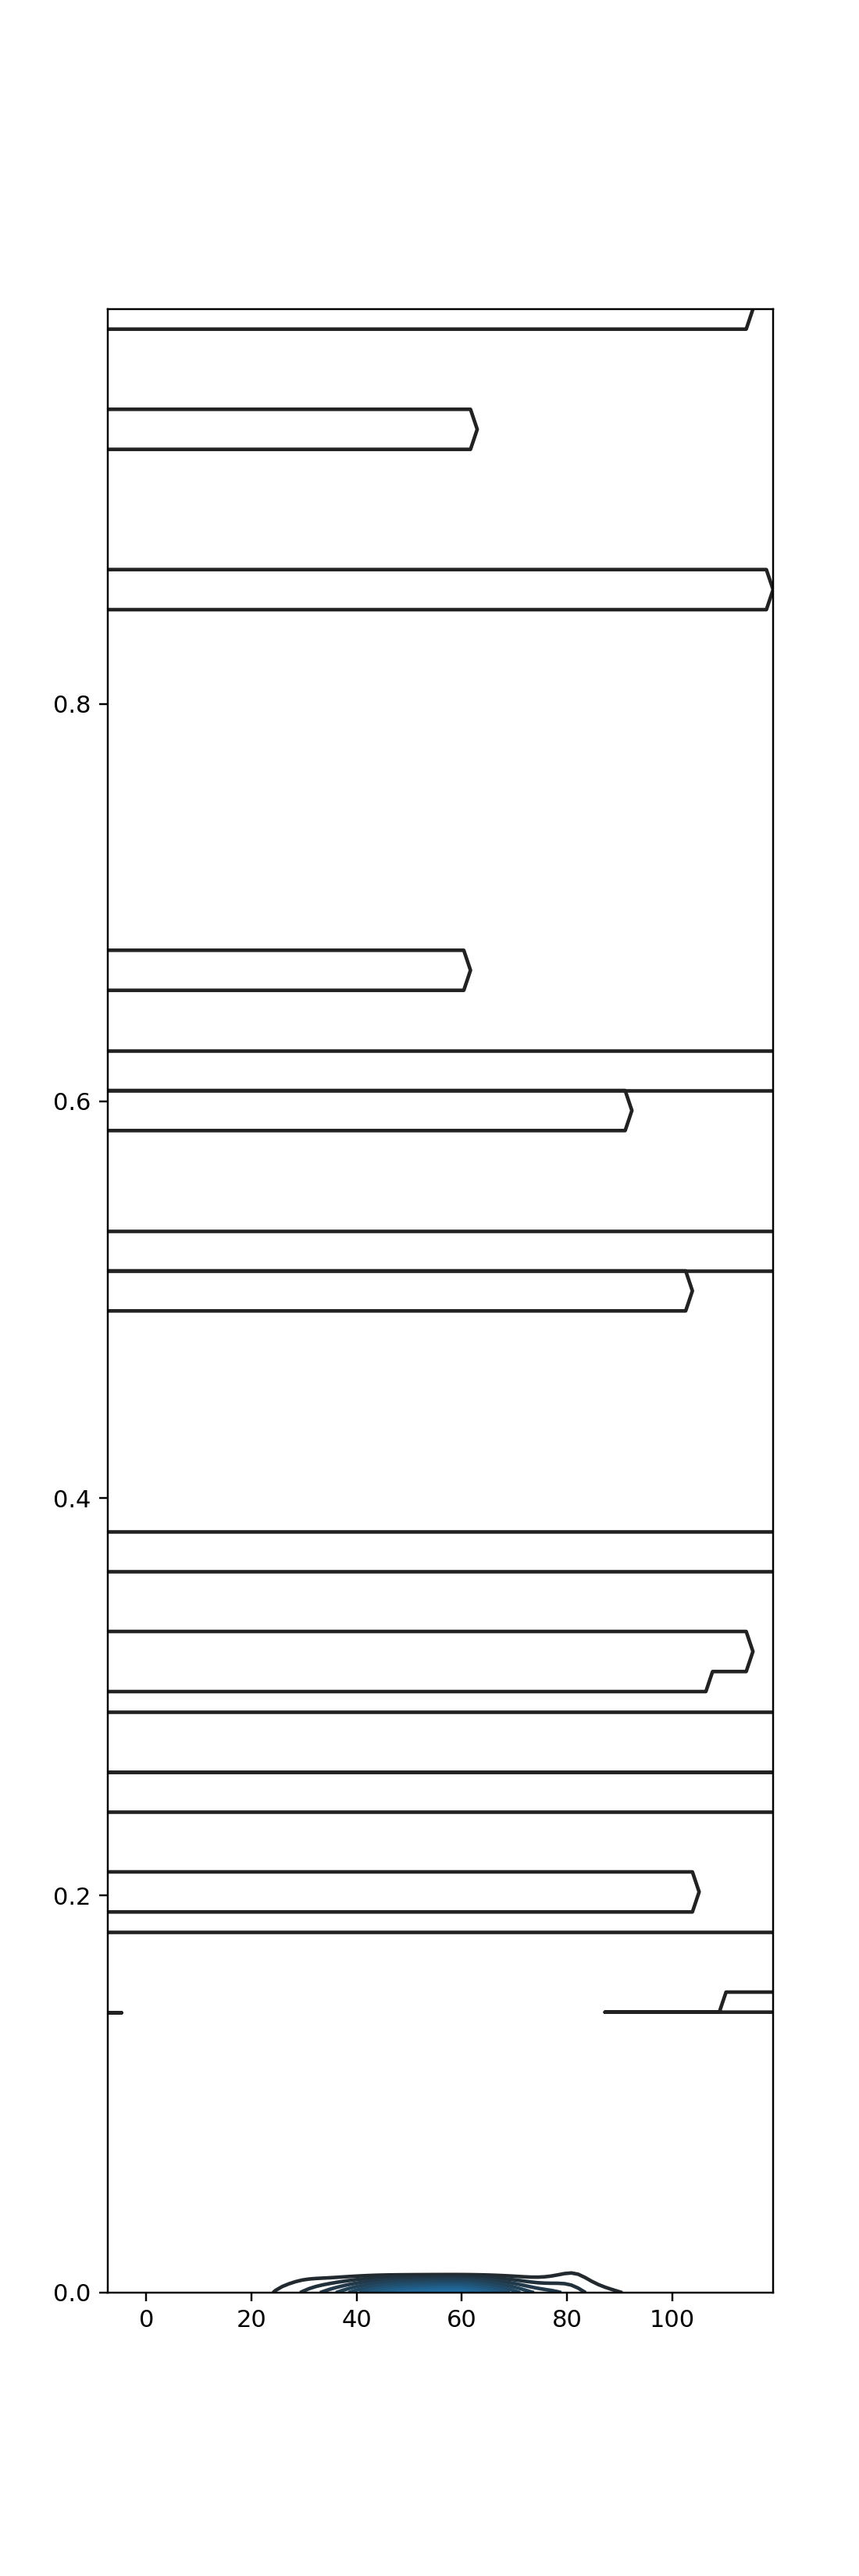

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'thresh'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


In [154]:
fig, ax = plt.subplots(figsize = (5,15))
sns.kdeplot(
    data=forkde.transpose()[:10000], 
    thresh=0,  
)

In [162]:
geyser['duration']

duration  waiting   kind
0       3.600       79   long
1       1.800       54  short
2       3.333       74   long
3       2.283       62  short
4       4.533       85   long
..        ...      ...    ...
267     4.117       81   long
268     2.150       46  short
269     4.417       90   long
270     1.817       46  short
271     4.467       74   long

[272 rows x 3 columns]

ValueError: could not convert string to float: 'long'

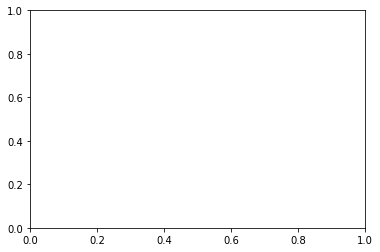

In [159]:
%matplotlib inline
geyser = sns.load_dataset("geyser")
sns.kdeplot(
    data=geyser, x="waiting", y="duration",
    fill=True, thresh=0, levels=100, cmap="mako",
)

<IPython.core.display.Javascript object>


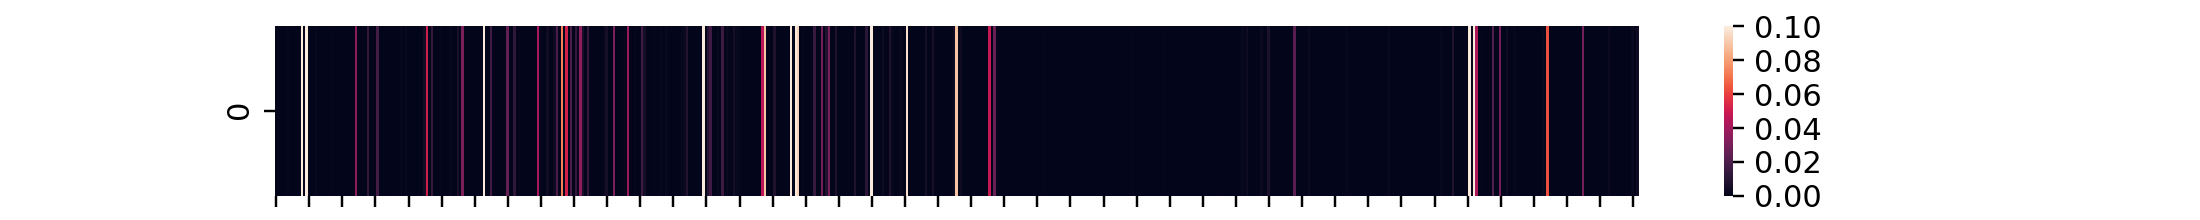

In [139]:
fig, ax = plt.subplots(figsize = (10,1))
sns.heatmap(connectivity_data.structure_datas[315].reg_proj_norm[:1], vmax= .1)#, xticklabels= rawdata_columns)

In [140]:
connectivity_data.structure_datas[315].reg_proj_norm[0][220]

0.744739837558337

In [113]:
distances[0].argmin()

220

In [114]:
connectivity_data.target_regions[220]

886

In [115]:
connectivity_data.leafs[315][0]

430

In [116]:
ia_map[430]

'RSPv2/3'

In [117]:
ia_map[886]

'RSPv'

In [102]:
proj_mask.coordinates[:,0].max(),proj_mask.coordinates[:,1].max(),proj_mask.coordinates[:,2].max()

(131, 75, 108)

In [103]:
connectivity_data.structure_datas[sid].injections.shape

(36, 27220)

In [ ]:
connectivity_data.structure_datas[sid].

In [104]:

mcc = MouseConnectivityCache(manifest_file = manifest_file, resolution = 100)

inj = mcc.get_injection_density(158375425)[0]

frac = mcc.get_injection_fraction(158375425)[0]

data_mask = mcc.get_data_mask(158375425)[0]

injfrac = inj*frac*data_mask

proj = mcc.get_projection_density(158375425)[0]


In [17]:
a,b = cache.get_injection_density(158375425)
c,d = cache.get_projection_density(158375425)
a = np.asarray(a, dtype = float)
c = np.asarray(c, dtype = float)
#plt.scatter(a,c)

<IPython.core.display.Javascript object>


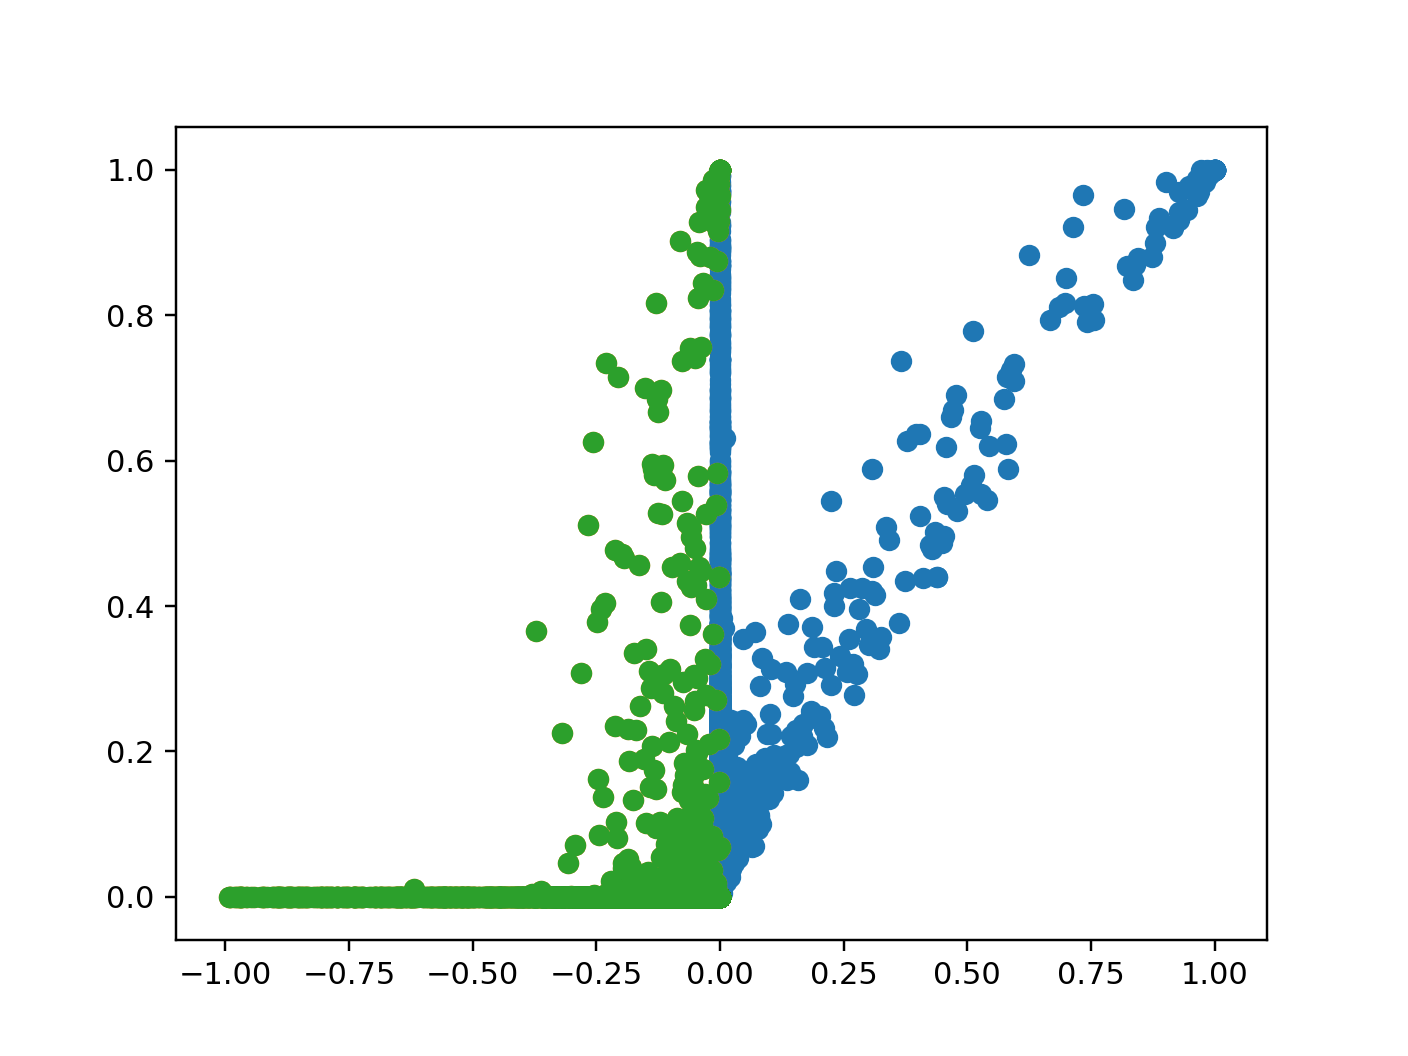

In [19]:
import matplotlib.pyplot as plt
plt.scatter(a,c)

In [22]:
plt.scatter(a - c, a)

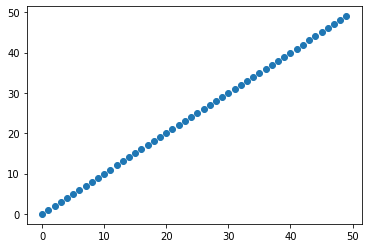

In [2]:
plt.scatter(list(range(50)), list(range(50)))

In [127]:
type(a[:2][:,:2][0][0][0])

numpy.float64

In [ ]:
# for m in range(len(major_structure_ids)):
#     print(m)
#     sid = major_structure_ids[m]
#     source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
#     source_key = source_mask.get_key(structure_ids=ontological_order_leaves)
#     source_regions, source_counts = nonzero_unique(source_key, return_counts=True)

# #    injs = msvds_leaf[sid].reg_inj_vcount_norm
# #    injr = np.reshape(injs, injs.shape[0]*injs.shape[1]) #first injes[0], then injs[1]
#     nexp = connectivity_data.structure_datas[sid].reg_inj.shape[0]
# #    leaf = np.tile(source_regions, nexp)#np.tile(source_regions, injs.shape[0])
# #    cree = np.repeat(creline[sid], injs.shape[1])

# #     ls = [ia_map[leaf[i]] for i in range(len(leaf))]
# #     crs = cree
# #     df = pd.DataFrame(np.asarray([ls, crs, injr]).transpose())
# #     df.columns = np.asarray(['leaf', 'creline','inj'])
# #     df['inj'] = np.asarray(df['inj'], dtype = float)
# #     a = df.pivot_table(values='inj',index='leaf',columns='creline',aggfunc=np.mean)

# #     fig, ax = plt.subplots(1,figsize = (50,50))
# #     sns.heatmap(a, vmax = .001,ax = ax)
# #     plt.title(str(major_structures[m]) + ' injection density')
# #     plt.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' injection density')
    
#     ls = [ia_map[leafs[sid][i]] for i in range(len(leafs[sid]))]
#     crs = connectivity_data.creline[sid]
#     df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
#     df.columns = np.asarray(['Leaf', 'Creline','present'])
#     a = df.pivot_table(values='present',index='Leaf',columns='Creline',aggfunc=np.sum)
#     a = a.fillna(0)
#     revels = a
#     ticks=np.arange(revels.values.min(),revels.values.max()+1 )
#     boundaries = np.arange(revels.values.min()-.5,revels.values.max()+1.5 )
#     cmap = plt.get_cmap("YlOrRd", revels.values.max()-revels.values.min()+1)
#     fig, ax = plt.subplots(figsize = (15,15))
#     sns.heatmap(revels, annot=True, linewidths=0.4, cmap=cmap,
#             cbar_kws={"ticks":ticks, "boundaries":boundaries}, ax=ax, fon)
#     plt.tight_layout()
#     plt.show()
#     ax.set_title(major_structures[m])
#     #plt.title(major_structures[m])
#     plt.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' centroid density33')
    
# #     fig, ax = plt.subplots(1,figsize = (50,50))
# #     sns.heatmap(a, ax = ax)
# #     plt.title(str(major_structures[m]) + ' centroid density')
# #     plt.savefig(workingdirectory + '/analyses/figures/' + str(major_structures[m]) + ' centroid density2')
    
#     #plt.xlabel(fontsize = 15)

In [ ]:
ipsis = np.asarray([ia_map[connectivity_data.ipsi_target_regions[i]] for i in range(len( connectivity_data.ipsi_target_regions))])
contras = np.asarray([ia_map[connectivity_data.contra_target_regions[i]] for i in range(len( connectivity_data.contra_target_regions))])
rawdata_columns  = np.concatenate([ipsis, contras])

<IPython.core.display.Javascript object>


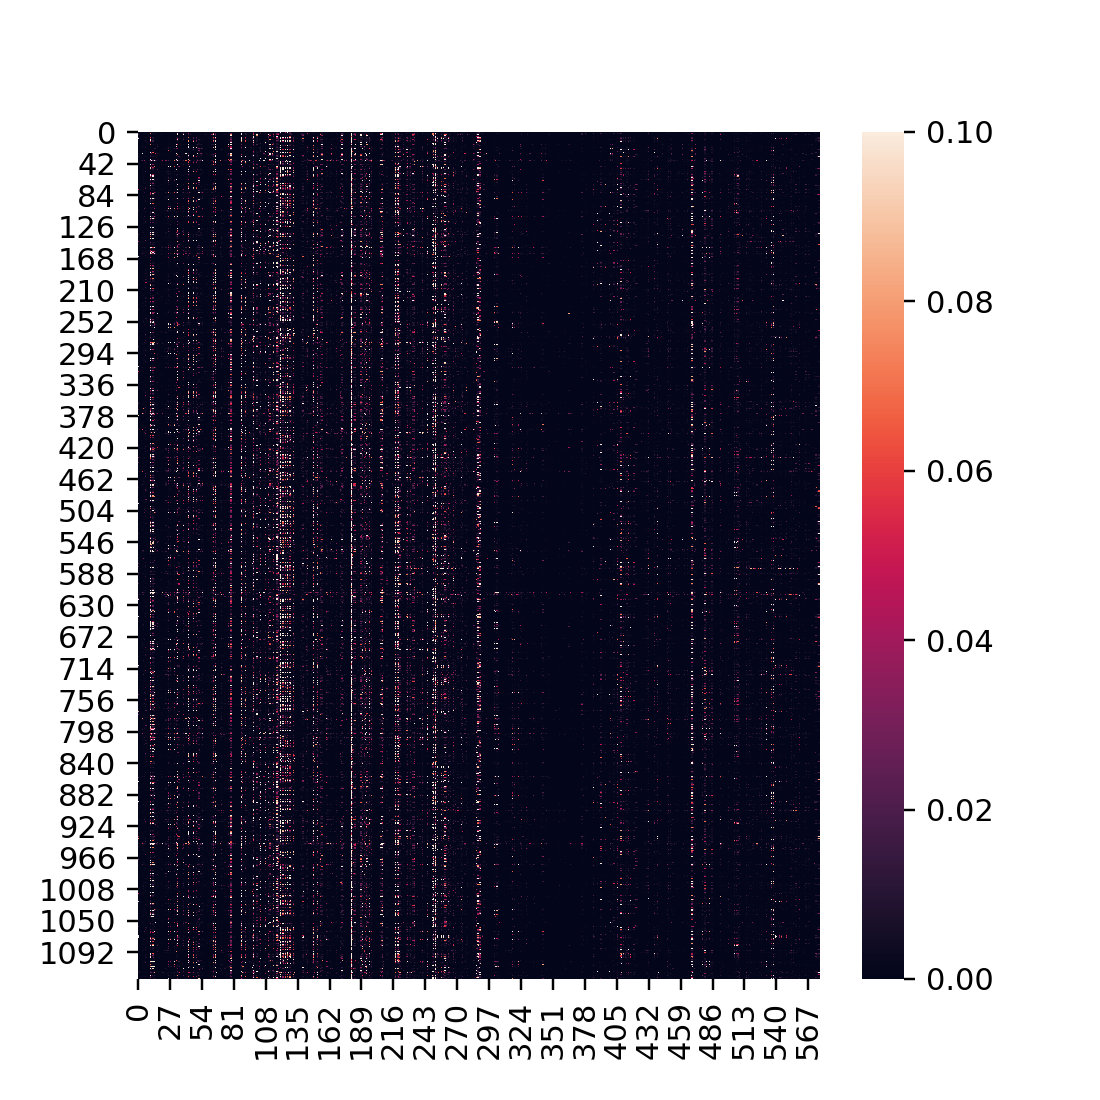

In [130]:
fig, ax = plt.subplots(figsize = (5,5))
sns.heatmap(connectivity_data.structure_datas[315].reg_proj_norm, vmax= .1)

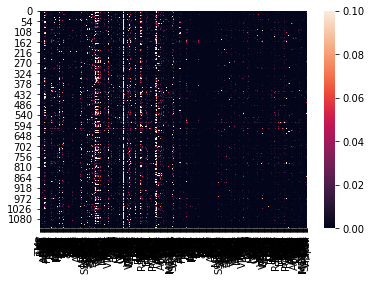

In [19]:
sns.heatmap(connectivity_data.structure_datas[315].reg_proj_norm, vmax= .1, xticklabels= rawdata_columns)

In [10]:
xs = np.mean(connectivity_data.structure_datas[315].reg_proj_norm, axis = 0)

In [11]:
ys = np.median(connectivity_data.structure_datas[315].reg_proj_norm, axis = 0)

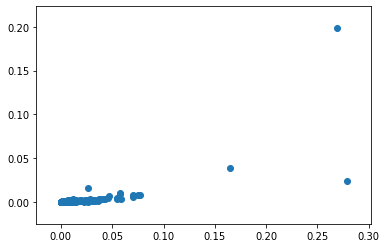

In [12]:
plt.scatter(np.mean(connectivity_data.structure_datas[315].reg_proj_norm, axis = 0),np.median(connectivity_data.structure_datas[315].reg_proj_norm, axis = 0))

In [15]:
fig, ax = plt.subplots(figsize = (15,15))
ax.text(np.concatenate([ipsis, contras]), xs,ys)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(['TMv' 'IC' 'PSV' 'IF' 'PT' 'IG' 'AAA' 'IGL' 'PVa' 'III' 'PVH' 'ACAd'
 'ILA' 'ACAv' 'ACB' 'IMD' 'PVHd' 'AD' 'LT' 'ADP' 'IO' 'AHN' 'IP' 'DCO'
 'IPN' 'VCO' 'AId' 'ISN' 'AIp' 'IV' 'PVi' 'AIv' 'PVp' 'AM' 'MRN' 'LA'
 'PVpo' 'AMB' 'IRN' 'PRNr' 'LC' 'PVT' 'AOB' 'LD' 'AON' 'LDT' 'PRP' 'LGd'
 'RCH' 'NR' 'LGv' 'RE' 'FRP' 'LH' 'RH' 'LHA' 'RL' 'MV' 'LIN' 'RM' 'AP'
 'LAV' 'LM' 'RN' 'APN' 'SUV' 'LP' 'RO' 'ARH' 'SPIV' 'LPO' 'RPA' 'AT' 'LRN'
 'RPO' 'RR' 'LSc' 'AV' 'LSr' 'RT' 'AVP' 'LSv' 'SAG' 'AVPV' 'B' 'SCH' 'BAC'
 'BA' 'SCm' 'BLA' 'MA' 'SCs' 'MARN' 'SF' 'SG' 'BMA' 'SubG' 'SGN' 'SSp-bfd'
 'ASO' 'SH' 'SSp-ll' 'SFO' 'SI' 'SSp-m' 'SBPV' 'SLC' 'BST' 'SSp-n' 'PST'
 'SLD' 'SSp-tr' 'MD' 'PSTN' 'SMT' 'SSp-ul' 'ICB' 'SNc' 'SSs' 'SNr' 'CA1'
 'VISp' 'SO' 'VISam' 'SOC' 'VISal' 'MEA' 'VISl' 'SPFm' 'VISrl' 'SPFp'
 'CA2' 'VISpl' 'SPVC' 'SPVI' 'SPVO' 'MEPO' 'MEV' 'CA3' 'STN' 'MG' 'MH'
 'MM' 'SUB' 'MOB' 'MPN' 'MPO' 'SUM' 'MPT' 'VISpm' 'SUT' 'CEA' 'TEa' 'MS'
 'TR' 'TRN' 'CL' 'ACVII' 'NB' 'TRS' 'CLA' 'TT' 'CLI' 'N

ConversionError: Failed to convert value(s) to axis units: array(['TMv', 'IC', 'PSV', 'IF', 'PT', 'IG', 'AAA', 'IGL', 'PVa', 'III',
       'PVH', 'ACAd', 'ILA', 'ACAv', 'ACB', 'IMD', 'PVHd', 'AD', 'LT',
       'ADP', 'IO', 'AHN', 'IP', 'DCO', 'IPN', 'VCO', 'AId', 'ISN', 'AIp',
       'IV', 'PVi', 'AIv', 'PVp', 'AM', 'MRN', 'LA', 'PVpo', 'AMB', 'IRN',
       'PRNr', 'LC', 'PVT', 'AOB', 'LD', 'AON', 'LDT', 'PRP', 'LGd',
       'RCH', 'NR', 'LGv', 'RE', 'FRP', 'LH', 'RH', 'LHA', 'RL', 'MV',
       'LIN', 'RM', 'AP', 'LAV', 'LM', 'RN', 'APN', 'SUV', 'LP', 'RO',
       'ARH', 'SPIV', 'LPO', 'RPA', 'AT', 'LRN', 'RPO', 'RR', 'LSc', 'AV',
       'LSr', 'RT', 'AVP', 'LSv', 'SAG', 'AVPV', 'B', 'SCH', 'BAC', 'BA',
       'SCm', 'BLA', 'MA', 'SCs', 'MARN', 'SF', 'SG', 'BMA', 'SubG',
       'SGN', 'SSp-bfd', 'ASO', 'SH', 'SSp-ll', 'SFO', 'SI', 'SSp-m',
       'SBPV', 'SLC', 'BST', 'SSp-n', 'PST', 'SLD', 'SSp-tr', 'MD',
       'PSTN', 'SMT', 'SSp-ul', 'ICB', 'SNc', 'SSs', 'SNr', 'CA1', 'VISp',
       'SO', 'VISam', 'SOC', 'VISal', 'MEA', 'VISl', 'SPFm', 'VISrl',
       'SPFp', 'CA2', 'VISpl', 'SPVC', 'SPVI', 'SPVO', 'MEPO', 'MEV',
       'CA3', 'STN', 'MG', 'MH', 'MM', 'SUB', 'MOB', 'MPN', 'MPO', 'SUM',
       'MPT', 'VISpm', 'SUT', 'CEA', 'TEa', 'MS', 'TR', 'TRN', 'CL',
       'ACVII', 'NB', 'TRS', 'CLA', 'TT', 'CLI', 'NDB', 'CM', 'NI', 'SPA',
       'NLL', 'TU', 'CUN', 'NLOT', 'V', 'NOT', 'VAL', 'NPC', 'COAa',
       'NTB', 'COAp', 'NTS', 'VI', 'VII', 'CP', 'VISC', 'CS', 'VM',
       'VLPO', 'VMH', 'OP', 'CU', 'VPL', 'ORBl', 'VPLpc', 'DG', 'ORBm',
       'VPM', 'VPMpc', 'ORBvl', 'VTA', 'OT', 'VTN', 'OV', 'x', 'XII',
       'PA', 'y', 'PAA', 'PAG', 'ZI', 'DP', 'DMH', 'DMX', 'PAR', 'DN',
       'PARN', 'PAS', 'PB', 'DR', 'PBG', 'RSPd', 'DTN', 'RSPv', 'RSPagl',
       'ECT', 'PCG', 'ECU', 'PCN', 'LING', 'PD', 'ENTl', 'CENT', 'PERI',
       'ENTm', 'CUL', 'PF', 'PG', 'DEC', 'FOTU', 'PH', 'PYR', 'EPd',
       'UVU', 'PIR', 'EPv', 'NOD', 'PGRNd', 'PL', 'EW', 'PGRNl', 'PMd',
       'FC', 'MOp', 'FN', 'MOs', 'FS', 'AUDp', 'PMv', 'SIM', 'AUDd', 'AN',
       'AUDv', 'PO', 'GPe', 'PRM', 'AUDpo', 'POL', 'GPi', 'COPY', 'POST',
       'GR', 'PFL', 'PP', 'GRN', 'FL', 'PPN', 'GU', 'PPT', 'PPY', 'PR',
       'PRE', 'PRNc', 'MDRNd', 'IA', 'MDRNv', 'PS', 'IAD', 'IAM', 'TMd',
       'SSp-un', 'VISa', 'VISli', 'VISpor', 'TMv', 'IC', 'PSV', 'IF',
       'PT', 'IG', 'AAA', 'IGL', 'PVa', 'III', 'PVH', 'ACAd', 'ILA',
       'ACAv', 'ACB', 'IMD', 'PVHd', 'AD', 'LT', 'ADP', 'IO', 'AHN', 'IP',
       'DCO', 'IPN', 'VCO', 'AId', 'ISN', 'AIp', 'IV', 'PVi', 'AIv',
       'PVp', 'AM', 'MRN', 'LA', 'PVpo', 'AMB', 'IRN', 'PRNr', 'LC',
       'PVT', 'AOB', 'LD', 'AON', 'LDT', 'PRP', 'LGd', 'RCH', 'NR', 'LGv',
       'RE', 'FRP', 'LH', 'RH', 'LHA', 'RL', 'MV', 'LIN', 'AP', 'LAV',
       'LM', 'RN', 'APN', 'SUV', 'LP', 'ARH', 'SPIV', 'LPO', 'AT', 'LRN',
       'RPO', 'RR', 'LSc', 'AV', 'LSr', 'RT', 'AVP', 'LSv', 'SAG', 'AVPV',
       'B', 'SCH', 'BAC', 'BA', 'SCm', 'BLA', 'MA', 'SCs', 'MARN', 'SF',
       'SG', 'BMA', 'SubG', 'SGN', 'SSp-bfd', 'ASO', 'SH', 'SSp-ll',
       'SFO', 'SI', 'SSp-m', 'SBPV', 'SLC', 'BST', 'SSp-n', 'PST', 'SLD',
       'SSp-tr', 'MD', 'PSTN', 'SMT', 'SSp-ul', 'ICB', 'SNc', 'SSs',
       'SNr', 'CA1', 'VISp', 'SO', 'VISam', 'SOC', 'VISal', 'MEA', 'VISl',
       'SPFm', 'VISrl', 'SPFp', 'CA2', 'VISpl', 'SPVC', 'SPVI', 'SPVO',
       'MEPO', 'MEV', 'CA3', 'STN', 'MG', 'MH', 'MM', 'SUB', 'MOB', 'MPN',
       'MPO', 'SUM', 'MPT', 'VISpm', 'SUT', 'CEA', 'TEa', 'MS', 'TR',
       'TRN', 'CL', 'ACVII', 'NB', 'TRS', 'CLA', 'TT', 'CLI', 'NDB', 'CM',
       'NI', 'SPA', 'NLL', 'TU', 'CUN', 'NLOT', 'V', 'NOT', 'VAL', 'NPC',
       'COAa', 'NTB', 'COAp', 'NTS', 'VI', 'VII', 'CP', 'VISC', 'CS',
       'VM', 'VLPO', 'VMH', 'OP', 'CU', 'VPL', 'ORBl', 'VPLpc', 'DG',
       'ORBm', 'VPM', 'VPMpc', 'ORBvl', 'VTA', 'OT', 'VTN', 'x', 'XII',
       'PA', 'y', 'PAA', 'PAG', 'ZI', 'DP', 'DMH', 'DMX', 'PAR', 'DN',
       'PARN', 'PAS', 'PB', 'DR', 'PBG', 'RSPd', 'DTN', 'RSPv', 'RSPagl',
       'ECT', 'PCG', 'ECU', 'PCN', 'LING', 'PD', 'ENTl', 'CENT', 'PERI',
       'ENTm', 'CUL', 'PF', 'PG', 'DEC', 'FOTU', 'PH', 'PYR', 'EPd',
       'UVU', 'PIR', 'EPv', 'NOD', 'PGRNd', 'PL', 'PGRNl', 'PMd', 'FC',
       'MOp', 'FN', 'MOs', 'FS', 'AUDp', 'PMv', 'SIM', 'AUDd', 'AN',
       'AUDv', 'PO', 'GPe', 'PRM', 'AUDpo', 'POL', 'GPi', 'COPY', 'POST',
       'GR', 'PFL', 'PP', 'GRN', 'FL', 'PPN', 'GU', 'PPT', 'PPY', 'PR',
       'PRE', 'PRNc', 'MDRNd', 'IA', 'MDRNv', 'PS', 'IAD', 'IAM', 'TMd',
       'SSp-un', 'VISa', 'VISli', 'VISpor'], dtype='<U7')

<Figure size 1080x1080 with 1 Axes>

In [ ]:
%matplotlib notebook
#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

# ax.scatter(msvds[sid].projection_mask.coordinates[:,0], 
#            msvds[sid].projection_mask.coordinates[:,1], 
#            msvds[sid].projection_mask.coordinates[:,2], alpha = .01, s = .1)


nvox = connectivity_data.structure_datas[sid].injections.shape[1]
inj_colors = np.zeros((nvox,4))
inj_colors[:,1] = 1.0
inj_colors[:, 3] = connectivity_data.structure_datas[sid].injections[ind] / connectivity_data.structure_datas[sid].injections[ind].max()


ax.scatter(m4.coordinates[:,0], 
           m4.coordinates[:,1], 
           m4.coordinates[:,2], s= .1, c= 'yellow')

ax.scatter(m5.coordinates[:,0], 
           m5.coordinates[:,1], 
           m5.coordinates[:,2], s= .1, c= 'purple')

ax.scatter(m6a.coordinates[:,0], 
           m6a.coordinates[:,1], 
           m6a.coordinates[:,2], s= .1, c= 'red')

ax.scatter(connectivity_data.structure_datas[sid].centroids[ind][0],
          connectivity_data.structure_datas[sid].centroids[ind][1],
          connectivity_data.structure_datas[sid].centroids[ind][2], s = 5)

ax.scatter(connectivity_data.structure_datas[sid].injection_mask.coordinates[:,0], 
           connectivity_data.structure_datas[sid].injection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].injection_mask.coordinates[:,2], s= 1, c= inj_colors)

ax.set_axis_off()

In [ ]:
%matplotlib notebook
#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

# ax.scatter(msvds[sid].projection_mask.coordinates[:,0], 
#            msvds[sid].projection_mask.coordinates[:,1], 
#            msvds[sid].projection_mask.coordinates[:,2], alpha = .01, s = .1)

nvox = msvds[sid].projections.shape[1]
proj_colors = np.zeros((nvox,4))
proj_colors[:,0] = 1.0
proj_colors[:, 3] = msvds[sid].projections[0] / msvds[sid].projections[0].max()

ax.scatter(msvds[sid].projection_mask.coordinates[:,0], 
           msvds[sid].projection_mask.coordinates[:,1], 
           msvds[sid].projection_mask.coordinates[:,2], s= .1, c= proj_colors)

nvox = msvds[sid].injections.shape[1]
inj_colors = np.zeros((nvox,4))
inj_colors[:,1] = 1.0
inj_colors[:, 3] = msvds[sid].injections[0] / msvds[sid].injections[0].max()


ax.scatter(msvds[sid].injection_mask.coordinates[:,0], 
           msvds[sid].injection_mask.coordinates[:,1], 
           msvds[sid].injection_mask.coordinates[:,2], s= 1, c= inj_colors)

ax.set_axis_off()

In [ ]:
#check if same anywhere
plt.scatter(injection_density, projection_density)